# Knowledge Distillation

In [ ]:
import os

# Define paths
input_metadata_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv'
output_wavs_path = '/kaggle/working/wavs'  # The path you want in the text file
output_text_file = '/kaggle/working/ljspeech.txt'  # The desired output text file

# Process the metadata.csv
print("Processing metadata.csv...")
with open(input_metadata_path, 'r', encoding='utf-8') as metadata_file, \
     open(output_text_file, 'w', encoding='utf-8') as output_file:

    for line in metadata_file:
        parts = line.strip().split('|')
        if len(parts) < 2:
            continue  # Skip malformed lines

        filename = parts[0] + '.wav'  # Add .wav extension
        # Use the second field as the transcription text (normalized text)
        transcription = parts[1].strip()

        # Construct the desired path to the wav file
        wav_path = os.path.join(output_wavs_path, filename)

        # Format the line as desired
        output_line = f"{wav_path}|{transcription}\n"

        # Write to the output file
        output_file.write(output_line)

print(f"Filelist generated at {output_text_file}")


In [2]:
# Import necessary libraries
import os
import io
import logging
import time
import random
import numpy as np
import matplotlib.pylab as plt
from IPython.display import display  # For displaying plots in Kaggle

# Suppress warnings
os.environ['PYTHONWARNINGS'] = 'ignore:RuntimeWarning'
if os.path.isdir("/kaggle/input/tacotron/TTS-TT2"):
    os.chdir("/kaggle/input/tacotron/TTS-TT2")
    os.system('git submodule init')
    os.system('git submodule update')
%matplotlib inline

# Set logging levels to suppress warnings
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)

# Install required Python packages
!pip install matplotlib numpy inflect scipy Unidecode pillow
!pip install git+https://github.com/wkentaro/gdown.git
!pip install ffmpeg-normalize

# Import remaining necessary modules
import argparse
import math
from numpy import finfo

import torch
# from distributed import apply_gradient_allreduce
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
from tqdm import tqdm
from distutils.dir_util import copy_tree

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_mels(data_path):
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob(os.path.join(data_path, '*.wav'))
    for i in tqdm(wavs):
        save_mel(i)

def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= n_gpus
    return rt

def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")

def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=0, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger

def load_model(hparams):
    model = Tacotron2(hparams).to(device)
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model

def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print(f"Warm starting model from checkpoint '{checkpoint_path}'")
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model

def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print(f"Loading checkpoint '{checkpoint_path}'")
    checkpoint_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print(f"Loaded checkpoint '{checkpoint_path}' from iteration {iteration}")
    return model, optimizer, learning_rate, iteration

def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    print(f"Saving model and optimizer state at iteration {iteration} to {filepath}")
    try:
        torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("Interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width / 100), int(alignment_graph_height / 100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower', interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += f'\n\n{info}'
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    
    display(fig)  # Display the figure in the notebook
    plt.close(fig)

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=0,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print(f"Epoch: {epoch} Validation loss {iteration}: {val_loss:.6f}  Time: {(time.perf_counter()-start_eposh)/60:.1f}m LR: {learning_rate:.6f}")
#         logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            alignment = alignments[idx].data.cpu().numpy().T
            info = f'Iteration {iteration}'
            plot_alignment(alignment, info=info)
        return val_loss

def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if not os.path.exists(file[0]):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files)  # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files)  # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")


fatal: detected dubious ownership in repository at '/kaggle/input/tacotron/TTS-TT2'
To add an exception for this directory, call:

	git config --global --add safe.directory /kaggle/input/tacotron/TTS-TT2
fatal: detected dubious ownership in repository at '/kaggle/input/tacotron/TTS-TT2'
To add an exception for this directory, call:

	git config --global --add safe.directory /kaggle/input/tacotron/TTS-TT2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 8.7 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-lup4_uwe
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-lup4_uwe
  Resolved https://github.com/wkentaro/gdown.git to commit eeb6995f2e077991576b35956983bbefe34cf057
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-5.2.0-py3-none-any.whl size=18227 sha256=b9ff00c09d09a30efd774ec676d57f2148fd1bf634e41aa49150853cd70aa628
  Stored in directory: /tmp/pip-ephem-wheel-cache-ifrgga_c/wheels/fd/60/cb/27c249beb4394fdd33835656e3578fba044b022e1d185b3ba8
Successfully built gdown
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 2.6 MB/s eta 0:00:00


/kaggle/input/tacotron/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/kaggle/input/tacotron/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


In [3]:
# Set parameters
warm_start = True
n_gpus = 1
rank = 0
group_name = None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'lj2'  # Your desired model name

# Copy the filelists to a writable directory
import shutil
os.makedirs('/kaggle/working/filelists', exist_ok=True)
shutil.copy('/kaggle/working/ljspeech.txt', '/kaggle/working/filelists/list.txt')

hparams.training_files = '/kaggle/working/filelists/list.txt'
hparams.validation_files = '/kaggle/working/filelists/list.txt'

# Hyperparameters to tune
hparams.p_attention_dropout = 0.1
hparams.p_decoder_dropout = 0.1

# Learning Rate
hparams.decay_start = 15000  # Wait till decay_start to start decaying learning rate

# Start/Max Learning Rate
hparams.A_ = 3e-4
hparams.B_ = 8000  # Decay Rate
hparams.C_ = 0.1  # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-6  # Min Learning Rate

# Quality of Life
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000

# Batch size
hparams.batch_size = 6
hparams.load_mel_from_disk = True
hparams.ignore_layers = []  # Layers to reset (None by default)
use_cmudict = True
hparams.epochs = 250

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

# Output directories
output_directory = '/kaggle/working/outdir'  # Where to save your model when training
log_directory = '/kaggle/working/logs'  # Location to save log files locally
log_directory2 = None  # Set to another directory if needed
checkpoint_path = os.path.join(output_directory, model_filename)

hparams.text_cleaners = ["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict else [])

In [4]:
# ---- Replace .wav with .npy in filelists ----
import glob

def replace_wav_with_npy(filelist_path):
    with open(filelist_path, 'r') as file:
        lines = file.readlines()
    new_lines = [line.replace('.wav|', '.npy|') for line in lines]
    with open(filelist_path, 'w') as file:
        file.writelines(new_lines)

filelist_paths = glob.glob('/kaggle/working/filelists/*.txt')
for filelist_path in filelist_paths:
    replace_wav_with_npy(filelist_path)

# Ensure the 'wavs' directory exists
data_path = '/kaggle/working/wavs'
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Copy .wav files from Kaggle input directory to 'wavs' directory
input_wavs_path = '/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs'  # Replace with your actual dataset path
if os.path.exists(input_wavs_path):
    print("\nCopying audio files from Kaggle dataset.\n")
    shutil.copytree(input_wavs_path, data_path, dirs_exist_ok=True)
else:
    print(f"\n[NOTICE] The path {input_wavs_path} is not found, check for errors and try again.")

# Remove 'list.txt' if it exists in data_path (not needed)
if os.path.exists(os.path.join(data_path, 'list.txt')):
    os.remove(os.path.join(data_path, 'list.txt'))

# Audio processing (if needed)
audio_processing = True  # Set to True if you need to process the audio files

if audio_processing:
    print("\nMetadata removal and audio verification...")
    tempwav_path = '/kaggle/working/tempwav'
    if not os.path.exists(tempwav_path):
        os.makedirs(tempwav_path)
    for file in os.listdir(data_path):
        if file.endswith('.wav'):
            file_path = os.path.join(data_path, file)
            # Process the audio file as needed
            # For example, resample using ffmpeg
            os.system(f'ffmpeg -y -i "{file_path}" -ar 22050 -ac 1 -bits_per_raw_sample 16 "{tempwav_path}/processed.wav" -loglevel error')
            shutil.move(f'{tempwav_path}/processed.wav', file_path)



Copying audio files from Kaggle dataset.


Metadata removal and audio verification...


In [5]:
# Check for long audio files
import wave
import datetime

totalduration = 0
for file_name in [x for x in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, x))]:
    if file_name.endswith('.wav'):
        with wave.open(os.path.join(data_path, file_name), "rb") as wave_file:
            frames = wave_file.getnframes()
            rate = wave_file.getframerate()
            duration = frames / float(rate)
            totalduration += duration

            if duration >= 12:
                print(f"\n[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can occur in a large batch size!")

wav_count = len([x for x in os.listdir(data_path) if x.endswith('.wav')])
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")

print("\nAll set, please proceed.")

# Convert the .WAV files to Mel spectrograms and check the files
if generate_mels:
    create_mels(data_path)

print("Checking for missing files")
check_dataset(hparams)


13188 processed audios. total duration: 1 day, 0:08:46


All set, please proceed.
Generating Mels


100%|██████████| 13188/13188 [02:47<00:00, 78.80it/s]


Checking for missing files
Checking Training Files
/kaggle/working/wavs/LJ001-0001.npy|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition 
[info] has no ending punctuation.
/kaggle/working/wavs/LJ001-0003.npy|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process 
[info] has no ending punctuation.
/kaggle/working/wavs/LJ001-0012.npy|especially as no more time is occupied, or cost incurred, in casting, setting, or printing beautiful letters 
[info] has no ending punctuation.
/kaggle/working/wavs/LJ001-0016.npy|The Middle Ages brought calligraphy to perfection, and it was natural therefore 
[info] has no ending punctuation.
/kaggle/working/wavs/LJ001-0021.npy|The earliest book printed with movable type, the aforesaid Gutenberg Bible, is printed in letters which are an exact imitation 
[inf

In [6]:
# Test the cmudict patch
import text
print(text.sequence_to_text(text.text_to_sequence("We must capture an Earth creature, K 9, and return it back with us to Mars.", ["cmudict_cleaners", "english_cleaners"])))

{W IY1} {M AH1 S T} {K AE1 P CH ER0} {AE1 N} {ER1 TH} {K R IY1 CH ER0} , {K EY1} nine , {AH0 N D} {R IH0 T ER1 N} {IH1 T} {B AE1 K} {W IH1 DH} {AH1 S} {T UW1} {M AA1 R Z} .


In [7]:
# Set the path to the pretrained model
tt2_pretrained_path = '/kaggle/working/tacotron2_statedict.pt' 
teacher_model = Tacotron2(hparams).to(device)
teacher_model.eval()  # Set teacher model to evaluation mode

# Load the teacher model checkpoint
teacher_checkpoint_path = tt2_pretrained_path  # Replace with your teacher model checkpoint path
assert os.path.isfile(teacher_checkpoint_path), "Teacher model checkpoint not found."
teacher_checkpoint = torch.load(teacher_checkpoint_path, map_location=device)
teacher_model.load_state_dict(teacher_checkpoint['state_dict'])

/tmp/ipykernel_30/2901594173.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_checkpoint = torch.load(teacher_checkpoint_path, map_location=device)


<All keys matched successfully>

In [8]:
# student_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from layers import ConvNorm, LinearNorm
from utils import to_gpu, get_mask_from_lengths
from text import symbols


In [9]:
n_symbols = len(symbols)
symbols_embedding_dim = 256  # Reduced from 512 to 256

# Encoder parameters
encoder_kernel_size = 5
encoder_n_convolutions = 3    # Reduced from 3 to 2
encoder_embedding_dim = 256   # Reduced from 512 to 256

# Decoder parameters
n_frames_per_step = 1
decoder_rnn_dim = 512         # Reduced from 1024 to 512
prenet_dim = 128              # Reduced from 256 to 128
max_decoder_steps = 2500
gate_threshold = 0.5
p_attention_dropout = 0.1
p_decoder_dropout = 0.1

# Attention parameters
attention_rnn_dim = 512       # Reduced from 1024 to 512
attention_dim = 64            # Reduced from 128 to 64

# Location Layer parameters
attention_location_n_filters = 16  # Reduced from 32 to 16
attention_location_kernel_size = 31

# Mel-post processing network parameters
postnet_embedding_dim = 256   # Reduced from 512 to 256
postnet_kernel_size = 5
postnet_n_convolutions = 3    # Reduced from 5 to 3


In [10]:
class StudentEncoder(nn.Module):
    def __init__(self, encoder_n_convolutions, encoder_embedding_dim,
                 encoder_kernel_size, symbols_embedding_dim):
        super(StudentEncoder, self).__init__()

        convolutions = []
        for _ in range(encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(encoder_embedding_dim,
                         encoder_embedding_dim,
                         kernel_size=encoder_kernel_size, stride=1,
                         padding=int((encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(encoder_embedding_dim,
                            int(encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(
            x, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(
            outputs, batch_first=True)

        return outputs


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from layers import LinearNorm
from utils import get_mask_from_lengths

class StudentDecoder(nn.Module):
    def __init__(self, n_mel_channels, n_frames_per_step, encoder_embedding_dim,
                 attention_rnn_dim, decoder_rnn_dim, prenet_dim,
                 max_decoder_steps, gate_threshold, p_attention_dropout,
                 p_decoder_dropout, attention_dim, attention_location_n_filters,
                 attention_location_kernel_size):
        super(StudentDecoder, self).__init__()

        self.n_mel_channels = n_mel_channels
        self.n_frames_per_step = n_frames_per_step
        self.encoder_embedding_dim = encoder_embedding_dim
        self.attention_rnn_dim = attention_rnn_dim
        self.decoder_rnn_dim = decoder_rnn_dim
        self.prenet_dim = prenet_dim
        self.max_decoder_steps = max_decoder_steps
        self.gate_threshold = gate_threshold
        self.p_attention_dropout = p_attention_dropout
        self.p_decoder_dropout = p_decoder_dropout

        self.prenet = Prenet(
            n_mel_channels * n_frames_per_step,
            [prenet_dim, prenet_dim])

        self.attention_rnn = nn.LSTMCell(
            prenet_dim + encoder_embedding_dim,
            attention_rnn_dim)

        self.attention_layer = Attention(
            attention_rnn_dim, encoder_embedding_dim, attention_dim,
            attention_location_n_filters, attention_location_kernel_size)

        self.decoder_rnn = nn.LSTMCell(
            attention_rnn_dim + encoder_embedding_dim,
            decoder_rnn_dim, 1)

        self.linear_projection = LinearNorm(
            decoder_rnn_dim + encoder_embedding_dim,
            n_mel_channels * n_frames_per_step)

        self.gate_layer = LinearNorm(
            decoder_rnn_dim + encoder_embedding_dim, 1,
            bias=True, w_init_gain='sigmoid')

    def get_go_frame(self, memory):
        """Gets all zeros frames to use as first decoder input"""
        B = memory.size(0)
        decoder_input = memory.new_zeros(
            B, self.n_mel_channels * self.n_frames_per_step)
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        """Initializes decoder states and attention context"""
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = memory.new_zeros(B, self.attention_rnn_dim)
        self.attention_cell = memory.new_zeros(B, self.attention_rnn_dim)

        self.decoder_hidden = memory.new_zeros(B, self.decoder_rnn_dim)
        self.decoder_cell = memory.new_zeros(B, self.decoder_rnn_dim)

        self.attention_weights = memory.new_zeros(B, MAX_TIME)
        self.attention_weights_cum = memory.new_zeros(B, MAX_TIME)
        self.attention_context = memory.new_zeros(B, self.encoder_embedding_dim)

        self.memory = memory
        self.processed_memory = self.attention_layer.memory_layer(memory)
        self.mask = mask

    def parse_decoder_inputs(self, decoder_inputs):
        """Prepares decoder inputs for training"""
        # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(1, 2)
        decoder_inputs = decoder_inputs.view(
            decoder_inputs.size(0),
            int(decoder_inputs.size(1) / self.n_frames_per_step), -1)
        # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(0, 1)
        return decoder_inputs

    def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
        """Prepares decoder outputs for output"""
        # (T_out, B) -> (B, T_out)
        alignments = torch.stack(alignments).transpose(0, 1)
        # (T_out, B) -> (B, T_out)
        gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
        gate_outputs = gate_outputs.contiguous()
        # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
        mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
        # Decouple frames per step
        mel_outputs = mel_outputs.view(
            mel_outputs.size(0), -1, self.n_mel_channels)
        # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
        mel_outputs = mel_outputs.transpose(1, 2)

        return mel_outputs, gate_outputs, alignments

    def decode(self, decoder_input):
        """Decoder step using stored states, attention, and memory"""
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training)

        attention_weights_cat = torch.cat(
            (self.attention_weights.unsqueeze(1),
             self.attention_weights_cum.unsqueeze(1)), dim=1)
        self.attention_context, self.attention_weights = self.attention_layer(
            self.attention_hidden, self.memory, self.processed_memory,
            attention_weights_cat, self.mask)

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat(
            (self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training)

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1)
        decoder_output = self.linear_projection(
            decoder_hidden_attention_context)

        gate_prediction = self.gate_layer(decoder_hidden_attention_context)
        return decoder_output, gate_prediction, self.attention_weights

    def forward(self, memory, decoder_inputs, memory_lengths):
        """Decoder forward pass for training"""
        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths))

        mel_outputs, gate_outputs, alignments = [], [], []
        while len(mel_outputs) < decoder_inputs.size(0) - 1:
            decoder_input = decoder_inputs[len(mel_outputs)]
            mel_output, gate_output, attention_weights = self.decode(
                decoder_input)
            mel_outputs.append(mel_output)
            gate_outputs.append(gate_output)
            alignments.append(attention_weights)

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments

    def inference(self, memory):
        """Decoder inference"""
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            mel_outputs.append(mel_output)
            gate_outputs.append(gate_output)
            alignments.append(alignment)

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments


In [12]:
class StudentPostnet(nn.Module):
    """Postnet with reduced number of convolutional layers"""

    def __init__(self, n_mel_channels, postnet_embedding_dim,
                 postnet_kernel_size, postnet_n_convolutions):
        super(StudentPostnet, self).__init__()
        self.convolutions = nn.ModuleList()

        # First layer
        self.convolutions.append(
            nn.Sequential(
                ConvNorm(n_mel_channels, postnet_embedding_dim,
                         kernel_size=postnet_kernel_size, stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(postnet_embedding_dim))
        )

        # Intermediate layers
        for _ in range(1, postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(postnet_embedding_dim, postnet_embedding_dim,
                             kernel_size=postnet_kernel_size, stride=1,
                             padding=int((postnet_kernel_size - 1) / 2),
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(postnet_embedding_dim))
            )

        # Last layer
        self.convolutions.append(
            nn.Sequential(
                ConvNorm(postnet_embedding_dim, n_mel_channels,
                         kernel_size=postnet_kernel_size, stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(n_mel_channels))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(self.convolutions[i](x)),
                          0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

        return x


In [13]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x


In [14]:
class Attention(nn.Module):
    def __init__(self, attention_rnn_dim, encoder_embedding_dim,
                 attention_dim, attention_location_n_filters,
                 attention_location_kernel_size):
        super(Attention, self).__init__()
        self.query_layer = LinearNorm(attention_rnn_dim, attention_dim,
                                      bias=False, w_init_gain='tanh')
        self.memory_layer = LinearNorm(encoder_embedding_dim, attention_dim,
                                       bias=False, w_init_gain='tanh')
        self.v = LinearNorm(attention_dim, 1, bias=False)
        self.location_layer = LocationLayer(attention_location_n_filters,
                                            attention_location_kernel_size,
                                            attention_dim)
        self.score_mask_value = -float("inf")

    def get_alignment_energies(self, query, processed_memory,
                               attention_weights_cat):
        """
        PARAMS
        ------
        query: decoder output (batch, n_mel_channels * n_frames_per_step)
        processed_memory: processed encoder outputs (B, T_in, attention_dim)
        attention_weights_cat: cumulative and prev. att weights (B, 2, max_time)

        RETURNS
        -------
        alignment (batch, max_time)
        """

        processed_query = self.query_layer(query.unsqueeze(1))
        processed_attention_weights = self.location_layer(attention_weights_cat)
        energies = self.v(torch.tanh(
            processed_query + processed_attention_weights + processed_memory))

        energies = energies.squeeze(-1)
        return energies

    def forward(self, attention_hidden_state, memory, processed_memory,
                attention_weights_cat, mask):
        """
        PARAMS
        ------
        attention_hidden_state: attention rnn last output
        memory: encoder outputs
        processed_memory: processed encoder outputs
        attention_weights_cat: previous and cummulative attention weights
        mask: binary mask for padded data
        """
        alignment = self.get_alignment_energies(
            attention_hidden_state, processed_memory, attention_weights_cat)

        if mask is not None:
            alignment.data.masked_fill_(mask, self.score_mask_value)

        attention_weights = F.softmax(alignment, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights


In [15]:
class LocationLayer(nn.Module):
    def __init__(self, attention_location_n_filters, attention_location_kernel_size,
                 attention_dim):
        super(LocationLayer, self).__init__()
        padding = int((attention_location_kernel_size - 1) / 2)
        self.location_conv = ConvNorm(2, attention_location_n_filters,
                                      kernel_size=attention_location_kernel_size,
                                      padding=padding, bias=False, stride=1,
                                      dilation=1)
        self.location_dense = LinearNorm(attention_location_n_filters, attention_dim,
                                         bias=False, w_init_gain='tanh')

    def forward(self, attention_weights_cat):
        processed_attention = self.location_conv(attention_weights_cat)
        processed_attention = processed_attention.transpose(1, 2)
        processed_attention = self.location_dense(processed_attention)
        return processed_attention


In [16]:
class StudentTacotron2(nn.Module):
    def __init__(self):
        super(StudentTacotron2, self).__init__()

        # Hyperparameters
        n_symbols = len(symbols)
        symbols_embedding_dim = 256

        # Encoder parameters
        encoder_kernel_size = 5
        encoder_n_convolutions = 2
        encoder_embedding_dim = 256

        # Decoder parameters
        n_frames_per_step = 1
        decoder_rnn_dim = 512
        prenet_dim = 128
        max_decoder_steps = 1000
        gate_threshold = 0.5
        p_attention_dropout = 0.1
        p_decoder_dropout = 0.1

        # Attention parameters
        attention_rnn_dim = 512
        attention_dim = 64

        # Location Layer parameters
        attention_location_n_filters = 16
        attention_location_kernel_size = 31

        # Postnet parameters
        postnet_embedding_dim = 256
        postnet_kernel_size = 5
        postnet_n_convolutions = 3

        # Initialize the embedding layer
        self.mask_padding = True  # Assuming mask padding is true
        self.n_mel_channels = 80  # Assuming 80 mel channels
        self.n_frames_per_step = n_frames_per_step
        self.embedding = nn.Embedding(
            n_symbols, symbols_embedding_dim)
        torch.nn.init.xavier_uniform_(
            self.embedding.weight)

        # Initialize the encoder
        self.encoder = StudentEncoder(
            encoder_n_convolutions, encoder_embedding_dim,
            encoder_kernel_size, symbols_embedding_dim)

        # Initialize the decoder
        self.decoder = StudentDecoder(
            n_mel_channels=self.n_mel_channels,
            n_frames_per_step=n_frames_per_step,
            encoder_embedding_dim=encoder_embedding_dim,
            attention_rnn_dim=attention_rnn_dim,
            decoder_rnn_dim=decoder_rnn_dim,
            prenet_dim=prenet_dim,
            max_decoder_steps=max_decoder_steps,
            gate_threshold=gate_threshold,
            p_attention_dropout=p_attention_dropout,
            p_decoder_dropout=p_decoder_dropout,
            attention_dim=attention_dim,
            attention_location_n_filters=attention_location_n_filters,
            attention_location_kernel_size=attention_location_kernel_size)

        # Initialize the postnet
        self.postnet = StudentPostnet(
            n_mel_channels=self.n_mel_channels,
            postnet_embedding_dim=postnet_embedding_dim,
            postnet_kernel_size=postnet_kernel_size,
            postnet_n_convolutions=postnet_n_convolutions)

    def parse_batch(self, batch):
        text_padded, input_lengths, mel_padded, gate_padded, output_lengths = batch
        text_padded = to_gpu(text_padded).long()
        input_lengths = to_gpu(input_lengths).long()
        mel_padded = to_gpu(mel_padded).float()
        gate_padded = to_gpu(gate_padded).float()
        output_lengths = to_gpu(output_lengths).long()

        return (
            (text_padded, input_lengths, mel_padded, output_lengths),
            (mel_padded, gate_padded)
        )

    def forward(self, inputs):
        text_inputs, text_lengths, mels, output_lengths = inputs

        embedded_inputs = self.embedding(text_inputs).transpose(1, 2)

        encoder_outputs = self.encoder(embedded_inputs, text_lengths)

        mel_outputs, gate_outputs, alignments = self.decoder(
            encoder_outputs, mels, text_lengths)

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return mel_outputs, mel_outputs_postnet, gate_outputs, alignments


In [17]:
student_model = StudentTacotron2().to(device)
student_model.train()  

StudentTacotron2(
  (embedding): Embedding(148, 256)
  (encoder): StudentEncoder(
    (convolutions): ModuleList(
      (0-1): 2 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(256, 128, batch_first=True, bidirectional=True)
  )
  (decoder): StudentDecoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=128, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=128, out_features=128, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(384, 512)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=512, out_features=64, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_lay

In [18]:
train_loader, valset, collate_fn = prepare_dataloaders(hparams) 

In [19]:
batch=next(iter(train_loader))
text_padded, input_lengths, mel_padded, gate_padded, output_lengths = batch
print(text_padded)
print(input_lengths)
print(mel_padded)
print(gate_padded)
print(output_lengths)

tensor([[ 91,  70, 133,  11, 143,  94, 130, 112,  11, 102, 119,  89,  73, 119,
         133,  11, 129,  98, 116, 144,  73, 146, 108, 133,  11,  91,  73,  11,
         116,  66, 119, 143, 108, 116, 133,  11,   3,  11,  94, 131,  11, 116,
         117, 123,  91, 146,  11, 144,  66, 146,  11, 119,  94, 143,  97,  11,
         116, 117, 102, 118,  90,  11,  88,  86,  11,  40,  38,  49,  40,  55,
          38,  43,  57,  11,   6,  11,  73, 119,  90,  11, 109, 133,  11, 118,
         102,  11,  88, 113,  11,  90,  82, 133, 108,  90,  11, 144,  94,  91,
          97,  11, 106, 113,  11, 144,  66, 146,  11,  93, 119, 133,  86, 133,
          73, 117,  90,  11, 133, 141,  11, 109, 133,  11,   7],
        [144,  94, 119,  11,  91,  73,  11, 116,  82, 119, 131,  73, 117,  11,
         106,  70,  90,  11,  90, 110, 131,  86,  90, 108,  90,  11,   6,  11,
          91,  73,  11, 119, 141, 146,  11, 144,  66, 146,  11, 116,  73, 119,
         143, 102,  90,  11, 133, 141,  11, 119, 141, 105, 101, 13

In [25]:
checkpoint_path = os.path.join(output_directory, f"{model_filename}.pt")
start_epoch = 0
optimizer = torch.optim.Adam(student_model.parameters(), lr=3e-2, weight_decay=1e-6)

# Check if the checkpoint exists
if os.path.isfile(checkpoint_path):
    print(f"Loading checkpoint '{checkpoint_path}'")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    student_model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    learning_rate = checkpoint['learning_rate']
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch})")
else:
    print(f"No checkpoint found at '{checkpoint_path}', starting training from scratch.")
    # Initialize learning_rate
    learning_rate = hparams.A_

learning_rate = 1e-4
print(learning_rate)

Loading checkpoint '/kaggle/working/outdir/lj2.pt'
Loaded checkpoint '/kaggle/working/outdir/lj2.pt' (epoch 31)
0.0001


/tmp/ipykernel_30/3858728651.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [26]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate, weight_decay=1e-6)
criterion = Tacotron2Loss()
distillation_criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
num_epochs = hparams.epochs
learning_rate = 1e-4

In [27]:
alpha = 0.5  # Weighting factor between standard loss and distillation loss
save_interval = 1  # How often to save checkpoints
backup_interval = -1  # Disabled by default
hparams.grad_clip_thresh = 1


Starting Epoch: 32/250


  0%|          | 1/2183 [00:03<1:49:19,  3.01s/it]

Epoch [32/250], Step [1/2183], Total Loss: 0.691421, Student Loss: 1.050397, Teacher Loss: 0.330480, Distillation Loss: 0.332445, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 3.00s


  1%|          | 11/2183 [00:28<1:35:24,  2.64s/it]

Epoch [32/250], Step [11/2183], Total Loss: 0.540418, Student Loss: 0.820973, Teacher Loss: 0.260766, Distillation Loss: 0.259863, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.74s


  1%|          | 21/2183 [00:53<1:28:15,  2.45s/it]

Epoch [32/250], Step [21/2183], Total Loss: 0.664267, Student Loss: 1.012598, Teacher Loss: 0.297652, Distillation Loss: 0.315936, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.65s


  1%|▏         | 31/2183 [01:20<1:37:19,  2.71s/it]

Epoch [32/250], Step [31/2183], Total Loss: 0.557407, Student Loss: 0.850561, Teacher Loss: 0.263075, Distillation Loss: 0.264253, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.59s


  2%|▏         | 41/2183 [01:45<1:28:32,  2.48s/it]

Epoch [32/250], Step [41/2183], Total Loss: 0.567911, Student Loss: 0.865013, Teacher Loss: 0.261078, Distillation Loss: 0.270810, Gradient Norm: 1.56, Learning Rate: 0.00010000, Duration: 2.33s


  2%|▏         | 51/2183 [02:12<1:37:38,  2.75s/it]

Epoch [32/250], Step [51/2183], Total Loss: 0.519262, Student Loss: 0.791510, Teacher Loss: 0.269198, Distillation Loss: 0.247014, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.79s


  3%|▎         | 61/2183 [02:37<1:22:51,  2.34s/it]

Epoch [32/250], Step [61/2183], Total Loss: 0.577757, Student Loss: 0.881901, Teacher Loss: 0.265177, Distillation Loss: 0.273613, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.29s


  3%|▎         | 71/2183 [03:02<1:30:33,  2.57s/it]

Epoch [32/250], Step [71/2183], Total Loss: 0.486527, Student Loss: 0.736376, Teacher Loss: 0.262846, Distillation Loss: 0.236678, Gradient Norm: 1.64, Learning Rate: 0.00010000, Duration: 2.68s


  4%|▎         | 81/2183 [03:27<1:31:01,  2.60s/it]

Epoch [32/250], Step [81/2183], Total Loss: 0.583917, Student Loss: 0.886954, Teacher Loss: 0.270408, Distillation Loss: 0.280879, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.57s


  4%|▍         | 91/2183 [03:53<1:31:22,  2.62s/it]

Epoch [32/250], Step [91/2183], Total Loss: 0.662057, Student Loss: 1.008861, Teacher Loss: 0.323550, Distillation Loss: 0.315252, Gradient Norm: 1.90, Learning Rate: 0.00010000, Duration: 2.52s


  5%|▍         | 101/2183 [04:19<1:32:50,  2.68s/it]

Epoch [32/250], Step [101/2183], Total Loss: 0.521587, Student Loss: 0.789898, Teacher Loss: 0.235178, Distillation Loss: 0.253277, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.67s


  5%|▌         | 111/2183 [04:45<1:28:39,  2.57s/it]

Epoch [32/250], Step [111/2183], Total Loss: 0.638236, Student Loss: 0.968468, Teacher Loss: 0.304443, Distillation Loss: 0.308004, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.47s


  6%|▌         | 121/2183 [05:11<1:31:02,  2.65s/it]

Epoch [32/250], Step [121/2183], Total Loss: 0.552201, Student Loss: 0.839502, Teacher Loss: 0.241794, Distillation Loss: 0.264900, Gradient Norm: 1.63, Learning Rate: 0.00010000, Duration: 2.66s


  6%|▌         | 131/2183 [05:38<1:29:43,  2.62s/it]

Epoch [32/250], Step [131/2183], Total Loss: 0.562033, Student Loss: 0.849931, Teacher Loss: 0.243740, Distillation Loss: 0.274135, Gradient Norm: 2.50, Learning Rate: 0.00010000, Duration: 2.63s


  6%|▋         | 141/2183 [06:05<1:33:36,  2.75s/it]

Epoch [32/250], Step [141/2183], Total Loss: 0.632523, Student Loss: 0.968493, Teacher Loss: 0.289775, Distillation Loss: 0.296552, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.75s


  7%|▋         | 151/2183 [06:31<1:30:47,  2.68s/it]

Epoch [32/250], Step [151/2183], Total Loss: 0.544952, Student Loss: 0.829744, Teacher Loss: 0.252330, Distillation Loss: 0.260160, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.74s


  7%|▋         | 161/2183 [06:58<1:26:33,  2.57s/it]

Epoch [32/250], Step [161/2183], Total Loss: 0.641499, Student Loss: 0.976142, Teacher Loss: 0.290844, Distillation Loss: 0.306857, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.26s


  8%|▊         | 171/2183 [07:24<1:23:02,  2.48s/it]

Epoch [32/250], Step [171/2183], Total Loss: 0.601565, Student Loss: 0.918188, Teacher Loss: 0.263003, Distillation Loss: 0.284943, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.26s


  8%|▊         | 181/2183 [07:48<1:25:33,  2.56s/it]

Epoch [32/250], Step [181/2183], Total Loss: 0.539894, Student Loss: 0.825172, Teacher Loss: 0.252617, Distillation Loss: 0.254616, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.70s


  9%|▊         | 191/2183 [08:15<1:30:53,  2.74s/it]

Epoch [32/250], Step [191/2183], Total Loss: 0.546284, Student Loss: 0.832288, Teacher Loss: 0.241536, Distillation Loss: 0.260279, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.79s


  9%|▉         | 201/2183 [08:41<1:28:37,  2.68s/it]

Epoch [32/250], Step [201/2183], Total Loss: 0.653728, Student Loss: 0.992512, Teacher Loss: 0.318807, Distillation Loss: 0.314943, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.68s


 10%|▉         | 211/2183 [09:07<1:23:47,  2.55s/it]

Epoch [32/250], Step [211/2183], Total Loss: 0.513387, Student Loss: 0.783745, Teacher Loss: 0.240458, Distillation Loss: 0.243028, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.61s


 10%|█         | 221/2183 [09:33<1:25:01,  2.60s/it]

Epoch [32/250], Step [221/2183], Total Loss: 0.597410, Student Loss: 0.913460, Teacher Loss: 0.282965, Distillation Loss: 0.281361, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.60s


 11%|█         | 231/2183 [09:59<1:21:55,  2.52s/it]

Epoch [32/250], Step [231/2183], Total Loss: 0.569128, Student Loss: 0.860135, Teacher Loss: 0.257658, Distillation Loss: 0.278121, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.56s


 11%|█         | 241/2183 [10:25<1:21:56,  2.53s/it]

Epoch [32/250], Step [241/2183], Total Loss: 0.604277, Student Loss: 0.924232, Teacher Loss: 0.277160, Distillation Loss: 0.284323, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.50s


 11%|█▏        | 251/2183 [10:50<1:13:05,  2.27s/it]

Epoch [32/250], Step [251/2183], Total Loss: 0.467390, Student Loss: 0.713841, Teacher Loss: 0.218311, Distillation Loss: 0.220938, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.14s


 12%|█▏        | 261/2183 [11:16<1:26:44,  2.71s/it]

Epoch [32/250], Step [261/2183], Total Loss: 0.603929, Student Loss: 0.921695, Teacher Loss: 0.277462, Distillation Loss: 0.286164, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.79s


 12%|█▏        | 271/2183 [11:43<1:24:20,  2.65s/it]

Epoch [32/250], Step [271/2183], Total Loss: 0.597533, Student Loss: 0.911316, Teacher Loss: 0.281368, Distillation Loss: 0.283749, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.74s


 13%|█▎        | 281/2183 [12:10<1:26:38,  2.73s/it]

Epoch [32/250], Step [281/2183], Total Loss: 0.617371, Student Loss: 0.936718, Teacher Loss: 0.266512, Distillation Loss: 0.298023, Gradient Norm: 2.33, Learning Rate: 0.00010000, Duration: 2.65s


 13%|█▎        | 291/2183 [12:36<1:17:57,  2.47s/it]

Epoch [32/250], Step [291/2183], Total Loss: 0.588360, Student Loss: 0.892518, Teacher Loss: 0.253530, Distillation Loss: 0.284202, Gradient Norm: 2.48, Learning Rate: 0.00010000, Duration: 2.24s


 14%|█▍        | 301/2183 [13:02<1:27:31,  2.79s/it]

Epoch [32/250], Step [301/2183], Total Loss: 0.676884, Student Loss: 1.029413, Teacher Loss: 0.314454, Distillation Loss: 0.324355, Gradient Norm: 1.88, Learning Rate: 0.00010000, Duration: 2.71s


 14%|█▍        | 311/2183 [13:27<1:15:42,  2.43s/it]

Epoch [32/250], Step [311/2183], Total Loss: 0.607214, Student Loss: 0.924442, Teacher Loss: 0.274081, Distillation Loss: 0.289987, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.10s


 15%|█▍        | 321/2183 [13:52<1:17:54,  2.51s/it]

Epoch [32/250], Step [321/2183], Total Loss: 0.564528, Student Loss: 0.863625, Teacher Loss: 0.264100, Distillation Loss: 0.265431, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.74s


 15%|█▌        | 331/2183 [14:19<1:18:33,  2.55s/it]

Epoch [32/250], Step [331/2183], Total Loss: 0.657903, Student Loss: 0.996344, Teacher Loss: 0.312076, Distillation Loss: 0.319462, Gradient Norm: 1.54, Learning Rate: 0.00010000, Duration: 2.47s


 16%|█▌        | 341/2183 [14:45<1:20:46,  2.63s/it]

Epoch [32/250], Step [341/2183], Total Loss: 0.544817, Student Loss: 0.829587, Teacher Loss: 0.249924, Distillation Loss: 0.260047, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.53s


 16%|█▌        | 351/2183 [15:10<1:16:18,  2.50s/it]

Epoch [32/250], Step [351/2183], Total Loss: 0.684011, Student Loss: 1.046344, Teacher Loss: 0.353686, Distillation Loss: 0.321679, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.31s


 17%|█▋        | 361/2183 [15:36<1:16:23,  2.52s/it]

Epoch [32/250], Step [361/2183], Total Loss: 0.546888, Student Loss: 0.833590, Teacher Loss: 0.256127, Distillation Loss: 0.260186, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.07s


 17%|█▋        | 371/2183 [16:03<1:22:12,  2.72s/it]

Epoch [32/250], Step [371/2183], Total Loss: 0.608453, Student Loss: 0.929828, Teacher Loss: 0.290107, Distillation Loss: 0.287079, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.69s


 17%|█▋        | 381/2183 [16:30<1:20:27,  2.68s/it]

Epoch [32/250], Step [381/2183], Total Loss: 0.574212, Student Loss: 0.872007, Teacher Loss: 0.245303, Distillation Loss: 0.276417, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.45s


 18%|█▊        | 391/2183 [16:57<1:20:20,  2.69s/it]

Epoch [32/250], Step [391/2183], Total Loss: 0.715579, Student Loss: 1.090560, Teacher Loss: 0.331153, Distillation Loss: 0.340599, Gradient Norm: 2.61, Learning Rate: 0.00010000, Duration: 2.69s


 18%|█▊        | 401/2183 [17:21<1:11:49,  2.42s/it]

Epoch [32/250], Step [401/2183], Total Loss: 0.638880, Student Loss: 0.974853, Teacher Loss: 0.295831, Distillation Loss: 0.302907, Gradient Norm: 1.82, Learning Rate: 0.00010000, Duration: 1.94s


 19%|█▉        | 411/2183 [17:47<1:16:40,  2.60s/it]

Epoch [32/250], Step [411/2183], Total Loss: 0.602205, Student Loss: 0.919220, Teacher Loss: 0.266041, Distillation Loss: 0.285190, Gradient Norm: 2.12, Learning Rate: 0.00010000, Duration: 2.58s


 19%|█▉        | 421/2183 [18:13<1:15:30,  2.57s/it]

Epoch [32/250], Step [421/2183], Total Loss: 0.562201, Student Loss: 0.855132, Teacher Loss: 0.255793, Distillation Loss: 0.269270, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.60s


 20%|█▉        | 431/2183 [18:39<1:14:26,  2.55s/it]

Epoch [32/250], Step [431/2183], Total Loss: 0.598940, Student Loss: 0.913707, Teacher Loss: 0.289576, Distillation Loss: 0.284173, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.45s


 20%|██        | 441/2183 [19:06<1:19:53,  2.75s/it]

Epoch [32/250], Step [441/2183], Total Loss: 0.611491, Student Loss: 0.933499, Teacher Loss: 0.280513, Distillation Loss: 0.289484, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.62s


 21%|██        | 451/2183 [19:32<1:13:50,  2.56s/it]

Epoch [32/250], Step [451/2183], Total Loss: 0.571743, Student Loss: 0.875866, Teacher Loss: 0.270300, Distillation Loss: 0.267620, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.46s


 21%|██        | 461/2183 [19:59<1:17:33,  2.70s/it]

Epoch [32/250], Step [461/2183], Total Loss: 0.678666, Student Loss: 1.031392, Teacher Loss: 0.293664, Distillation Loss: 0.325940, Gradient Norm: 2.75, Learning Rate: 0.00010000, Duration: 2.73s


 22%|██▏       | 471/2183 [20:25<1:14:50,  2.62s/it]

Epoch [32/250], Step [471/2183], Total Loss: 0.432008, Student Loss: 0.652957, Teacher Loss: 0.190485, Distillation Loss: 0.211058, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.83s


 22%|██▏       | 481/2183 [20:50<1:10:41,  2.49s/it]

Epoch [32/250], Step [481/2183], Total Loss: 0.468240, Student Loss: 0.712147, Teacher Loss: 0.207658, Distillation Loss: 0.224333, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.34s


 22%|██▏       | 491/2183 [21:14<1:11:12,  2.53s/it]

Epoch [32/250], Step [491/2183], Total Loss: 0.502908, Student Loss: 0.766954, Teacher Loss: 0.216865, Distillation Loss: 0.238862, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.86s


 23%|██▎       | 501/2183 [21:41<1:14:37,  2.66s/it]

Epoch [32/250], Step [501/2183], Total Loss: 0.544736, Student Loss: 0.828250, Teacher Loss: 0.266664, Distillation Loss: 0.261222, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 2.80s


 23%|██▎       | 511/2183 [22:08<1:12:04,  2.59s/it]

Epoch [32/250], Step [511/2183], Total Loss: 0.606886, Student Loss: 0.926668, Teacher Loss: 0.279552, Distillation Loss: 0.287103, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.16s


 24%|██▍       | 521/2183 [22:34<1:16:00,  2.74s/it]

Epoch [32/250], Step [521/2183], Total Loss: 0.620997, Student Loss: 0.948799, Teacher Loss: 0.287308, Distillation Loss: 0.293196, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.97s


 24%|██▍       | 531/2183 [23:00<1:14:33,  2.71s/it]

Epoch [32/250], Step [531/2183], Total Loss: 0.556756, Student Loss: 0.848184, Teacher Loss: 0.256711, Distillation Loss: 0.265329, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.83s


 25%|██▍       | 541/2183 [23:26<1:11:32,  2.61s/it]

Epoch [32/250], Step [541/2183], Total Loss: 0.754036, Student Loss: 1.148998, Teacher Loss: 0.337171, Distillation Loss: 0.359075, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.37s


 25%|██▌       | 551/2183 [23:51<1:08:41,  2.53s/it]

Epoch [32/250], Step [551/2183], Total Loss: 0.541438, Student Loss: 0.824163, Teacher Loss: 0.276356, Distillation Loss: 0.258713, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.75s


 26%|██▌       | 561/2183 [24:16<1:07:05,  2.48s/it]

Epoch [32/250], Step [561/2183], Total Loss: 0.555615, Student Loss: 0.845723, Teacher Loss: 0.257416, Distillation Loss: 0.265507, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.68s


 26%|██▌       | 571/2183 [24:42<1:11:24,  2.66s/it]

Epoch [32/250], Step [571/2183], Total Loss: 0.350797, Student Loss: 0.529109, Teacher Loss: 0.149259, Distillation Loss: 0.172485, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.75s


 27%|██▋       | 581/2183 [25:08<1:11:30,  2.68s/it]

Epoch [32/250], Step [581/2183], Total Loss: 0.590593, Student Loss: 0.902573, Teacher Loss: 0.264909, Distillation Loss: 0.278613, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.83s


 27%|██▋       | 591/2183 [25:34<1:04:53,  2.45s/it]

Epoch [32/250], Step [591/2183], Total Loss: 0.557200, Student Loss: 0.850646, Teacher Loss: 0.262387, Distillation Loss: 0.263754, Gradient Norm: 1.97, Learning Rate: 0.00010000, Duration: 2.39s


 28%|██▊       | 601/2183 [26:00<1:09:52,  2.65s/it]

Epoch [32/250], Step [601/2183], Total Loss: 0.604640, Student Loss: 0.922290, Teacher Loss: 0.268218, Distillation Loss: 0.286990, Gradient Norm: 1.53, Learning Rate: 0.00010000, Duration: 2.59s


 28%|██▊       | 611/2183 [26:25<1:02:21,  2.38s/it]

Epoch [32/250], Step [611/2183], Total Loss: 0.636780, Student Loss: 0.969855, Teacher Loss: 0.279098, Distillation Loss: 0.303704, Gradient Norm: 1.47, Learning Rate: 0.00010000, Duration: 2.10s


 28%|██▊       | 621/2183 [26:50<1:05:30,  2.52s/it]

Epoch [32/250], Step [621/2183], Total Loss: 0.538641, Student Loss: 0.818513, Teacher Loss: 0.250772, Distillation Loss: 0.258769, Gradient Norm: 1.99, Learning Rate: 0.00010000, Duration: 2.55s


 29%|██▉       | 631/2183 [27:16<1:07:07,  2.59s/it]

Epoch [32/250], Step [631/2183], Total Loss: 0.661271, Student Loss: 1.007900, Teacher Loss: 0.310143, Distillation Loss: 0.314642, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.65s


 29%|██▉       | 641/2183 [27:43<1:07:10,  2.61s/it]

Epoch [32/250], Step [641/2183], Total Loss: 0.542850, Student Loss: 0.825362, Teacher Loss: 0.261216, Distillation Loss: 0.260337, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.58s


 30%|██▉       | 651/2183 [28:08<1:07:42,  2.65s/it]

Epoch [32/250], Step [651/2183], Total Loss: 0.509580, Student Loss: 0.775614, Teacher Loss: 0.255889, Distillation Loss: 0.243546, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.83s


 30%|███       | 661/2183 [28:35<1:08:17,  2.69s/it]

Epoch [32/250], Step [661/2183], Total Loss: 0.591069, Student Loss: 0.899367, Teacher Loss: 0.296088, Distillation Loss: 0.282771, Gradient Norm: 0.83, Learning Rate: 0.00010000, Duration: 2.88s


 31%|███       | 671/2183 [29:02<1:07:26,  2.68s/it]

Epoch [32/250], Step [671/2183], Total Loss: 0.569488, Student Loss: 0.870958, Teacher Loss: 0.255403, Distillation Loss: 0.268018, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.47s


 31%|███       | 681/2183 [29:26<1:01:17,  2.45s/it]

Epoch [32/250], Step [681/2183], Total Loss: 0.540524, Student Loss: 0.824922, Teacher Loss: 0.246478, Distillation Loss: 0.256125, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.48s


 32%|███▏      | 691/2183 [29:51<1:03:00,  2.53s/it]

Epoch [32/250], Step [691/2183], Total Loss: 0.546416, Student Loss: 0.833861, Teacher Loss: 0.250137, Distillation Loss: 0.258971, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.43s


 32%|███▏      | 701/2183 [30:17<1:05:44,  2.66s/it]

Epoch [32/250], Step [701/2183], Total Loss: 0.602458, Student Loss: 0.919988, Teacher Loss: 0.274849, Distillation Loss: 0.284929, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.80s


 33%|███▎      | 711/2183 [30:44<1:03:45,  2.60s/it]

Epoch [32/250], Step [711/2183], Total Loss: 0.688121, Student Loss: 1.046074, Teacher Loss: 0.324969, Distillation Loss: 0.330169, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.50s


 33%|███▎      | 721/2183 [31:11<1:03:31,  2.61s/it]

Epoch [32/250], Step [721/2183], Total Loss: 0.535011, Student Loss: 0.816898, Teacher Loss: 0.260052, Distillation Loss: 0.253124, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.75s


 33%|███▎      | 731/2183 [31:37<1:04:32,  2.67s/it]

Epoch [32/250], Step [731/2183], Total Loss: 0.529888, Student Loss: 0.806064, Teacher Loss: 0.228378, Distillation Loss: 0.253711, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.80s


 34%|███▍      | 741/2183 [32:05<1:05:16,  2.72s/it]

Epoch [32/250], Step [741/2183], Total Loss: 0.574155, Student Loss: 0.872507, Teacher Loss: 0.286049, Distillation Loss: 0.275803, Gradient Norm: 1.61, Learning Rate: 0.00010000, Duration: 2.63s


 34%|███▍      | 751/2183 [32:32<1:05:49,  2.76s/it]

Epoch [32/250], Step [751/2183], Total Loss: 0.654502, Student Loss: 0.997893, Teacher Loss: 0.312311, Distillation Loss: 0.311111, Gradient Norm: 1.50, Learning Rate: 0.00010000, Duration: 2.87s


 35%|███▍      | 761/2183 [32:58<58:57,  2.49s/it]  

Epoch [32/250], Step [761/2183], Total Loss: 0.610639, Student Loss: 0.930798, Teacher Loss: 0.281753, Distillation Loss: 0.290480, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.34s


 35%|███▌      | 771/2183 [33:24<1:03:49,  2.71s/it]

Epoch [32/250], Step [771/2183], Total Loss: 0.524302, Student Loss: 0.797597, Teacher Loss: 0.268149, Distillation Loss: 0.251007, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.86s


 36%|███▌      | 781/2183 [33:52<1:04:21,  2.75s/it]

Epoch [32/250], Step [781/2183], Total Loss: 0.597562, Student Loss: 0.912045, Teacher Loss: 0.283199, Distillation Loss: 0.283079, Gradient Norm: 0.84, Learning Rate: 0.00010000, Duration: 2.75s


 36%|███▌      | 791/2183 [34:19<1:02:53,  2.71s/it]

Epoch [32/250], Step [791/2183], Total Loss: 0.655041, Student Loss: 0.999030, Teacher Loss: 0.317815, Distillation Loss: 0.311052, Gradient Norm: 2.25, Learning Rate: 0.00010000, Duration: 2.85s


 37%|███▋      | 801/2183 [34:45<1:01:29,  2.67s/it]

Epoch [32/250], Step [801/2183], Total Loss: 0.606686, Student Loss: 0.920133, Teacher Loss: 0.260498, Distillation Loss: 0.293238, Gradient Norm: 1.97, Learning Rate: 0.00010000, Duration: 2.59s


 37%|███▋      | 811/2183 [35:12<59:08,  2.59s/it]  

Epoch [32/250], Step [811/2183], Total Loss: 0.628527, Student Loss: 0.957019, Teacher Loss: 0.275132, Distillation Loss: 0.300036, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.59s


 38%|███▊      | 821/2183 [35:38<56:30,  2.49s/it]  

Epoch [32/250], Step [821/2183], Total Loss: 0.557866, Student Loss: 0.841799, Teacher Loss: 0.266737, Distillation Loss: 0.273932, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.30s


 38%|███▊      | 831/2183 [36:05<1:02:00,  2.75s/it]

Epoch [32/250], Step [831/2183], Total Loss: 0.585052, Student Loss: 0.892187, Teacher Loss: 0.287376, Distillation Loss: 0.277918, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.62s


 39%|███▊      | 841/2183 [36:31<1:00:19,  2.70s/it]

Epoch [32/250], Step [841/2183], Total Loss: 0.530892, Student Loss: 0.807205, Teacher Loss: 0.232412, Distillation Loss: 0.254578, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.65s


 39%|███▉      | 851/2183 [36:58<58:12,  2.62s/it]  

Epoch [32/250], Step [851/2183], Total Loss: 0.554499, Student Loss: 0.844715, Teacher Loss: 0.256074, Distillation Loss: 0.264283, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.56s


 39%|███▉      | 861/2183 [37:25<58:35,  2.66s/it]  

Epoch [32/250], Step [861/2183], Total Loss: 0.565607, Student Loss: 0.861210, Teacher Loss: 0.260504, Distillation Loss: 0.270004, Gradient Norm: 1.58, Learning Rate: 0.00010000, Duration: 2.65s


 40%|███▉      | 871/2183 [37:51<56:02,  2.56s/it]

Epoch [32/250], Step [871/2183], Total Loss: 0.521365, Student Loss: 0.794467, Teacher Loss: 0.229321, Distillation Loss: 0.248263, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.43s


 40%|████      | 881/2183 [38:17<57:18,  2.64s/it]

Epoch [32/250], Step [881/2183], Total Loss: 0.523049, Student Loss: 0.795989, Teacher Loss: 0.241052, Distillation Loss: 0.250109, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 3.08s


 41%|████      | 891/2183 [38:43<56:31,  2.63s/it]

Epoch [32/250], Step [891/2183], Total Loss: 0.487185, Student Loss: 0.740693, Teacher Loss: 0.210271, Distillation Loss: 0.233677, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.71s


 41%|████▏     | 901/2183 [39:09<56:24,  2.64s/it]

Epoch [32/250], Step [901/2183], Total Loss: 0.518753, Student Loss: 0.785156, Teacher Loss: 0.249313, Distillation Loss: 0.252349, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.68s


 42%|████▏     | 911/2183 [39:35<58:50,  2.78s/it]

Epoch [32/250], Step [911/2183], Total Loss: 0.480871, Student Loss: 0.732667, Teacher Loss: 0.210675, Distillation Loss: 0.229076, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.73s


 42%|████▏     | 921/2183 [40:01<54:56,  2.61s/it]

Epoch [32/250], Step [921/2183], Total Loss: 0.621753, Student Loss: 0.947971, Teacher Loss: 0.265116, Distillation Loss: 0.295535, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.68s


 43%|████▎     | 931/2183 [40:29<57:50,  2.77s/it]  

Epoch [32/250], Step [931/2183], Total Loss: 0.614812, Student Loss: 0.927383, Teacher Loss: 0.282773, Distillation Loss: 0.302241, Gradient Norm: 2.26, Learning Rate: 0.00010000, Duration: 2.68s


 43%|████▎     | 941/2183 [40:56<52:03,  2.52s/it]

Epoch [32/250], Step [941/2183], Total Loss: 0.510637, Student Loss: 0.773875, Teacher Loss: 0.226950, Distillation Loss: 0.247399, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.31s


 44%|████▎     | 951/2183 [41:22<54:59,  2.68s/it]

Epoch [32/250], Step [951/2183], Total Loss: 0.634883, Student Loss: 0.971475, Teacher Loss: 0.295077, Distillation Loss: 0.298290, Gradient Norm: 1.50, Learning Rate: 0.00010000, Duration: 2.74s


 44%|████▍     | 961/2183 [41:49<57:08,  2.81s/it]

Epoch [32/250], Step [961/2183], Total Loss: 0.645099, Student Loss: 0.984903, Teacher Loss: 0.298231, Distillation Loss: 0.305295, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 3.04s


 44%|████▍     | 971/2183 [42:15<53:52,  2.67s/it]

Epoch [32/250], Step [971/2183], Total Loss: 0.589797, Student Loss: 0.903341, Teacher Loss: 0.279571, Distillation Loss: 0.276254, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.51s


 45%|████▍     | 981/2183 [42:42<51:09,  2.55s/it]

Epoch [32/250], Step [981/2183], Total Loss: 0.542007, Student Loss: 0.828452, Teacher Loss: 0.256837, Distillation Loss: 0.255562, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.64s


 45%|████▌     | 991/2183 [43:07<51:42,  2.60s/it]

Epoch [32/250], Step [991/2183], Total Loss: 0.456333, Student Loss: 0.693690, Teacher Loss: 0.197154, Distillation Loss: 0.218975, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.68s


 46%|████▌     | 1001/2183 [43:34<54:09,  2.75s/it]

Epoch [32/250], Step [1001/2183], Total Loss: 0.513358, Student Loss: 0.766013, Teacher Loss: 0.319995, Distillation Loss: 0.260702, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.76s


 46%|████▋     | 1011/2183 [44:00<49:39,  2.54s/it]

Epoch [32/250], Step [1011/2183], Total Loss: 0.580163, Student Loss: 0.881953, Teacher Loss: 0.285128, Distillation Loss: 0.278373, Gradient Norm: 2.26, Learning Rate: 0.00010000, Duration: 2.41s


 47%|████▋     | 1021/2183 [44:27<51:17,  2.65s/it]

Epoch [32/250], Step [1021/2183], Total Loss: 0.472136, Student Loss: 0.720463, Teacher Loss: 0.229059, Distillation Loss: 0.223810, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.74s


 47%|████▋     | 1031/2183 [44:51<48:48,  2.54s/it]

Epoch [32/250], Step [1031/2183], Total Loss: 0.604906, Student Loss: 0.923815, Teacher Loss: 0.284344, Distillation Loss: 0.285997, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.56s


 48%|████▊     | 1041/2183 [45:17<50:58,  2.68s/it]

Epoch [32/250], Step [1041/2183], Total Loss: 0.636661, Student Loss: 0.969362, Teacher Loss: 0.298517, Distillation Loss: 0.303960, Gradient Norm: 2.76, Learning Rate: 0.00010000, Duration: 2.79s


 48%|████▊     | 1051/2183 [45:43<48:02,  2.55s/it]

Epoch [32/250], Step [1051/2183], Total Loss: 0.572349, Student Loss: 0.868851, Teacher Loss: 0.270465, Distillation Loss: 0.275847, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.46s


 49%|████▊     | 1061/2183 [46:10<50:50,  2.72s/it]

Epoch [32/250], Step [1061/2183], Total Loss: 0.530269, Student Loss: 0.805969, Teacher Loss: 0.245463, Distillation Loss: 0.254568, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.54s


 49%|████▉     | 1071/2183 [46:37<48:51,  2.64s/it]

Epoch [32/250], Step [1071/2183], Total Loss: 0.687488, Student Loss: 1.047399, Teacher Loss: 0.300503, Distillation Loss: 0.327577, Gradient Norm: 1.87, Learning Rate: 0.00010000, Duration: 2.42s


 50%|████▉     | 1081/2183 [47:03<49:58,  2.72s/it]

Epoch [32/250], Step [1081/2183], Total Loss: 0.589911, Student Loss: 0.894718, Teacher Loss: 0.250523, Distillation Loss: 0.285104, Gradient Norm: 2.42, Learning Rate: 0.00010000, Duration: 2.85s


 50%|████▉     | 1091/2183 [47:29<46:52,  2.58s/it]

Epoch [32/250], Step [1091/2183], Total Loss: 0.591909, Student Loss: 0.901866, Teacher Loss: 0.259158, Distillation Loss: 0.281953, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.80s


 50%|█████     | 1101/2183 [47:56<47:16,  2.62s/it]

Epoch [32/250], Step [1101/2183], Total Loss: 0.580068, Student Loss: 0.888130, Teacher Loss: 0.288855, Distillation Loss: 0.272006, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.84s


 51%|█████     | 1111/2183 [48:21<45:57,  2.57s/it]

Epoch [32/250], Step [1111/2183], Total Loss: 0.610629, Student Loss: 0.928572, Teacher Loss: 0.294448, Distillation Loss: 0.292686, Gradient Norm: 0.83, Learning Rate: 0.00010000, Duration: 2.80s


 51%|█████▏    | 1121/2183 [48:48<49:06,  2.77s/it]

Epoch [32/250], Step [1121/2183], Total Loss: 0.545745, Student Loss: 0.828008, Teacher Loss: 0.240727, Distillation Loss: 0.263482, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 2.75s


 52%|█████▏    | 1131/2183 [49:14<46:22,  2.65s/it]

Epoch [32/250], Step [1131/2183], Total Loss: 0.530338, Student Loss: 0.807537, Teacher Loss: 0.247559, Distillation Loss: 0.253139, Gradient Norm: 1.98, Learning Rate: 0.00010000, Duration: 2.78s


 52%|█████▏    | 1141/2183 [49:39<42:42,  2.46s/it]

Epoch [32/250], Step [1141/2183], Total Loss: 0.605684, Student Loss: 0.925284, Teacher Loss: 0.271524, Distillation Loss: 0.286085, Gradient Norm: 2.15, Learning Rate: 0.00010000, Duration: 2.43s


 53%|█████▎    | 1151/2183 [50:04<45:49,  2.66s/it]

Epoch [32/250], Step [1151/2183], Total Loss: 0.520950, Student Loss: 0.792548, Teacher Loss: 0.238157, Distillation Loss: 0.249352, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.78s


 53%|█████▎    | 1161/2183 [50:31<45:30,  2.67s/it]

Epoch [32/250], Step [1161/2183], Total Loss: 0.668593, Student Loss: 1.019246, Teacher Loss: 0.287169, Distillation Loss: 0.317939, Gradient Norm: 2.31, Learning Rate: 0.00010000, Duration: 2.47s


 54%|█████▎    | 1171/2183 [50:56<43:34,  2.58s/it]

Epoch [32/250], Step [1171/2183], Total Loss: 0.574220, Student Loss: 0.871009, Teacher Loss: 0.286576, Distillation Loss: 0.277432, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.68s


 54%|█████▍    | 1181/2183 [51:21<43:12,  2.59s/it]

Epoch [32/250], Step [1181/2183], Total Loss: 0.583301, Student Loss: 0.886374, Teacher Loss: 0.280281, Distillation Loss: 0.280228, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.73s


 55%|█████▍    | 1191/2183 [51:45<37:58,  2.30s/it]

Epoch [32/250], Step [1191/2183], Total Loss: 0.584190, Student Loss: 0.881871, Teacher Loss: 0.264554, Distillation Loss: 0.286509, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 2.03s


 55%|█████▌    | 1201/2183 [52:11<43:50,  2.68s/it]

Epoch [32/250], Step [1201/2183], Total Loss: 0.535170, Student Loss: 0.814161, Teacher Loss: 0.267065, Distillation Loss: 0.256179, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.66s


 55%|█████▌    | 1211/2183 [52:38<43:19,  2.67s/it]

Epoch [32/250], Step [1211/2183], Total Loss: 0.475566, Student Loss: 0.723345, Teacher Loss: 0.219988, Distillation Loss: 0.227787, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 3.11s


 56%|█████▌    | 1221/2183 [53:03<39:42,  2.48s/it]

Epoch [32/250], Step [1221/2183], Total Loss: 0.644196, Student Loss: 0.982914, Teacher Loss: 0.299275, Distillation Loss: 0.305478, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.42s


 56%|█████▋    | 1231/2183 [53:29<40:47,  2.57s/it]

Epoch [32/250], Step [1231/2183], Total Loss: 0.389878, Student Loss: 0.595611, Teacher Loss: 0.181897, Distillation Loss: 0.184145, Gradient Norm: 0.73, Learning Rate: 0.00010000, Duration: 2.83s


 57%|█████▋    | 1241/2183 [53:57<42:25,  2.70s/it]

Epoch [32/250], Step [1241/2183], Total Loss: 0.581688, Student Loss: 0.887019, Teacher Loss: 0.271311, Distillation Loss: 0.276358, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.33s


 57%|█████▋    | 1251/2183 [54:22<39:19,  2.53s/it]

Epoch [32/250], Step [1251/2183], Total Loss: 0.504849, Student Loss: 0.763409, Teacher Loss: 0.229885, Distillation Loss: 0.246289, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.54s


 58%|█████▊    | 1261/2183 [54:48<39:51,  2.59s/it]

Epoch [32/250], Step [1261/2183], Total Loss: 0.576340, Student Loss: 0.878631, Teacher Loss: 0.291986, Distillation Loss: 0.274048, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.49s


 58%|█████▊    | 1271/2183 [55:14<40:36,  2.67s/it]

Epoch [32/250], Step [1271/2183], Total Loss: 0.710892, Student Loss: 1.080709, Teacher Loss: 0.330014, Distillation Loss: 0.341076, Gradient Norm: 2.41, Learning Rate: 0.00010000, Duration: 2.55s


 59%|█████▊    | 1281/2183 [55:40<39:23,  2.62s/it]

Epoch [32/250], Step [1281/2183], Total Loss: 0.602471, Student Loss: 0.916334, Teacher Loss: 0.279962, Distillation Loss: 0.288608, Gradient Norm: 1.85, Learning Rate: 0.00010000, Duration: 2.46s


 59%|█████▉    | 1291/2183 [56:05<38:05,  2.56s/it]

Epoch [32/250], Step [1291/2183], Total Loss: 0.635791, Student Loss: 0.970133, Teacher Loss: 0.283496, Distillation Loss: 0.301449, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.24s


 60%|█████▉    | 1301/2183 [56:31<37:51,  2.57s/it]

Epoch [32/250], Step [1301/2183], Total Loss: 0.541658, Student Loss: 0.821965, Teacher Loss: 0.236701, Distillation Loss: 0.261352, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.51s


 60%|██████    | 1311/2183 [56:57<38:55,  2.68s/it]

Epoch [32/250], Step [1311/2183], Total Loss: 0.607902, Student Loss: 0.923678, Teacher Loss: 0.262811, Distillation Loss: 0.292126, Gradient Norm: 2.85, Learning Rate: 0.00010000, Duration: 2.86s


 61%|██████    | 1321/2183 [57:24<39:19,  2.74s/it]

Epoch [32/250], Step [1321/2183], Total Loss: 0.597202, Student Loss: 0.912851, Teacher Loss: 0.271677, Distillation Loss: 0.281553, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.81s


 61%|██████    | 1331/2183 [57:50<36:49,  2.59s/it]

Epoch [32/250], Step [1331/2183], Total Loss: 0.567744, Student Loss: 0.865235, Teacher Loss: 0.269308, Distillation Loss: 0.270252, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.54s


 61%|██████▏   | 1341/2183 [58:16<36:04,  2.57s/it]

Epoch [32/250], Step [1341/2183], Total Loss: 0.592779, Student Loss: 0.903261, Teacher Loss: 0.270540, Distillation Loss: 0.282296, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.75s


 62%|██████▏   | 1351/2183 [58:39<31:18,  2.26s/it]

Epoch [32/250], Step [1351/2183], Total Loss: 0.614592, Student Loss: 0.935562, Teacher Loss: 0.276119, Distillation Loss: 0.293623, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.38s


 62%|██████▏   | 1361/2183 [59:05<35:48,  2.61s/it]

Epoch [32/250], Step [1361/2183], Total Loss: 0.548835, Student Loss: 0.827158, Teacher Loss: 0.266320, Distillation Loss: 0.270511, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.68s


 63%|██████▎   | 1371/2183 [59:31<32:52,  2.43s/it]

Epoch [32/250], Step [1371/2183], Total Loss: 0.545302, Student Loss: 0.829098, Teacher Loss: 0.245018, Distillation Loss: 0.261507, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.23s


 63%|██████▎   | 1381/2183 [59:56<32:48,  2.45s/it]

Epoch [32/250], Step [1381/2183], Total Loss: 0.588797, Student Loss: 0.894597, Teacher Loss: 0.254296, Distillation Loss: 0.282996, Gradient Norm: 1.86, Learning Rate: 0.00010000, Duration: 2.30s


 64%|██████▎   | 1391/2183 [1:00:22<33:34,  2.54s/it]

Epoch [32/250], Step [1391/2183], Total Loss: 0.680935, Student Loss: 1.037189, Teacher Loss: 0.323757, Distillation Loss: 0.324682, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.57s


 64%|██████▍   | 1401/2183 [1:00:48<35:15,  2.71s/it]

Epoch [32/250], Step [1401/2183], Total Loss: 0.571504, Student Loss: 0.873963, Teacher Loss: 0.276795, Distillation Loss: 0.269046, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 2.77s


 65%|██████▍   | 1411/2183 [1:01:14<32:00,  2.49s/it]

Epoch [32/250], Step [1411/2183], Total Loss: 0.529603, Student Loss: 0.807774, Teacher Loss: 0.230327, Distillation Loss: 0.251432, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.02s


 65%|██████▌   | 1421/2183 [1:01:39<32:23,  2.55s/it]

Epoch [32/250], Step [1421/2183], Total Loss: 0.643833, Student Loss: 0.978051, Teacher Loss: 0.312976, Distillation Loss: 0.309615, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.90s


 66%|██████▌   | 1431/2183 [1:02:06<35:30,  2.83s/it]

Epoch [32/250], Step [1431/2183], Total Loss: 0.554281, Student Loss: 0.844344, Teacher Loss: 0.270198, Distillation Loss: 0.264218, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 3.11s


 66%|██████▌   | 1441/2183 [1:02:32<31:21,  2.54s/it]

Epoch [32/250], Step [1441/2183], Total Loss: 0.554150, Student Loss: 0.845586, Teacher Loss: 0.249245, Distillation Loss: 0.262714, Gradient Norm: 2.01, Learning Rate: 0.00010000, Duration: 2.66s


 66%|██████▋   | 1451/2183 [1:02:58<32:46,  2.69s/it]

Epoch [32/250], Step [1451/2183], Total Loss: 0.525195, Student Loss: 0.799692, Teacher Loss: 0.255833, Distillation Loss: 0.250698, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.81s


 67%|██████▋   | 1461/2183 [1:03:25<30:47,  2.56s/it]

Epoch [32/250], Step [1461/2183], Total Loss: 0.614817, Student Loss: 0.942745, Teacher Loss: 0.298390, Distillation Loss: 0.286889, Gradient Norm: 1.65, Learning Rate: 0.00010000, Duration: 2.46s


 67%|██████▋   | 1471/2183 [1:03:51<30:58,  2.61s/it]

Epoch [32/250], Step [1471/2183], Total Loss: 0.576542, Student Loss: 0.880628, Teacher Loss: 0.300043, Distillation Loss: 0.272457, Gradient Norm: 2.56, Learning Rate: 0.00010000, Duration: 2.79s


 68%|██████▊   | 1481/2183 [1:04:18<32:11,  2.75s/it]

Epoch [32/250], Step [1481/2183], Total Loss: 0.601588, Student Loss: 0.914834, Teacher Loss: 0.287827, Distillation Loss: 0.288341, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.82s


 68%|██████▊   | 1491/2183 [1:04:45<30:46,  2.67s/it]

Epoch [32/250], Step [1491/2183], Total Loss: 0.568965, Student Loss: 0.866951, Teacher Loss: 0.264797, Distillation Loss: 0.270980, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.61s


 69%|██████▉   | 1501/2183 [1:05:12<30:50,  2.71s/it]

Epoch [32/250], Step [1501/2183], Total Loss: 0.608887, Student Loss: 0.927485, Teacher Loss: 0.276621, Distillation Loss: 0.290290, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.69s


 69%|██████▉   | 1511/2183 [1:05:39<31:53,  2.85s/it]

Epoch [32/250], Step [1511/2183], Total Loss: 0.541358, Student Loss: 0.818533, Teacher Loss: 0.290236, Distillation Loss: 0.264184, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 3.22s


 70%|██████▉   | 1521/2183 [1:06:03<27:14,  2.47s/it]

Epoch [32/250], Step [1521/2183], Total Loss: 0.526507, Student Loss: 0.802324, Teacher Loss: 0.270209, Distillation Loss: 0.250689, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.59s


 70%|███████   | 1531/2183 [1:06:28<27:25,  2.52s/it]

Epoch [32/250], Step [1531/2183], Total Loss: 0.597497, Student Loss: 0.915206, Teacher Loss: 0.266922, Distillation Loss: 0.279789, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.59s


 71%|███████   | 1541/2183 [1:06:56<28:41,  2.68s/it]

Epoch [32/250], Step [1541/2183], Total Loss: 0.607967, Student Loss: 0.934282, Teacher Loss: 0.292312, Distillation Loss: 0.281653, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.84s


 71%|███████   | 1551/2183 [1:07:22<27:23,  2.60s/it]

Epoch [32/250], Step [1551/2183], Total Loss: 0.545472, Student Loss: 0.831051, Teacher Loss: 0.241696, Distillation Loss: 0.259893, Gradient Norm: 1.17, Learning Rate: 0.00010000, Duration: 2.74s


 72%|███████▏  | 1561/2183 [1:07:48<24:37,  2.37s/it]

Epoch [32/250], Step [1561/2183], Total Loss: 0.614592, Student Loss: 0.933899, Teacher Loss: 0.321546, Distillation Loss: 0.295286, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 1.95s


 72%|███████▏  | 1571/2183 [1:08:14<26:01,  2.55s/it]

Epoch [32/250], Step [1571/2183], Total Loss: 0.626623, Student Loss: 0.956132, Teacher Loss: 0.289694, Distillation Loss: 0.297114, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.58s


 72%|███████▏  | 1581/2183 [1:08:40<25:53,  2.58s/it]

Epoch [32/250], Step [1581/2183], Total Loss: 0.639556, Student Loss: 0.972395, Teacher Loss: 0.298474, Distillation Loss: 0.306717, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.58s


 73%|███████▎  | 1591/2183 [1:09:06<25:35,  2.59s/it]

Epoch [32/250], Step [1591/2183], Total Loss: 0.693916, Student Loss: 1.062046, Teacher Loss: 0.329950, Distillation Loss: 0.325786, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.52s


 73%|███████▎  | 1601/2183 [1:09:33<25:26,  2.62s/it]

Epoch [32/250], Step [1601/2183], Total Loss: 0.583725, Student Loss: 0.894581, Teacher Loss: 0.289111, Distillation Loss: 0.272868, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.35s


 74%|███████▍  | 1611/2183 [1:09:58<23:59,  2.52s/it]

Epoch [32/250], Step [1611/2183], Total Loss: 0.628352, Student Loss: 0.957378, Teacher Loss: 0.290204, Distillation Loss: 0.299325, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.39s


 74%|███████▍  | 1621/2183 [1:10:25<24:41,  2.64s/it]

Epoch [32/250], Step [1621/2183], Total Loss: 0.583721, Student Loss: 0.890838, Teacher Loss: 0.279319, Distillation Loss: 0.276605, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.77s


 75%|███████▍  | 1631/2183 [1:10:50<22:13,  2.42s/it]

Epoch [32/250], Step [1631/2183], Total Loss: 0.542251, Student Loss: 0.828720, Teacher Loss: 0.247856, Distillation Loss: 0.255782, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.19s


 75%|███████▌  | 1641/2183 [1:11:15<23:13,  2.57s/it]

Epoch [32/250], Step [1641/2183], Total Loss: 0.699064, Student Loss: 1.069029, Teacher Loss: 0.346318, Distillation Loss: 0.329099, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.76s


 76%|███████▌  | 1651/2183 [1:11:42<24:35,  2.77s/it]

Epoch [32/250], Step [1651/2183], Total Loss: 0.579630, Student Loss: 0.888245, Teacher Loss: 0.272202, Distillation Loss: 0.271016, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 2.81s


 76%|███████▌  | 1661/2183 [1:12:08<22:19,  2.57s/it]

Epoch [32/250], Step [1661/2183], Total Loss: 0.637124, Student Loss: 0.973372, Teacher Loss: 0.289474, Distillation Loss: 0.300876, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.46s


 77%|███████▋  | 1671/2183 [1:12:35<23:27,  2.75s/it]

Epoch [32/250], Step [1671/2183], Total Loss: 0.625791, Student Loss: 0.947408, Teacher Loss: 0.278315, Distillation Loss: 0.304173, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.84s


 77%|███████▋  | 1681/2183 [1:13:01<22:24,  2.68s/it]

Epoch [32/250], Step [1681/2183], Total Loss: 0.599746, Student Loss: 0.914992, Teacher Loss: 0.263748, Distillation Loss: 0.284501, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.65s


 77%|███████▋  | 1691/2183 [1:13:28<22:34,  2.75s/it]

Epoch [32/250], Step [1691/2183], Total Loss: 0.606810, Student Loss: 0.929248, Teacher Loss: 0.292367, Distillation Loss: 0.284372, Gradient Norm: 1.43, Learning Rate: 0.00010000, Duration: 2.87s


 78%|███████▊  | 1701/2183 [1:13:55<20:47,  2.59s/it]

Epoch [32/250], Step [1701/2183], Total Loss: 0.650355, Student Loss: 0.988272, Teacher Loss: 0.291353, Distillation Loss: 0.312438, Gradient Norm: 1.62, Learning Rate: 0.00010000, Duration: 2.56s


 78%|███████▊  | 1711/2183 [1:14:21<20:25,  2.60s/it]

Epoch [32/250], Step [1711/2183], Total Loss: 0.667862, Student Loss: 1.016984, Teacher Loss: 0.320078, Distillation Loss: 0.318740, Gradient Norm: 2.66, Learning Rate: 0.00010000, Duration: 2.34s


 79%|███████▉  | 1721/2183 [1:14:46<20:02,  2.60s/it]

Epoch [32/250], Step [1721/2183], Total Loss: 0.654207, Student Loss: 0.998363, Teacher Loss: 0.341746, Distillation Loss: 0.310051, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.54s


 79%|███████▉  | 1731/2183 [1:15:13<20:44,  2.75s/it]

Epoch [32/250], Step [1731/2183], Total Loss: 0.592294, Student Loss: 0.903127, Teacher Loss: 0.273845, Distillation Loss: 0.281462, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.82s


 80%|███████▉  | 1741/2183 [1:15:38<18:52,  2.56s/it]

Epoch [32/250], Step [1741/2183], Total Loss: 0.493649, Student Loss: 0.754441, Teacher Loss: 0.234371, Distillation Loss: 0.232857, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.65s


 80%|████████  | 1751/2183 [1:16:04<18:23,  2.55s/it]

Epoch [32/250], Step [1751/2183], Total Loss: 0.638776, Student Loss: 0.969310, Teacher Loss: 0.292343, Distillation Loss: 0.308242, Gradient Norm: 1.93, Learning Rate: 0.00010000, Duration: 2.36s


 81%|████████  | 1761/2183 [1:16:30<17:56,  2.55s/it]

Epoch [32/250], Step [1761/2183], Total Loss: 0.512656, Student Loss: 0.780082, Teacher Loss: 0.218902, Distillation Loss: 0.245229, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.27s


 81%|████████  | 1771/2183 [1:16:56<17:26,  2.54s/it]

Epoch [32/250], Step [1771/2183], Total Loss: 0.726957, Student Loss: 1.109875, Teacher Loss: 0.321073, Distillation Loss: 0.344038, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.32s


 82%|████████▏ | 1781/2183 [1:17:23<18:34,  2.77s/it]

Epoch [32/250], Step [1781/2183], Total Loss: 0.550242, Student Loss: 0.836757, Teacher Loss: 0.254345, Distillation Loss: 0.263726, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.84s


 82%|████████▏ | 1791/2183 [1:17:50<17:43,  2.71s/it]

Epoch [32/250], Step [1791/2183], Total Loss: 0.595467, Student Loss: 0.911993, Teacher Loss: 0.276084, Distillation Loss: 0.278940, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.81s


 83%|████████▎ | 1801/2183 [1:18:16<16:01,  2.52s/it]

Epoch [32/250], Step [1801/2183], Total Loss: 0.685731, Student Loss: 1.041794, Teacher Loss: 0.307533, Distillation Loss: 0.329668, Gradient Norm: 2.23, Learning Rate: 0.00010000, Duration: 2.13s


 83%|████████▎ | 1811/2183 [1:18:43<16:59,  2.74s/it]

Epoch [32/250], Step [1811/2183], Total Loss: 0.585744, Student Loss: 0.897538, Teacher Loss: 0.276718, Distillation Loss: 0.273951, Gradient Norm: 1.67, Learning Rate: 0.00010000, Duration: 2.66s


 83%|████████▎ | 1821/2183 [1:19:10<16:18,  2.70s/it]

Epoch [32/250], Step [1821/2183], Total Loss: 0.653600, Student Loss: 0.992459, Teacher Loss: 0.361929, Distillation Loss: 0.314741, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.69s


 84%|████████▍ | 1831/2183 [1:19:35<14:10,  2.42s/it]

Epoch [32/250], Step [1831/2183], Total Loss: 0.501260, Student Loss: 0.764497, Teacher Loss: 0.221405, Distillation Loss: 0.238023, Gradient Norm: 1.66, Learning Rate: 0.00010000, Duration: 2.17s


 84%|████████▍ | 1841/2183 [1:20:02<15:35,  2.74s/it]

Epoch [32/250], Step [1841/2183], Total Loss: 0.604207, Student Loss: 0.923483, Teacher Loss: 0.282932, Distillation Loss: 0.284930, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.85s


 85%|████████▍ | 1851/2183 [1:20:29<14:54,  2.70s/it]

Epoch [32/250], Step [1851/2183], Total Loss: 0.553250, Student Loss: 0.846442, Teacher Loss: 0.249049, Distillation Loss: 0.260057, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.52s


 85%|████████▌ | 1861/2183 [1:20:56<14:44,  2.75s/it]

Epoch [32/250], Step [1861/2183], Total Loss: 0.490028, Student Loss: 0.749244, Teacher Loss: 0.244604, Distillation Loss: 0.230811, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.74s


 86%|████████▌ | 1871/2183 [1:21:22<13:34,  2.61s/it]

Epoch [32/250], Step [1871/2183], Total Loss: 0.568503, Student Loss: 0.868786, Teacher Loss: 0.260439, Distillation Loss: 0.268221, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.57s


 86%|████████▌ | 1881/2183 [1:21:48<13:27,  2.68s/it]

Epoch [32/250], Step [1881/2183], Total Loss: 0.516248, Student Loss: 0.786441, Teacher Loss: 0.231047, Distillation Loss: 0.246055, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.79s


 87%|████████▋ | 1891/2183 [1:22:16<13:47,  2.84s/it]

Epoch [32/250], Step [1891/2183], Total Loss: 0.435910, Student Loss: 0.664362, Teacher Loss: 0.211777, Distillation Loss: 0.207459, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 3.05s


 87%|████████▋ | 1901/2183 [1:22:42<12:13,  2.60s/it]

Epoch [32/250], Step [1901/2183], Total Loss: 0.570789, Student Loss: 0.868571, Teacher Loss: 0.274702, Distillation Loss: 0.273006, Gradient Norm: 0.84, Learning Rate: 0.00010000, Duration: 2.76s


 88%|████████▊ | 1911/2183 [1:23:08<11:22,  2.51s/it]

Epoch [32/250], Step [1911/2183], Total Loss: 0.627512, Student Loss: 0.963051, Teacher Loss: 0.287314, Distillation Loss: 0.291972, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.36s


 88%|████████▊ | 1921/2183 [1:23:34<11:53,  2.72s/it]

Epoch [32/250], Step [1921/2183], Total Loss: 0.713947, Student Loss: 1.083169, Teacher Loss: 0.293994, Distillation Loss: 0.344724, Gradient Norm: 3.76, Learning Rate: 0.00010000, Duration: 2.63s


 88%|████████▊ | 1931/2183 [1:24:01<11:13,  2.67s/it]

Epoch [32/250], Step [1931/2183], Total Loss: 0.628566, Student Loss: 0.963452, Teacher Loss: 0.315769, Distillation Loss: 0.293681, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.67s


 89%|████████▉ | 1941/2183 [1:24:27<10:09,  2.52s/it]

Epoch [32/250], Step [1941/2183], Total Loss: 0.517834, Student Loss: 0.786712, Teacher Loss: 0.215013, Distillation Loss: 0.248956, Gradient Norm: 1.89, Learning Rate: 0.00010000, Duration: 2.27s


 89%|████████▉ | 1951/2183 [1:24:53<09:57,  2.58s/it]

Epoch [32/250], Step [1951/2183], Total Loss: 0.576929, Student Loss: 0.879980, Teacher Loss: 0.275879, Distillation Loss: 0.273877, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.47s


 90%|████████▉ | 1961/2183 [1:25:19<09:37,  2.60s/it]

Epoch [32/250], Step [1961/2183], Total Loss: 0.516943, Student Loss: 0.790304, Teacher Loss: 0.239423, Distillation Loss: 0.243582, Gradient Norm: 1.66, Learning Rate: 0.00010000, Duration: 2.35s


 90%|█████████ | 1971/2183 [1:25:44<08:14,  2.33s/it]

Epoch [32/250], Step [1971/2183], Total Loss: 0.643870, Student Loss: 0.978424, Teacher Loss: 0.269337, Distillation Loss: 0.309316, Gradient Norm: 2.09, Learning Rate: 0.00010000, Duration: 1.78s


 91%|█████████ | 1981/2183 [1:26:10<08:06,  2.41s/it]

Epoch [32/250], Step [1981/2183], Total Loss: 0.560863, Student Loss: 0.860108, Teacher Loss: 0.272853, Distillation Loss: 0.261617, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.48s


 91%|█████████ | 1991/2183 [1:26:36<08:32,  2.67s/it]

Epoch [32/250], Step [1991/2183], Total Loss: 0.644864, Student Loss: 0.980377, Teacher Loss: 0.309926, Distillation Loss: 0.309351, Gradient Norm: 1.68, Learning Rate: 0.00010000, Duration: 2.71s


 92%|█████████▏| 2001/2183 [1:27:03<07:45,  2.56s/it]

Epoch [32/250], Step [2001/2183], Total Loss: 0.642589, Student Loss: 0.973818, Teacher Loss: 0.348100, Distillation Loss: 0.311361, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.28s


 92%|█████████▏| 2011/2183 [1:27:30<07:45,  2.71s/it]

Epoch [32/250], Step [2011/2183], Total Loss: 0.657981, Student Loss: 1.003970, Teacher Loss: 0.307624, Distillation Loss: 0.311992, Gradient Norm: 0.75, Learning Rate: 0.00010000, Duration: 2.82s


 93%|█████████▎| 2021/2183 [1:27:57<07:25,  2.75s/it]

Epoch [32/250], Step [2021/2183], Total Loss: 0.524062, Student Loss: 0.791869, Teacher Loss: 0.211704, Distillation Loss: 0.256255, Gradient Norm: 1.87, Learning Rate: 0.00010000, Duration: 2.80s


 93%|█████████▎| 2031/2183 [1:28:24<07:02,  2.78s/it]

Epoch [32/250], Step [2031/2183], Total Loss: 0.524978, Student Loss: 0.801638, Teacher Loss: 0.256927, Distillation Loss: 0.248318, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.71s


 93%|█████████▎| 2041/2183 [1:28:50<06:01,  2.54s/it]

Epoch [32/250], Step [2041/2183], Total Loss: 0.480426, Student Loss: 0.731031, Teacher Loss: 0.213609, Distillation Loss: 0.229821, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.77s


 94%|█████████▍| 2051/2183 [1:29:17<05:56,  2.70s/it]

Epoch [32/250], Step [2051/2183], Total Loss: 0.572840, Student Loss: 0.874463, Teacher Loss: 0.288897, Distillation Loss: 0.271216, Gradient Norm: 0.68, Learning Rate: 0.00010000, Duration: 2.71s


 94%|█████████▍| 2061/2183 [1:29:43<05:18,  2.61s/it]

Epoch [32/250], Step [2061/2183], Total Loss: 0.553443, Student Loss: 0.839458, Teacher Loss: 0.247845, Distillation Loss: 0.267428, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.30s


 95%|█████████▍| 2071/2183 [1:30:09<04:56,  2.64s/it]

Epoch [32/250], Step [2071/2183], Total Loss: 0.586054, Student Loss: 0.891819, Teacher Loss: 0.301549, Distillation Loss: 0.280290, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.75s


 95%|█████████▌| 2081/2183 [1:30:35<04:28,  2.63s/it]

Epoch [32/250], Step [2081/2183], Total Loss: 0.537763, Student Loss: 0.820363, Teacher Loss: 0.255120, Distillation Loss: 0.255163, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.77s


 96%|█████████▌| 2091/2183 [1:31:02<04:14,  2.76s/it]

Epoch [32/250], Step [2091/2183], Total Loss: 0.624259, Student Loss: 0.949892, Teacher Loss: 0.278709, Distillation Loss: 0.298627, Gradient Norm: 1.65, Learning Rate: 0.00010000, Duration: 2.80s


 96%|█████████▌| 2101/2183 [1:31:27<03:23,  2.48s/it]

Epoch [32/250], Step [2101/2183], Total Loss: 0.616775, Student Loss: 0.938798, Teacher Loss: 0.283948, Distillation Loss: 0.294752, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.55s


 97%|█████████▋| 2111/2183 [1:31:54<03:10,  2.65s/it]

Epoch [32/250], Step [2111/2183], Total Loss: 0.599672, Student Loss: 0.904734, Teacher Loss: 0.262603, Distillation Loss: 0.294611, Gradient Norm: 2.02, Learning Rate: 0.00010000, Duration: 2.86s


 97%|█████████▋| 2121/2183 [1:32:19<02:36,  2.53s/it]

Epoch [32/250], Step [2121/2183], Total Loss: 0.461917, Student Loss: 0.704059, Teacher Loss: 0.202801, Distillation Loss: 0.219775, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.44s


 98%|█████████▊| 2131/2183 [1:32:44<02:00,  2.32s/it]

Epoch [32/250], Step [2131/2183], Total Loss: 0.777582, Student Loss: 1.181368, Teacher Loss: 0.335356, Distillation Loss: 0.373796, Gradient Norm: 1.83, Learning Rate: 0.00010000, Duration: 1.64s


 98%|█████████▊| 2141/2183 [1:33:10<01:54,  2.73s/it]

Epoch [32/250], Step [2141/2183], Total Loss: 0.672080, Student Loss: 1.029567, Teacher Loss: 0.332693, Distillation Loss: 0.314593, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.73s


 99%|█████████▊| 2151/2183 [1:33:36<01:21,  2.54s/it]

Epoch [32/250], Step [2151/2183], Total Loss: 0.651476, Student Loss: 0.995864, Teacher Loss: 0.307537, Distillation Loss: 0.307088, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.41s


 99%|█████████▉| 2161/2183 [1:34:01<00:55,  2.52s/it]

Epoch [32/250], Step [2161/2183], Total Loss: 0.418640, Student Loss: 0.638223, Teacher Loss: 0.190159, Distillation Loss: 0.199058, Gradient Norm: 0.83, Learning Rate: 0.00010000, Duration: 2.77s


 99%|█████████▉| 2171/2183 [1:34:28<00:30,  2.51s/it]

Epoch [32/250], Step [2171/2183], Total Loss: 0.657874, Student Loss: 1.000221, Teacher Loss: 0.322702, Distillation Loss: 0.315528, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.60s


100%|█████████▉| 2181/2183 [1:34:54<00:05,  2.57s/it]

Epoch [32/250], Step [2181/2183], Total Loss: 0.596995, Student Loss: 0.910791, Teacher Loss: 0.273857, Distillation Loss: 0.283199, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.77s


100%|██████████| 2183/2183 [1:34:59<00:00,  2.61s/it]


Epoch: 31 Validation loss 69855: 0.809025  Time: 117.6m LR: 0.000100


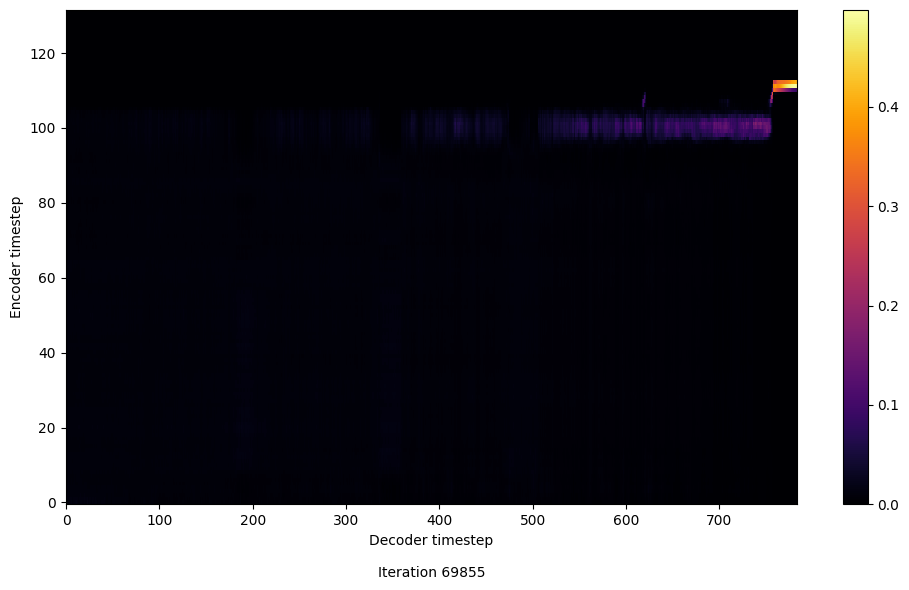

current learning rate :  [0.0001]
Epoch [32/250] completed in 7056.63s

Starting Epoch: 33/250


  0%|          | 1/2183 [00:02<1:39:17,  2.73s/it]

Epoch [33/250], Step [1/2183], Total Loss: 0.535835, Student Loss: 0.814380, Teacher Loss: 0.273170, Distillation Loss: 0.257289, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.72s


  1%|          | 11/2183 [00:29<1:35:38,  2.64s/it]

Epoch [33/250], Step [11/2183], Total Loss: 0.500438, Student Loss: 0.760077, Teacher Loss: 0.232953, Distillation Loss: 0.240800, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.83s


  1%|          | 21/2183 [00:54<1:30:00,  2.50s/it]

Epoch [33/250], Step [21/2183], Total Loss: 0.421639, Student Loss: 0.642599, Teacher Loss: 0.183775, Distillation Loss: 0.200679, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.41s


  1%|▏         | 31/2183 [01:20<1:32:59,  2.59s/it]

Epoch [33/250], Step [31/2183], Total Loss: 0.619710, Student Loss: 0.938136, Teacher Loss: 0.273610, Distillation Loss: 0.301284, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.28s


  2%|▏         | 41/2183 [01:46<1:34:00,  2.63s/it]

Epoch [33/250], Step [41/2183], Total Loss: 0.645903, Student Loss: 0.986964, Teacher Loss: 0.291396, Distillation Loss: 0.304842, Gradient Norm: 1.62, Learning Rate: 0.00010000, Duration: 2.77s


  2%|▏         | 51/2183 [02:13<1:36:28,  2.71s/it]

Epoch [33/250], Step [51/2183], Total Loss: 0.541379, Student Loss: 0.822439, Teacher Loss: 0.264345, Distillation Loss: 0.260319, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.76s


  3%|▎         | 61/2183 [02:39<1:28:07,  2.49s/it]

Epoch [33/250], Step [61/2183], Total Loss: 0.536432, Student Loss: 0.817059, Teacher Loss: 0.265034, Distillation Loss: 0.255804, Gradient Norm: 1.97, Learning Rate: 0.00010000, Duration: 2.12s


  3%|▎         | 71/2183 [03:06<1:34:41,  2.69s/it]

Epoch [33/250], Step [71/2183], Total Loss: 0.599377, Student Loss: 0.911909, Teacher Loss: 0.287322, Distillation Loss: 0.286845, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.77s


  4%|▎         | 81/2183 [03:32<1:32:48,  2.65s/it]

Epoch [33/250], Step [81/2183], Total Loss: 0.689892, Student Loss: 1.056234, Teacher Loss: 0.313135, Distillation Loss: 0.323551, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.60s


  4%|▍         | 91/2183 [03:58<1:28:48,  2.55s/it]

Epoch [33/250], Step [91/2183], Total Loss: 0.662290, Student Loss: 1.013312, Teacher Loss: 0.303316, Distillation Loss: 0.311268, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.41s


  5%|▍         | 101/2183 [04:25<1:34:03,  2.71s/it]

Epoch [33/250], Step [101/2183], Total Loss: 0.552333, Student Loss: 0.842568, Teacher Loss: 0.257789, Distillation Loss: 0.262098, Gradient Norm: 1.52, Learning Rate: 0.00010000, Duration: 2.76s


  5%|▌         | 111/2183 [04:51<1:26:46,  2.51s/it]

Epoch [33/250], Step [111/2183], Total Loss: 0.643890, Student Loss: 0.980473, Teacher Loss: 0.296054, Distillation Loss: 0.307308, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.45s


  6%|▌         | 121/2183 [05:16<1:27:56,  2.56s/it]

Epoch [33/250], Step [121/2183], Total Loss: 0.623271, Student Loss: 0.950236, Teacher Loss: 0.305602, Distillation Loss: 0.296306, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.69s


  6%|▌         | 131/2183 [05:43<1:30:26,  2.64s/it]

Epoch [33/250], Step [131/2183], Total Loss: 0.564410, Student Loss: 0.861427, Teacher Loss: 0.257709, Distillation Loss: 0.267392, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.75s


  6%|▋         | 141/2183 [06:09<1:29:39,  2.63s/it]

Epoch [33/250], Step [141/2183], Total Loss: 0.631658, Student Loss: 0.967092, Teacher Loss: 0.290400, Distillation Loss: 0.296225, Gradient Norm: 2.00, Learning Rate: 0.00010000, Duration: 2.65s


  7%|▋         | 151/2183 [06:34<1:27:20,  2.58s/it]

Epoch [33/250], Step [151/2183], Total Loss: 0.453081, Student Loss: 0.691697, Teacher Loss: 0.220250, Distillation Loss: 0.214466, Gradient Norm: 1.29, Learning Rate: 0.00010000, Duration: 2.93s


  7%|▋         | 161/2183 [07:01<1:28:34,  2.63s/it]

Epoch [33/250], Step [161/2183], Total Loss: 0.564790, Student Loss: 0.862152, Teacher Loss: 0.258190, Distillation Loss: 0.267428, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.60s


  8%|▊         | 171/2183 [07:26<1:27:03,  2.60s/it]

Epoch [33/250], Step [171/2183], Total Loss: 0.535099, Student Loss: 0.818942, Teacher Loss: 0.264547, Distillation Loss: 0.251255, Gradient Norm: 0.61, Learning Rate: 0.00010000, Duration: 2.80s


  8%|▊         | 181/2183 [07:52<1:29:44,  2.69s/it]

Epoch [33/250], Step [181/2183], Total Loss: 0.567465, Student Loss: 0.868086, Teacher Loss: 0.273744, Distillation Loss: 0.266845, Gradient Norm: 0.65, Learning Rate: 0.00010000, Duration: 2.77s


  9%|▊         | 191/2183 [08:18<1:24:48,  2.55s/it]

Epoch [33/250], Step [191/2183], Total Loss: 0.536411, Student Loss: 0.817583, Teacher Loss: 0.249913, Distillation Loss: 0.255238, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.72s


  9%|▉         | 201/2183 [08:43<1:28:39,  2.68s/it]

Epoch [33/250], Step [201/2183], Total Loss: 0.586675, Student Loss: 0.895493, Teacher Loss: 0.265407, Distillation Loss: 0.277858, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.75s


 10%|▉         | 211/2183 [09:09<1:23:15,  2.53s/it]

Epoch [33/250], Step [211/2183], Total Loss: 0.709482, Student Loss: 1.080022, Teacher Loss: 0.296819, Distillation Loss: 0.338943, Gradient Norm: 2.15, Learning Rate: 0.00010000, Duration: 2.22s


 10%|█         | 221/2183 [09:34<1:20:01,  2.45s/it]

Epoch [33/250], Step [221/2183], Total Loss: 0.602714, Student Loss: 0.918017, Teacher Loss: 0.268956, Distillation Loss: 0.287411, Gradient Norm: 1.61, Learning Rate: 0.00010000, Duration: 2.23s


 11%|█         | 231/2183 [10:00<1:26:24,  2.66s/it]

Epoch [33/250], Step [231/2183], Total Loss: 0.618020, Student Loss: 0.938848, Teacher Loss: 0.270184, Distillation Loss: 0.297193, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.67s


 11%|█         | 241/2183 [10:26<1:19:06,  2.44s/it]

Epoch [33/250], Step [241/2183], Total Loss: 0.631109, Student Loss: 0.959553, Teacher Loss: 0.324962, Distillation Loss: 0.302665, Gradient Norm: 1.29, Learning Rate: 0.00010000, Duration: 2.08s


 11%|█▏        | 251/2183 [10:53<1:26:34,  2.69s/it]

Epoch [33/250], Step [251/2183], Total Loss: 0.556421, Student Loss: 0.849185, Teacher Loss: 0.261294, Distillation Loss: 0.263657, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.77s


 12%|█▏        | 261/2183 [11:19<1:26:14,  2.69s/it]

Epoch [33/250], Step [261/2183], Total Loss: 0.523829, Student Loss: 0.801288, Teacher Loss: 0.239446, Distillation Loss: 0.246370, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.82s


 12%|█▏        | 271/2183 [11:45<1:19:07,  2.48s/it]

Epoch [33/250], Step [271/2183], Total Loss: 0.542396, Student Loss: 0.824032, Teacher Loss: 0.238663, Distillation Loss: 0.260759, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.29s


 13%|█▎        | 281/2183 [12:11<1:21:12,  2.56s/it]

Epoch [33/250], Step [281/2183], Total Loss: 0.618312, Student Loss: 0.943734, Teacher Loss: 0.314170, Distillation Loss: 0.292889, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.59s


 13%|█▎        | 291/2183 [12:36<1:19:43,  2.53s/it]

Epoch [33/250], Step [291/2183], Total Loss: 0.560448, Student Loss: 0.852729, Teacher Loss: 0.247777, Distillation Loss: 0.268167, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.41s


 14%|█▍        | 301/2183 [13:01<1:19:51,  2.55s/it]

Epoch [33/250], Step [301/2183], Total Loss: 0.587153, Student Loss: 0.896741, Teacher Loss: 0.271786, Distillation Loss: 0.277565, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.48s


 14%|█▍        | 311/2183 [13:27<1:26:40,  2.78s/it]

Epoch [33/250], Step [311/2183], Total Loss: 0.646977, Student Loss: 0.988649, Teacher Loss: 0.309745, Distillation Loss: 0.305306, Gradient Norm: 1.67, Learning Rate: 0.00010000, Duration: 3.06s


 15%|█▍        | 321/2183 [13:53<1:19:22,  2.56s/it]

Epoch [33/250], Step [321/2183], Total Loss: 0.558699, Student Loss: 0.852722, Teacher Loss: 0.242839, Distillation Loss: 0.264676, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.48s


 15%|█▌        | 331/2183 [14:18<1:22:20,  2.67s/it]

Epoch [33/250], Step [331/2183], Total Loss: 0.543353, Student Loss: 0.832506, Teacher Loss: 0.264559, Distillation Loss: 0.254200, Gradient Norm: 1.48, Learning Rate: 0.00010000, Duration: 2.79s


 16%|█▌        | 341/2183 [14:45<1:20:03,  2.61s/it]

Epoch [33/250], Step [341/2183], Total Loss: 0.551506, Student Loss: 0.840633, Teacher Loss: 0.259437, Distillation Loss: 0.262378, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.49s


 16%|█▌        | 351/2183 [15:12<1:23:26,  2.73s/it]

Epoch [33/250], Step [351/2183], Total Loss: 0.480612, Student Loss: 0.730608, Teacher Loss: 0.213387, Distillation Loss: 0.230615, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.68s


 17%|█▋        | 361/2183 [15:38<1:18:37,  2.59s/it]

Epoch [33/250], Step [361/2183], Total Loss: 0.654436, Student Loss: 0.996817, Teacher Loss: 0.333655, Distillation Loss: 0.312055, Gradient Norm: 1.17, Learning Rate: 0.00010000, Duration: 2.23s


 17%|█▋        | 371/2183 [16:03<1:16:32,  2.53s/it]

Epoch [33/250], Step [371/2183], Total Loss: 0.472798, Student Loss: 0.719696, Teacher Loss: 0.215968, Distillation Loss: 0.225899, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.56s


 17%|█▋        | 381/2183 [16:29<1:20:56,  2.70s/it]

Epoch [33/250], Step [381/2183], Total Loss: 0.448742, Student Loss: 0.680964, Teacher Loss: 0.208972, Distillation Loss: 0.216521, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.85s


 18%|█▊        | 391/2183 [16:55<1:15:35,  2.53s/it]

Epoch [33/250], Step [391/2183], Total Loss: 0.525567, Student Loss: 0.795238, Teacher Loss: 0.229426, Distillation Loss: 0.255896, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.61s


 18%|█▊        | 401/2183 [17:21<1:22:21,  2.77s/it]

Epoch [33/250], Step [401/2183], Total Loss: 0.515244, Student Loss: 0.787596, Teacher Loss: 0.232829, Distillation Loss: 0.242891, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 3.15s


 19%|█▉        | 411/2183 [17:46<1:15:24,  2.55s/it]

Epoch [33/250], Step [411/2183], Total Loss: 0.437304, Student Loss: 0.662288, Teacher Loss: 0.226545, Distillation Loss: 0.212319, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 2.70s


 19%|█▉        | 421/2183 [18:12<1:14:03,  2.52s/it]

Epoch [33/250], Step [421/2183], Total Loss: 0.527344, Student Loss: 0.802760, Teacher Loss: 0.210524, Distillation Loss: 0.251929, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.30s


 20%|█▉        | 431/2183 [18:39<1:16:49,  2.63s/it]

Epoch [33/250], Step [431/2183], Total Loss: 0.548110, Student Loss: 0.833484, Teacher Loss: 0.279385, Distillation Loss: 0.262735, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.40s


 20%|██        | 441/2183 [19:05<1:17:54,  2.68s/it]

Epoch [33/250], Step [441/2183], Total Loss: 0.512498, Student Loss: 0.784879, Teacher Loss: 0.244373, Distillation Loss: 0.240118, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.84s


 21%|██        | 451/2183 [19:32<1:10:54,  2.46s/it]

Epoch [33/250], Step [451/2183], Total Loss: 0.550787, Student Loss: 0.841665, Teacher Loss: 0.304154, Distillation Loss: 0.259909, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.07s


 21%|██        | 461/2183 [19:59<1:17:46,  2.71s/it]

Epoch [33/250], Step [461/2183], Total Loss: 0.577528, Student Loss: 0.881968, Teacher Loss: 0.268977, Distillation Loss: 0.273088, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.68s


 22%|██▏       | 471/2183 [20:25<1:13:35,  2.58s/it]

Epoch [33/250], Step [471/2183], Total Loss: 0.494053, Student Loss: 0.756780, Teacher Loss: 0.242522, Distillation Loss: 0.231325, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.62s


 22%|██▏       | 481/2183 [20:51<1:11:41,  2.53s/it]

Epoch [33/250], Step [481/2183], Total Loss: 0.430158, Student Loss: 0.654936, Teacher Loss: 0.201095, Distillation Loss: 0.205381, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.62s


 22%|██▏       | 491/2183 [21:16<1:13:12,  2.60s/it]

Epoch [33/250], Step [491/2183], Total Loss: 0.468335, Student Loss: 0.711258, Teacher Loss: 0.217747, Distillation Loss: 0.225412, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.75s


 23%|██▎       | 501/2183 [21:41<1:09:22,  2.47s/it]

Epoch [33/250], Step [501/2183], Total Loss: 0.575584, Student Loss: 0.877883, Teacher Loss: 0.275335, Distillation Loss: 0.273285, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.76s


 23%|██▎       | 511/2183 [22:07<1:08:40,  2.46s/it]

Epoch [33/250], Step [511/2183], Total Loss: 0.593101, Student Loss: 0.906509, Teacher Loss: 0.267648, Distillation Loss: 0.279694, Gradient Norm: 1.29, Learning Rate: 0.00010000, Duration: 2.33s


 24%|██▍       | 521/2183 [22:32<1:11:00,  2.56s/it]

Epoch [33/250], Step [521/2183], Total Loss: 0.461012, Student Loss: 0.706469, Teacher Loss: 0.226727, Distillation Loss: 0.215554, Gradient Norm: 0.68, Learning Rate: 0.00010000, Duration: 2.72s


 24%|██▍       | 531/2183 [22:58<1:13:59,  2.69s/it]

Epoch [33/250], Step [531/2183], Total Loss: 0.558095, Student Loss: 0.851732, Teacher Loss: 0.268356, Distillation Loss: 0.264457, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.84s


 25%|██▍       | 541/2183 [23:25<1:13:25,  2.68s/it]

Epoch [33/250], Step [541/2183], Total Loss: 0.615786, Student Loss: 0.934306, Teacher Loss: 0.318848, Distillation Loss: 0.297266, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.51s


 25%|██▌       | 551/2183 [23:51<1:13:14,  2.69s/it]

Epoch [33/250], Step [551/2183], Total Loss: 0.552043, Student Loss: 0.840900, Teacher Loss: 0.264821, Distillation Loss: 0.263186, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.74s


 26%|██▌       | 561/2183 [24:17<1:08:47,  2.54s/it]

Epoch [33/250], Step [561/2183], Total Loss: 0.648810, Student Loss: 0.991578, Teacher Loss: 0.314499, Distillation Loss: 0.306041, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.28s


 26%|██▌       | 571/2183 [24:43<1:09:51,  2.60s/it]

Epoch [33/250], Step [571/2183], Total Loss: 0.593103, Student Loss: 0.908058, Teacher Loss: 0.271157, Distillation Loss: 0.278149, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.68s


 27%|██▋       | 581/2183 [25:09<1:07:35,  2.53s/it]

Epoch [33/250], Step [581/2183], Total Loss: 0.467518, Student Loss: 0.712429, Teacher Loss: 0.214150, Distillation Loss: 0.222607, Gradient Norm: 0.66, Learning Rate: 0.00010000, Duration: 2.43s


 27%|██▋       | 591/2183 [25:35<1:06:45,  2.52s/it]

Epoch [33/250], Step [591/2183], Total Loss: 0.610308, Student Loss: 0.928060, Teacher Loss: 0.312497, Distillation Loss: 0.292556, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.00s


 28%|██▊       | 601/2183 [26:00<1:06:12,  2.51s/it]

Epoch [33/250], Step [601/2183], Total Loss: 0.513606, Student Loss: 0.785605, Teacher Loss: 0.234600, Distillation Loss: 0.241608, Gradient Norm: 0.73, Learning Rate: 0.00010000, Duration: 2.15s


 28%|██▊       | 611/2183 [26:25<1:07:53,  2.59s/it]

Epoch [33/250], Step [611/2183], Total Loss: 0.568475, Student Loss: 0.864248, Teacher Loss: 0.271171, Distillation Loss: 0.272701, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.58s


 28%|██▊       | 621/2183 [26:52<1:10:10,  2.70s/it]

Epoch [33/250], Step [621/2183], Total Loss: 0.562901, Student Loss: 0.859582, Teacher Loss: 0.270413, Distillation Loss: 0.266221, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.77s


 29%|██▉       | 631/2183 [27:18<1:08:10,  2.64s/it]

Epoch [33/250], Step [631/2183], Total Loss: 0.543025, Student Loss: 0.831279, Teacher Loss: 0.262048, Distillation Loss: 0.254771, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.75s


 29%|██▉       | 641/2183 [27:44<1:08:19,  2.66s/it]

Epoch [33/250], Step [641/2183], Total Loss: 0.567097, Student Loss: 0.860485, Teacher Loss: 0.250592, Distillation Loss: 0.273710, Gradient Norm: 1.69, Learning Rate: 0.00010000, Duration: 2.66s


 30%|██▉       | 651/2183 [28:10<1:04:46,  2.54s/it]

Epoch [33/250], Step [651/2183], Total Loss: 0.571784, Student Loss: 0.870520, Teacher Loss: 0.261832, Distillation Loss: 0.273048, Gradient Norm: 1.61, Learning Rate: 0.00010000, Duration: 2.78s


 30%|███       | 661/2183 [28:36<1:03:07,  2.49s/it]

Epoch [33/250], Step [661/2183], Total Loss: 0.627185, Student Loss: 0.949885, Teacher Loss: 0.318648, Distillation Loss: 0.304486, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 2.20s


 31%|███       | 671/2183 [29:02<1:06:46,  2.65s/it]

Epoch [33/250], Step [671/2183], Total Loss: 0.502621, Student Loss: 0.766040, Teacher Loss: 0.250657, Distillation Loss: 0.239201, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.49s


 31%|███       | 681/2183 [29:28<1:05:29,  2.62s/it]

Epoch [33/250], Step [681/2183], Total Loss: 0.637891, Student Loss: 0.974204, Teacher Loss: 0.298071, Distillation Loss: 0.301578, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.47s


 32%|███▏      | 691/2183 [29:54<1:04:29,  2.59s/it]

Epoch [33/250], Step [691/2183], Total Loss: 0.458108, Student Loss: 0.698291, Teacher Loss: 0.217261, Distillation Loss: 0.217925, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.73s


 32%|███▏      | 701/2183 [30:19<1:04:39,  2.62s/it]

Epoch [33/250], Step [701/2183], Total Loss: 0.624282, Student Loss: 0.953418, Teacher Loss: 0.286657, Distillation Loss: 0.295147, Gradient Norm: 1.98, Learning Rate: 0.00010000, Duration: 2.69s


 33%|███▎      | 711/2183 [30:44<1:00:30,  2.47s/it]

Epoch [33/250], Step [711/2183], Total Loss: 0.527619, Student Loss: 0.807077, Teacher Loss: 0.261201, Distillation Loss: 0.248161, Gradient Norm: 1.89, Learning Rate: 0.00010000, Duration: 2.18s


 33%|███▎      | 721/2183 [31:11<1:05:12,  2.68s/it]

Epoch [33/250], Step [721/2183], Total Loss: 0.624429, Student Loss: 0.957514, Teacher Loss: 0.367648, Distillation Loss: 0.291344, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.75s


 33%|███▎      | 731/2183 [31:37<1:01:18,  2.53s/it]

Epoch [33/250], Step [731/2183], Total Loss: 0.479547, Student Loss: 0.730638, Teacher Loss: 0.250751, Distillation Loss: 0.228456, Gradient Norm: 1.65, Learning Rate: 0.00010000, Duration: 2.41s


 34%|███▍      | 741/2183 [32:04<1:02:58,  2.62s/it]

Epoch [33/250], Step [741/2183], Total Loss: 0.574462, Student Loss: 0.873810, Teacher Loss: 0.260505, Distillation Loss: 0.275114, Gradient Norm: 1.56, Learning Rate: 0.00010000, Duration: 2.60s


 34%|███▍      | 751/2183 [32:29<1:02:57,  2.64s/it]

Epoch [33/250], Step [751/2183], Total Loss: 0.437981, Student Loss: 0.667256, Teacher Loss: 0.220039, Distillation Loss: 0.208706, Gradient Norm: 0.75, Learning Rate: 0.00010000, Duration: 2.53s


 35%|███▍      | 761/2183 [32:57<1:06:13,  2.79s/it]

Epoch [33/250], Step [761/2183], Total Loss: 0.512122, Student Loss: 0.781671, Teacher Loss: 0.254964, Distillation Loss: 0.242573, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 3.21s


 35%|███▌      | 771/2183 [33:23<1:02:14,  2.64s/it]

Epoch [33/250], Step [771/2183], Total Loss: 0.501033, Student Loss: 0.765511, Teacher Loss: 0.223540, Distillation Loss: 0.236555, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.53s


 36%|███▌      | 781/2183 [33:48<1:01:48,  2.64s/it]

Epoch [33/250], Step [781/2183], Total Loss: 0.558292, Student Loss: 0.847944, Teacher Loss: 0.261404, Distillation Loss: 0.268641, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.86s


 36%|███▌      | 791/2183 [34:13<59:46,  2.58s/it]  

Epoch [33/250], Step [791/2183], Total Loss: 0.626619, Student Loss: 0.951370, Teacher Loss: 0.274563, Distillation Loss: 0.301869, Gradient Norm: 1.64, Learning Rate: 0.00010000, Duration: 2.77s


 37%|███▋      | 801/2183 [34:39<1:01:04,  2.65s/it]

Epoch [33/250], Step [801/2183], Total Loss: 0.503089, Student Loss: 0.769949, Teacher Loss: 0.232505, Distillation Loss: 0.236228, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.57s


 37%|███▋      | 811/2183 [35:05<57:40,  2.52s/it]  

Epoch [33/250], Step [811/2183], Total Loss: 0.489156, Student Loss: 0.743717, Teacher Loss: 0.228169, Distillation Loss: 0.234594, Gradient Norm: 1.78, Learning Rate: 0.00010000, Duration: 2.61s


 38%|███▊      | 821/2183 [35:31<1:00:06,  2.65s/it]

Epoch [33/250], Step [821/2183], Total Loss: 0.557777, Student Loss: 0.847258, Teacher Loss: 0.264187, Distillation Loss: 0.268297, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.44s


 38%|███▊      | 831/2183 [35:57<57:58,  2.57s/it]  

Epoch [33/250], Step [831/2183], Total Loss: 0.643583, Student Loss: 0.975248, Teacher Loss: 0.332188, Distillation Loss: 0.311917, Gradient Norm: 2.52, Learning Rate: 0.00010000, Duration: 2.37s


 39%|███▊      | 841/2183 [36:24<59:45,  2.67s/it]

Epoch [33/250], Step [841/2183], Total Loss: 0.515017, Student Loss: 0.789889, Teacher Loss: 0.260490, Distillation Loss: 0.240145, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.76s


 39%|███▉      | 851/2183 [36:50<57:08,  2.57s/it]  

Epoch [33/250], Step [851/2183], Total Loss: 0.482677, Student Loss: 0.738351, Teacher Loss: 0.220332, Distillation Loss: 0.227003, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.63s


 39%|███▉      | 861/2183 [37:16<56:49,  2.58s/it]

Epoch [33/250], Step [861/2183], Total Loss: 0.513715, Student Loss: 0.782601, Teacher Loss: 0.228398, Distillation Loss: 0.244829, Gradient Norm: 2.58, Learning Rate: 0.00010000, Duration: 2.54s


 40%|███▉      | 871/2183 [37:42<58:23,  2.67s/it]  

Epoch [33/250], Step [871/2183], Total Loss: 0.564681, Student Loss: 0.863046, Teacher Loss: 0.259525, Distillation Loss: 0.266316, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.78s


 40%|████      | 881/2183 [38:06<53:08,  2.45s/it]

Epoch [33/250], Step [881/2183], Total Loss: 0.521993, Student Loss: 0.795828, Teacher Loss: 0.254586, Distillation Loss: 0.248158, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.71s


 41%|████      | 891/2183 [38:31<54:27,  2.53s/it]

Epoch [33/250], Step [891/2183], Total Loss: 0.563262, Student Loss: 0.855535, Teacher Loss: 0.244312, Distillation Loss: 0.270988, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.69s


 41%|████▏     | 901/2183 [38:58<56:49,  2.66s/it]

Epoch [33/250], Step [901/2183], Total Loss: 0.617374, Student Loss: 0.945344, Teacher Loss: 0.282601, Distillation Loss: 0.289403, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.63s


 42%|████▏     | 911/2183 [39:23<53:00,  2.50s/it]

Epoch [33/250], Step [911/2183], Total Loss: 0.514196, Student Loss: 0.784893, Teacher Loss: 0.247912, Distillation Loss: 0.243499, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.64s


 42%|████▏     | 921/2183 [39:47<50:16,  2.39s/it]

Epoch [33/250], Step [921/2183], Total Loss: 0.591279, Student Loss: 0.901888, Teacher Loss: 0.272547, Distillation Loss: 0.280669, Gradient Norm: 1.75, Learning Rate: 0.00010000, Duration: 2.50s


 43%|████▎     | 931/2183 [40:12<50:48,  2.43s/it]

Epoch [33/250], Step [931/2183], Total Loss: 0.566961, Student Loss: 0.864048, Teacher Loss: 0.263661, Distillation Loss: 0.269873, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.06s


 43%|████▎     | 941/2183 [40:38<54:47,  2.65s/it]

Epoch [33/250], Step [941/2183], Total Loss: 0.557535, Student Loss: 0.846780, Teacher Loss: 0.244803, Distillation Loss: 0.268291, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.84s


 44%|████▎     | 951/2183 [41:05<55:50,  2.72s/it]

Epoch [33/250], Step [951/2183], Total Loss: 0.440192, Student Loss: 0.666252, Teacher Loss: 0.201375, Distillation Loss: 0.214131, Gradient Norm: 1.64, Learning Rate: 0.00010000, Duration: 2.46s


 44%|████▍     | 961/2183 [41:33<56:50,  2.79s/it]

Epoch [33/250], Step [961/2183], Total Loss: 0.544570, Student Loss: 0.827901, Teacher Loss: 0.245025, Distillation Loss: 0.261238, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.82s


 44%|████▍     | 971/2183 [41:58<50:44,  2.51s/it]

Epoch [33/250], Step [971/2183], Total Loss: 0.616143, Student Loss: 0.942960, Teacher Loss: 0.274553, Distillation Loss: 0.289326, Gradient Norm: 1.42, Learning Rate: 0.00010000, Duration: 2.16s


 45%|████▍     | 981/2183 [42:24<50:00,  2.50s/it]

Epoch [33/250], Step [981/2183], Total Loss: 0.595948, Student Loss: 0.908760, Teacher Loss: 0.285626, Distillation Loss: 0.283136, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.11s


 45%|████▌     | 991/2183 [42:51<53:50,  2.71s/it]

Epoch [33/250], Step [991/2183], Total Loss: 0.571233, Student Loss: 0.874587, Teacher Loss: 0.257342, Distillation Loss: 0.267879, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.80s


 46%|████▌     | 1001/2183 [43:16<50:11,  2.55s/it]

Epoch [33/250], Step [1001/2183], Total Loss: 0.592186, Student Loss: 0.904028, Teacher Loss: 0.283763, Distillation Loss: 0.280343, Gradient Norm: 1.89, Learning Rate: 0.00010000, Duration: 2.53s


 46%|████▋     | 1011/2183 [43:42<50:55,  2.61s/it]

Epoch [33/250], Step [1011/2183], Total Loss: 0.573690, Student Loss: 0.872539, Teacher Loss: 0.285826, Distillation Loss: 0.274840, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.51s


 47%|████▋     | 1021/2183 [44:07<49:35,  2.56s/it]

Epoch [33/250], Step [1021/2183], Total Loss: 0.524522, Student Loss: 0.799690, Teacher Loss: 0.243839, Distillation Loss: 0.249354, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.78s


 47%|████▋     | 1031/2183 [44:33<50:42,  2.64s/it]

Epoch [33/250], Step [1031/2183], Total Loss: 0.564105, Student Loss: 0.862345, Teacher Loss: 0.262019, Distillation Loss: 0.265865, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.75s


 48%|████▊     | 1041/2183 [45:00<50:56,  2.68s/it]

Epoch [33/250], Step [1041/2183], Total Loss: 0.454456, Student Loss: 0.692599, Teacher Loss: 0.205671, Distillation Loss: 0.216313, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.67s


 48%|████▊     | 1051/2183 [45:26<48:23,  2.57s/it]

Epoch [33/250], Step [1051/2183], Total Loss: 0.622679, Student Loss: 0.952158, Teacher Loss: 0.310607, Distillation Loss: 0.293200, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.36s


 49%|████▊     | 1061/2183 [45:53<50:51,  2.72s/it]

Epoch [33/250], Step [1061/2183], Total Loss: 0.490977, Student Loss: 0.749718, Teacher Loss: 0.232081, Distillation Loss: 0.232235, Gradient Norm: 0.67, Learning Rate: 0.00010000, Duration: 2.75s


 49%|████▉     | 1071/2183 [46:20<50:40,  2.73s/it]

Epoch [33/250], Step [1071/2183], Total Loss: 0.514453, Student Loss: 0.787429, Teacher Loss: 0.248275, Distillation Loss: 0.241478, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.73s


 50%|████▉     | 1081/2183 [46:45<45:02,  2.45s/it]

Epoch [33/250], Step [1081/2183], Total Loss: 0.520967, Student Loss: 0.796067, Teacher Loss: 0.241292, Distillation Loss: 0.245868, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.56s


 50%|████▉     | 1091/2183 [47:11<46:50,  2.57s/it]

Epoch [33/250], Step [1091/2183], Total Loss: 0.509827, Student Loss: 0.774872, Teacher Loss: 0.246020, Distillation Loss: 0.244783, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.35s


 50%|█████     | 1101/2183 [47:38<48:02,  2.66s/it]

Epoch [33/250], Step [1101/2183], Total Loss: 0.548839, Student Loss: 0.840424, Teacher Loss: 0.248376, Distillation Loss: 0.257255, Gradient Norm: 1.65, Learning Rate: 0.00010000, Duration: 2.57s


 51%|█████     | 1111/2183 [48:03<47:02,  2.63s/it]

Epoch [33/250], Step [1111/2183], Total Loss: 0.544632, Student Loss: 0.827520, Teacher Loss: 0.230405, Distillation Loss: 0.261743, Gradient Norm: 1.59, Learning Rate: 0.00010000, Duration: 2.80s


 51%|█████▏    | 1121/2183 [48:29<46:18,  2.62s/it]

Epoch [33/250], Step [1121/2183], Total Loss: 0.586550, Student Loss: 0.889025, Teacher Loss: 0.284773, Distillation Loss: 0.284074, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.43s


 52%|█████▏    | 1131/2183 [48:56<47:35,  2.71s/it]

Epoch [33/250], Step [1131/2183], Total Loss: 0.567387, Student Loss: 0.864135, Teacher Loss: 0.314469, Distillation Loss: 0.270639, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.75s


 52%|█████▏    | 1141/2183 [49:21<43:12,  2.49s/it]

Epoch [33/250], Step [1141/2183], Total Loss: 0.658337, Student Loss: 0.999909, Teacher Loss: 0.278983, Distillation Loss: 0.316765, Gradient Norm: 1.80, Learning Rate: 0.00010000, Duration: 2.58s


 53%|█████▎    | 1151/2183 [49:47<43:39,  2.54s/it]

Epoch [33/250], Step [1151/2183], Total Loss: 0.544814, Student Loss: 0.831241, Teacher Loss: 0.236817, Distillation Loss: 0.258388, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.22s


 53%|█████▎    | 1161/2183 [50:13<46:00,  2.70s/it]

Epoch [33/250], Step [1161/2183], Total Loss: 0.544828, Student Loss: 0.824713, Teacher Loss: 0.286950, Distillation Loss: 0.264943, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.80s


 54%|█████▎    | 1171/2183 [50:39<45:31,  2.70s/it]

Epoch [33/250], Step [1171/2183], Total Loss: 0.541735, Student Loss: 0.825545, Teacher Loss: 0.248937, Distillation Loss: 0.257924, Gradient Norm: 2.05, Learning Rate: 0.00010000, Duration: 2.79s


 54%|█████▍    | 1181/2183 [51:04<42:52,  2.57s/it]

Epoch [33/250], Step [1181/2183], Total Loss: 0.655444, Student Loss: 1.001885, Teacher Loss: 0.294966, Distillation Loss: 0.309004, Gradient Norm: 2.14, Learning Rate: 0.00010000, Duration: 2.78s


 55%|█████▍    | 1191/2183 [51:29<40:11,  2.43s/it]

Epoch [33/250], Step [1191/2183], Total Loss: 0.521112, Student Loss: 0.793041, Teacher Loss: 0.240311, Distillation Loss: 0.249183, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.50s


 55%|█████▌    | 1201/2183 [51:56<44:42,  2.73s/it]

Epoch [33/250], Step [1201/2183], Total Loss: 0.549109, Student Loss: 0.835941, Teacher Loss: 0.266063, Distillation Loss: 0.262277, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.69s


 55%|█████▌    | 1211/2183 [52:22<43:01,  2.66s/it]

Epoch [33/250], Step [1211/2183], Total Loss: 0.497515, Student Loss: 0.761764, Teacher Loss: 0.240835, Distillation Loss: 0.233266, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.62s


 56%|█████▌    | 1221/2183 [52:48<42:41,  2.66s/it]

Epoch [33/250], Step [1221/2183], Total Loss: 0.553874, Student Loss: 0.840482, Teacher Loss: 0.272999, Distillation Loss: 0.267265, Gradient Norm: 1.74, Learning Rate: 0.00010000, Duration: 2.70s


 56%|█████▋    | 1231/2183 [53:16<45:22,  2.86s/it]

Epoch [33/250], Step [1231/2183], Total Loss: 0.579146, Student Loss: 0.883926, Teacher Loss: 0.273238, Distillation Loss: 0.274365, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.95s


 57%|█████▋    | 1241/2183 [53:41<40:40,  2.59s/it]

Epoch [33/250], Step [1241/2183], Total Loss: 0.512060, Student Loss: 0.782651, Teacher Loss: 0.244871, Distillation Loss: 0.241470, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.52s


 57%|█████▋    | 1251/2183 [54:08<42:56,  2.76s/it]

Epoch [33/250], Step [1251/2183], Total Loss: 0.571275, Student Loss: 0.873868, Teacher Loss: 0.270374, Distillation Loss: 0.268682, Gradient Norm: 1.51, Learning Rate: 0.00010000, Duration: 2.82s


 58%|█████▊    | 1261/2183 [54:35<40:21,  2.63s/it]

Epoch [33/250], Step [1261/2183], Total Loss: 0.632086, Student Loss: 0.970117, Teacher Loss: 0.296012, Distillation Loss: 0.294056, Gradient Norm: 0.83, Learning Rate: 0.00010000, Duration: 2.34s


 58%|█████▊    | 1271/2183 [55:01<41:36,  2.74s/it]

Epoch [33/250], Step [1271/2183], Total Loss: 0.554687, Student Loss: 0.850928, Teacher Loss: 0.275981, Distillation Loss: 0.258446, Gradient Norm: 2.47, Learning Rate: 0.00010000, Duration: 2.83s


 59%|█████▊    | 1281/2183 [55:28<42:19,  2.82s/it]

Epoch [33/250], Step [1281/2183], Total Loss: 0.617018, Student Loss: 0.938350, Teacher Loss: 0.294176, Distillation Loss: 0.295686, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.88s


 59%|█████▉    | 1291/2183 [55:55<40:02,  2.69s/it]

Epoch [33/250], Step [1291/2183], Total Loss: 0.597442, Student Loss: 0.911650, Teacher Loss: 0.270785, Distillation Loss: 0.283234, Gradient Norm: 1.96, Learning Rate: 0.00010000, Duration: 2.58s


 60%|█████▉    | 1301/2183 [56:20<38:11,  2.60s/it]

Epoch [33/250], Step [1301/2183], Total Loss: 0.610323, Student Loss: 0.928789, Teacher Loss: 0.299439, Distillation Loss: 0.291858, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.77s


 60%|██████    | 1311/2183 [56:46<38:16,  2.63s/it]

Epoch [33/250], Step [1311/2183], Total Loss: 0.512377, Student Loss: 0.775647, Teacher Loss: 0.244461, Distillation Loss: 0.249107, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.71s


 61%|██████    | 1321/2183 [57:11<36:41,  2.55s/it]

Epoch [33/250], Step [1321/2183], Total Loss: 0.580704, Student Loss: 0.885037, Teacher Loss: 0.274272, Distillation Loss: 0.276371, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.64s


 61%|██████    | 1331/2183 [57:38<36:14,  2.55s/it]

Epoch [33/250], Step [1331/2183], Total Loss: 0.521944, Student Loss: 0.796126, Teacher Loss: 0.247539, Distillation Loss: 0.247761, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.37s


 61%|██████▏   | 1341/2183 [58:05<37:20,  2.66s/it]

Epoch [33/250], Step [1341/2183], Total Loss: 0.547037, Student Loss: 0.831060, Teacher Loss: 0.251155, Distillation Loss: 0.263014, Gradient Norm: 1.80, Learning Rate: 0.00010000, Duration: 2.52s


 62%|██████▏   | 1351/2183 [58:31<36:41,  2.65s/it]

Epoch [33/250], Step [1351/2183], Total Loss: 0.576474, Student Loss: 0.881227, Teacher Loss: 0.270805, Distillation Loss: 0.271722, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.58s


 62%|██████▏   | 1361/2183 [58:58<36:17,  2.65s/it]

Epoch [33/250], Step [1361/2183], Total Loss: 0.474277, Student Loss: 0.721135, Teacher Loss: 0.220605, Distillation Loss: 0.227419, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.72s


 63%|██████▎   | 1371/2183 [59:24<34:47,  2.57s/it]

Epoch [33/250], Step [1371/2183], Total Loss: 0.481364, Student Loss: 0.736470, Teacher Loss: 0.229501, Distillation Loss: 0.226257, Gradient Norm: 0.68, Learning Rate: 0.00010000, Duration: 2.61s


 63%|██████▎   | 1381/2183 [59:49<34:34,  2.59s/it]

Epoch [33/250], Step [1381/2183], Total Loss: 0.636142, Student Loss: 0.971285, Teacher Loss: 0.305521, Distillation Loss: 0.301000, Gradient Norm: 1.74, Learning Rate: 0.00010000, Duration: 2.76s


 64%|██████▎   | 1391/2183 [1:00:16<35:17,  2.67s/it]

Epoch [33/250], Step [1391/2183], Total Loss: 0.519892, Student Loss: 0.795592, Teacher Loss: 0.246516, Distillation Loss: 0.244192, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.69s


 64%|██████▍   | 1401/2183 [1:00:43<34:24,  2.64s/it]

Epoch [33/250], Step [1401/2183], Total Loss: 0.458317, Student Loss: 0.699234, Teacher Loss: 0.213554, Distillation Loss: 0.217400, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.65s


 65%|██████▍   | 1411/2183 [1:01:08<33:23,  2.59s/it]

Epoch [33/250], Step [1411/2183], Total Loss: 0.593181, Student Loss: 0.905033, Teacher Loss: 0.261800, Distillation Loss: 0.281329, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 3.09s


 65%|██████▌   | 1421/2183 [1:01:35<34:26,  2.71s/it]

Epoch [33/250], Step [1421/2183], Total Loss: 0.656040, Student Loss: 0.996555, Teacher Loss: 0.280844, Distillation Loss: 0.315525, Gradient Norm: 2.60, Learning Rate: 0.00010000, Duration: 2.76s


 66%|██████▌   | 1431/2183 [1:02:01<33:31,  2.68s/it]

Epoch [33/250], Step [1431/2183], Total Loss: 0.684893, Student Loss: 1.044589, Teacher Loss: 0.334933, Distillation Loss: 0.325196, Gradient Norm: 1.86, Learning Rate: 0.00010000, Duration: 2.70s


 66%|██████▌   | 1441/2183 [1:02:26<31:23,  2.54s/it]

Epoch [33/250], Step [1441/2183], Total Loss: 0.664803, Student Loss: 1.020050, Teacher Loss: 0.335573, Distillation Loss: 0.309555, Gradient Norm: 1.52, Learning Rate: 0.00010000, Duration: 2.25s


 66%|██████▋   | 1451/2183 [1:02:52<31:15,  2.56s/it]

Epoch [33/250], Step [1451/2183], Total Loss: 0.554467, Student Loss: 0.850000, Teacher Loss: 0.263364, Distillation Loss: 0.258934, Gradient Norm: 1.77, Learning Rate: 0.00010000, Duration: 2.42s


 67%|██████▋   | 1461/2183 [1:03:19<32:03,  2.66s/it]

Epoch [33/250], Step [1461/2183], Total Loss: 0.501236, Student Loss: 0.767020, Teacher Loss: 0.243533, Distillation Loss: 0.235452, Gradient Norm: 1.43, Learning Rate: 0.00010000, Duration: 2.78s


 67%|██████▋   | 1471/2183 [1:03:47<33:20,  2.81s/it]

Epoch [33/250], Step [1471/2183], Total Loss: 0.549339, Student Loss: 0.837783, Teacher Loss: 0.282528, Distillation Loss: 0.260895, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.88s


 68%|██████▊   | 1481/2183 [1:04:12<30:36,  2.62s/it]

Epoch [33/250], Step [1481/2183], Total Loss: 0.593139, Student Loss: 0.907106, Teacher Loss: 0.270638, Distillation Loss: 0.279173, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.63s


 68%|██████▊   | 1491/2183 [1:04:38<28:58,  2.51s/it]

Epoch [33/250], Step [1491/2183], Total Loss: 0.481258, Student Loss: 0.732711, Teacher Loss: 0.206702, Distillation Loss: 0.229804, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.63s


 69%|██████▉   | 1501/2183 [1:05:04<29:24,  2.59s/it]

Epoch [33/250], Step [1501/2183], Total Loss: 0.640655, Student Loss: 0.981274, Teacher Loss: 0.314936, Distillation Loss: 0.300037, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.60s


 69%|██████▉   | 1511/2183 [1:05:30<29:50,  2.66s/it]

Epoch [33/250], Step [1511/2183], Total Loss: 0.550032, Student Loss: 0.838547, Teacher Loss: 0.253345, Distillation Loss: 0.261517, Gradient Norm: 1.68, Learning Rate: 0.00010000, Duration: 2.80s


 70%|██████▉   | 1521/2183 [1:05:57<29:33,  2.68s/it]

Epoch [33/250], Step [1521/2183], Total Loss: 0.631145, Student Loss: 0.959828, Teacher Loss: 0.288016, Distillation Loss: 0.302462, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.30s


 70%|███████   | 1531/2183 [1:06:22<29:08,  2.68s/it]

Epoch [33/250], Step [1531/2183], Total Loss: 0.707658, Student Loss: 1.077254, Teacher Loss: 0.329993, Distillation Loss: 0.338062, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.73s


 71%|███████   | 1541/2183 [1:06:49<28:40,  2.68s/it]

Epoch [33/250], Step [1541/2183], Total Loss: 0.555046, Student Loss: 0.849235, Teacher Loss: 0.264881, Distillation Loss: 0.260857, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.76s


 71%|███████   | 1551/2183 [1:07:15<26:10,  2.48s/it]

Epoch [33/250], Step [1551/2183], Total Loss: 0.637777, Student Loss: 0.972199, Teacher Loss: 0.290168, Distillation Loss: 0.303355, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.31s


 72%|███████▏  | 1561/2183 [1:07:41<24:58,  2.41s/it]

Epoch [33/250], Step [1561/2183], Total Loss: 0.595717, Student Loss: 0.911175, Teacher Loss: 0.273312, Distillation Loss: 0.280259, Gradient Norm: 1.47, Learning Rate: 0.00010000, Duration: 1.89s


 72%|███████▏  | 1571/2183 [1:08:07<27:30,  2.70s/it]

Epoch [33/250], Step [1571/2183], Total Loss: 0.608425, Student Loss: 0.929036, Teacher Loss: 0.286159, Distillation Loss: 0.287814, Gradient Norm: 2.51, Learning Rate: 0.00010000, Duration: 2.74s


 72%|███████▏  | 1581/2183 [1:08:33<26:42,  2.66s/it]

Epoch [33/250], Step [1581/2183], Total Loss: 0.587526, Student Loss: 0.898322, Teacher Loss: 0.273268, Distillation Loss: 0.276731, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.81s


 73%|███████▎  | 1591/2183 [1:08:58<25:30,  2.59s/it]

Epoch [33/250], Step [1591/2183], Total Loss: 0.531605, Student Loss: 0.808922, Teacher Loss: 0.261242, Distillation Loss: 0.254287, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.68s


 73%|███████▎  | 1601/2183 [1:09:24<25:50,  2.66s/it]

Epoch [33/250], Step [1601/2183], Total Loss: 0.551166, Student Loss: 0.841089, Teacher Loss: 0.264461, Distillation Loss: 0.261242, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.65s


 74%|███████▍  | 1611/2183 [1:09:49<23:34,  2.47s/it]

Epoch [33/250], Step [1611/2183], Total Loss: 0.598083, Student Loss: 0.913438, Teacher Loss: 0.289928, Distillation Loss: 0.282727, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.34s


 74%|███████▍  | 1621/2183 [1:10:15<23:52,  2.55s/it]

Epoch [33/250], Step [1621/2183], Total Loss: 0.630163, Student Loss: 0.959177, Teacher Loss: 0.307134, Distillation Loss: 0.301150, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.46s


 75%|███████▍  | 1631/2183 [1:10:41<23:36,  2.57s/it]

Epoch [33/250], Step [1631/2183], Total Loss: 0.636950, Student Loss: 0.976202, Teacher Loss: 0.308929, Distillation Loss: 0.297698, Gradient Norm: 1.62, Learning Rate: 0.00010000, Duration: 2.57s


 75%|███████▌  | 1641/2183 [1:11:07<21:46,  2.41s/it]

Epoch [33/250], Step [1641/2183], Total Loss: 0.536790, Student Loss: 0.819866, Teacher Loss: 0.252959, Distillation Loss: 0.253713, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.10s


 76%|███████▌  | 1651/2183 [1:11:32<21:54,  2.47s/it]

Epoch [33/250], Step [1651/2183], Total Loss: 0.540893, Student Loss: 0.821715, Teacher Loss: 0.263664, Distillation Loss: 0.260071, Gradient Norm: 0.78, Learning Rate: 0.00010000, Duration: 2.40s


 76%|███████▌  | 1661/2183 [1:11:57<21:43,  2.50s/it]

Epoch [33/250], Step [1661/2183], Total Loss: 0.609121, Student Loss: 0.929907, Teacher Loss: 0.283278, Distillation Loss: 0.288335, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.35s


 77%|███████▋  | 1671/2183 [1:12:24<22:59,  2.69s/it]

Epoch [33/250], Step [1671/2183], Total Loss: 0.519551, Student Loss: 0.794791, Teacher Loss: 0.267267, Distillation Loss: 0.244310, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.77s


 77%|███████▋  | 1681/2183 [1:12:49<20:34,  2.46s/it]

Epoch [33/250], Step [1681/2183], Total Loss: 0.611137, Student Loss: 0.934122, Teacher Loss: 0.294117, Distillation Loss: 0.288152, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.12s


 77%|███████▋  | 1691/2183 [1:13:15<20:59,  2.56s/it]

Epoch [33/250], Step [1691/2183], Total Loss: 0.600556, Student Loss: 0.916761, Teacher Loss: 0.284016, Distillation Loss: 0.284352, Gradient Norm: 2.18, Learning Rate: 0.00010000, Duration: 2.83s


 78%|███████▊  | 1701/2183 [1:13:40<20:01,  2.49s/it]

Epoch [33/250], Step [1701/2183], Total Loss: 0.552738, Student Loss: 0.843517, Teacher Loss: 0.260353, Distillation Loss: 0.261959, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.46s


 78%|███████▊  | 1711/2183 [1:14:05<20:34,  2.62s/it]

Epoch [33/250], Step [1711/2183], Total Loss: 0.472731, Student Loss: 0.721508, Teacher Loss: 0.230641, Distillation Loss: 0.223955, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.75s


 79%|███████▉  | 1721/2183 [1:14:30<19:07,  2.48s/it]

Epoch [33/250], Step [1721/2183], Total Loss: 0.525072, Student Loss: 0.800081, Teacher Loss: 0.232182, Distillation Loss: 0.250062, Gradient Norm: 1.77, Learning Rate: 0.00010000, Duration: 2.20s


 79%|███████▉  | 1731/2183 [1:14:56<19:10,  2.54s/it]

Epoch [33/250], Step [1731/2183], Total Loss: 0.505091, Student Loss: 0.770699, Teacher Loss: 0.235710, Distillation Loss: 0.239483, Gradient Norm: 1.78, Learning Rate: 0.00010000, Duration: 2.41s


 80%|███████▉  | 1741/2183 [1:15:22<18:33,  2.52s/it]

Epoch [33/250], Step [1741/2183], Total Loss: 0.626838, Student Loss: 0.956283, Teacher Loss: 0.320764, Distillation Loss: 0.297393, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.73s


 80%|████████  | 1751/2183 [1:15:48<17:47,  2.47s/it]

Epoch [33/250], Step [1751/2183], Total Loss: 0.606599, Student Loss: 0.924841, Teacher Loss: 0.282305, Distillation Loss: 0.288358, Gradient Norm: 1.78, Learning Rate: 0.00010000, Duration: 2.55s


 81%|████████  | 1761/2183 [1:16:14<17:18,  2.46s/it]

Epoch [33/250], Step [1761/2183], Total Loss: 0.486788, Student Loss: 0.746308, Teacher Loss: 0.232086, Distillation Loss: 0.227269, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 1.91s


 81%|████████  | 1771/2183 [1:16:40<18:16,  2.66s/it]

Epoch [33/250], Step [1771/2183], Total Loss: 0.633349, Student Loss: 0.963390, Teacher Loss: 0.291844, Distillation Loss: 0.303307, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.55s


 82%|████████▏ | 1781/2183 [1:17:08<17:18,  2.58s/it]

Epoch [33/250], Step [1781/2183], Total Loss: 0.519867, Student Loss: 0.793907, Teacher Loss: 0.231457, Distillation Loss: 0.245826, Gradient Norm: 1.89, Learning Rate: 0.00010000, Duration: 2.37s


 82%|████████▏ | 1791/2183 [1:17:33<16:57,  2.60s/it]

Epoch [33/250], Step [1791/2183], Total Loss: 0.532611, Student Loss: 0.807694, Teacher Loss: 0.238793, Distillation Loss: 0.257528, Gradient Norm: 1.49, Learning Rate: 0.00010000, Duration: 2.71s


 83%|████████▎ | 1801/2183 [1:17:58<17:20,  2.72s/it]

Epoch [33/250], Step [1801/2183], Total Loss: 0.594491, Student Loss: 0.909750, Teacher Loss: 0.294240, Distillation Loss: 0.279232, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 3.19s


 83%|████████▎ | 1811/2183 [1:18:23<15:41,  2.53s/it]

Epoch [33/250], Step [1811/2183], Total Loss: 0.606839, Student Loss: 0.928138, Teacher Loss: 0.286067, Distillation Loss: 0.285540, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.68s


 83%|████████▎ | 1821/2183 [1:18:49<15:41,  2.60s/it]

Epoch [33/250], Step [1821/2183], Total Loss: 0.655357, Student Loss: 0.998089, Teacher Loss: 0.294437, Distillation Loss: 0.312625, Gradient Norm: 1.56, Learning Rate: 0.00010000, Duration: 2.79s


 84%|████████▍ | 1831/2183 [1:19:14<14:48,  2.52s/it]

Epoch [33/250], Step [1831/2183], Total Loss: 0.746290, Student Loss: 1.134986, Teacher Loss: 0.330093, Distillation Loss: 0.357594, Gradient Norm: 2.34, Learning Rate: 0.00010000, Duration: 2.71s


 84%|████████▍ | 1841/2183 [1:19:40<15:04,  2.65s/it]

Epoch [33/250], Step [1841/2183], Total Loss: 0.616295, Student Loss: 0.939746, Teacher Loss: 0.281074, Distillation Loss: 0.292845, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.78s


 85%|████████▍ | 1851/2183 [1:20:06<14:11,  2.56s/it]

Epoch [33/250], Step [1851/2183], Total Loss: 0.531800, Student Loss: 0.815554, Teacher Loss: 0.264378, Distillation Loss: 0.248046, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.38s


 85%|████████▌ | 1861/2183 [1:20:32<13:55,  2.59s/it]

Epoch [33/250], Step [1861/2183], Total Loss: 0.434447, Student Loss: 0.657432, Teacher Loss: 0.200474, Distillation Loss: 0.211461, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.72s


 86%|████████▌ | 1871/2183 [1:20:56<12:43,  2.45s/it]

Epoch [33/250], Step [1871/2183], Total Loss: 0.577569, Student Loss: 0.880408, Teacher Loss: 0.257542, Distillation Loss: 0.274730, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.39s


 86%|████████▌ | 1881/2183 [1:21:23<13:26,  2.67s/it]

Epoch [33/250], Step [1881/2183], Total Loss: 0.599014, Student Loss: 0.916871, Teacher Loss: 0.275985, Distillation Loss: 0.281157, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.79s


 87%|████████▋ | 1891/2183 [1:21:49<12:55,  2.65s/it]

Epoch [33/250], Step [1891/2183], Total Loss: 0.584535, Student Loss: 0.893377, Teacher Loss: 0.269066, Distillation Loss: 0.275693, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.81s


 87%|████████▋ | 1901/2183 [1:22:14<11:45,  2.50s/it]

Epoch [33/250], Step [1901/2183], Total Loss: 0.583978, Student Loss: 0.891626, Teacher Loss: 0.263340, Distillation Loss: 0.276330, Gradient Norm: 1.84, Learning Rate: 0.00010000, Duration: 2.06s


 88%|████████▊ | 1911/2183 [1:22:40<11:52,  2.62s/it]

Epoch [33/250], Step [1911/2183], Total Loss: 0.583922, Student Loss: 0.891675, Teacher Loss: 0.263726, Distillation Loss: 0.276170, Gradient Norm: 1.74, Learning Rate: 0.00010000, Duration: 2.84s


 88%|████████▊ | 1921/2183 [1:23:06<10:54,  2.50s/it]

Epoch [33/250], Step [1921/2183], Total Loss: 0.657115, Student Loss: 1.009107, Teacher Loss: 0.351160, Distillation Loss: 0.305123, Gradient Norm: 0.78, Learning Rate: 0.00010000, Duration: 2.13s


 88%|████████▊ | 1931/2183 [1:23:31<10:06,  2.41s/it]

Epoch [33/250], Step [1931/2183], Total Loss: 0.566825, Student Loss: 0.861109, Teacher Loss: 0.310830, Distillation Loss: 0.272541, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 2.54s


 89%|████████▉ | 1941/2183 [1:23:57<10:33,  2.62s/it]

Epoch [33/250], Step [1941/2183], Total Loss: 0.612778, Student Loss: 0.937941, Teacher Loss: 0.291829, Distillation Loss: 0.287615, Gradient Norm: 1.84, Learning Rate: 0.00010000, Duration: 2.34s


 89%|████████▉ | 1951/2183 [1:24:23<10:28,  2.71s/it]

Epoch [33/250], Step [1951/2183], Total Loss: 0.509832, Student Loss: 0.779248, Teacher Loss: 0.250169, Distillation Loss: 0.240416, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.74s


 90%|████████▉ | 1961/2183 [1:24:49<09:32,  2.58s/it]

Epoch [33/250], Step [1961/2183], Total Loss: 0.721794, Student Loss: 1.099089, Teacher Loss: 0.319951, Distillation Loss: 0.344498, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.43s


 90%|█████████ | 1971/2183 [1:25:16<09:24,  2.66s/it]

Epoch [33/250], Step [1971/2183], Total Loss: 0.591695, Student Loss: 0.902147, Teacher Loss: 0.260833, Distillation Loss: 0.281244, Gradient Norm: 1.43, Learning Rate: 0.00010000, Duration: 2.50s


 91%|█████████ | 1981/2183 [1:25:42<08:10,  2.43s/it]

Epoch [33/250], Step [1981/2183], Total Loss: 0.515227, Student Loss: 0.771687, Teacher Loss: 0.311809, Distillation Loss: 0.258767, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.27s


 91%|█████████ | 1991/2183 [1:26:07<08:07,  2.54s/it]

Epoch [33/250], Step [1991/2183], Total Loss: 0.570032, Student Loss: 0.872567, Teacher Loss: 0.266563, Distillation Loss: 0.267496, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.71s


 92%|█████████▏| 2001/2183 [1:26:35<08:08,  2.69s/it]

Epoch [33/250], Step [2001/2183], Total Loss: 0.471806, Student Loss: 0.721256, Teacher Loss: 0.224549, Distillation Loss: 0.222356, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.72s


 92%|█████████▏| 2011/2183 [1:27:00<07:28,  2.61s/it]

Epoch [33/250], Step [2011/2183], Total Loss: 0.551836, Student Loss: 0.844226, Teacher Loss: 0.265946, Distillation Loss: 0.259445, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.50s


 93%|█████████▎| 2021/2183 [1:27:25<07:09,  2.65s/it]

Epoch [33/250], Step [2021/2183], Total Loss: 0.593120, Student Loss: 0.909980, Teacher Loss: 0.280357, Distillation Loss: 0.276259, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.78s


 93%|█████████▎| 2031/2183 [1:27:52<06:38,  2.62s/it]

Epoch [33/250], Step [2031/2183], Total Loss: 0.589931, Student Loss: 0.898238, Teacher Loss: 0.278112, Distillation Loss: 0.281625, Gradient Norm: 1.48, Learning Rate: 0.00010000, Duration: 2.72s


 93%|█████████▎| 2041/2183 [1:28:17<06:17,  2.66s/it]

Epoch [33/250], Step [2041/2183], Total Loss: 0.608007, Student Loss: 0.930374, Teacher Loss: 0.280319, Distillation Loss: 0.285641, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.78s


 94%|█████████▍| 2051/2183 [1:28:44<05:59,  2.72s/it]

Epoch [33/250], Step [2051/2183], Total Loss: 0.606764, Student Loss: 0.927198, Teacher Loss: 0.292954, Distillation Loss: 0.286331, Gradient Norm: 1.76, Learning Rate: 0.00010000, Duration: 2.69s


 94%|█████████▍| 2061/2183 [1:29:11<05:23,  2.65s/it]

Epoch [33/250], Step [2061/2183], Total Loss: 0.629634, Student Loss: 0.962618, Teacher Loss: 0.293852, Distillation Loss: 0.296650, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.70s


 95%|█████████▍| 2071/2183 [1:29:35<04:32,  2.43s/it]

Epoch [33/250], Step [2071/2183], Total Loss: 0.514135, Student Loss: 0.787480, Teacher Loss: 0.286067, Distillation Loss: 0.240789, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.52s


 95%|█████████▌| 2081/2183 [1:30:01<04:00,  2.35s/it]

Epoch [33/250], Step [2081/2183], Total Loss: 0.638622, Student Loss: 0.972204, Teacher Loss: 0.302552, Distillation Loss: 0.305040, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.00s


 96%|█████████▌| 2091/2183 [1:30:27<03:58,  2.59s/it]

Epoch [33/250], Step [2091/2183], Total Loss: 0.536881, Student Loss: 0.815436, Teacher Loss: 0.275241, Distillation Loss: 0.258326, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.70s


 96%|█████████▌| 2101/2183 [1:30:53<03:33,  2.60s/it]

Epoch [33/250], Step [2101/2183], Total Loss: 0.587433, Student Loss: 0.897477, Teacher Loss: 0.268945, Distillation Loss: 0.277389, Gradient Norm: 1.86, Learning Rate: 0.00010000, Duration: 2.53s


 97%|█████████▋| 2111/2183 [1:31:19<02:54,  2.42s/it]

Epoch [33/250], Step [2111/2183], Total Loss: 0.625100, Student Loss: 0.953645, Teacher Loss: 0.281559, Distillation Loss: 0.296554, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.08s


 97%|█████████▋| 2121/2183 [1:31:45<02:35,  2.51s/it]

Epoch [33/250], Step [2121/2183], Total Loss: 0.575981, Student Loss: 0.878619, Teacher Loss: 0.267944, Distillation Loss: 0.273342, Gradient Norm: 1.93, Learning Rate: 0.00010000, Duration: 2.28s


 98%|█████████▊| 2131/2183 [1:32:11<02:02,  2.35s/it]

Epoch [33/250], Step [2131/2183], Total Loss: 0.602442, Student Loss: 0.919121, Teacher Loss: 0.276472, Distillation Loss: 0.285763, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 2.43s


 98%|█████████▊| 2141/2183 [1:32:37<01:48,  2.59s/it]

Epoch [33/250], Step [2141/2183], Total Loss: 0.676697, Student Loss: 1.036599, Teacher Loss: 0.309341, Distillation Loss: 0.316795, Gradient Norm: 1.87, Learning Rate: 0.00010000, Duration: 2.68s


 99%|█████████▊| 2151/2183 [1:33:03<01:23,  2.62s/it]

Epoch [33/250], Step [2151/2183], Total Loss: 0.594798, Student Loss: 0.910779, Teacher Loss: 0.297018, Distillation Loss: 0.278818, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.51s


 99%|█████████▉| 2161/2183 [1:33:28<00:57,  2.59s/it]

Epoch [33/250], Step [2161/2183], Total Loss: 0.562970, Student Loss: 0.861318, Teacher Loss: 0.277885, Distillation Loss: 0.264621, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.44s


 99%|█████████▉| 2171/2183 [1:33:55<00:32,  2.69s/it]

Epoch [33/250], Step [2171/2183], Total Loss: 0.592986, Student Loss: 0.903390, Teacher Loss: 0.258623, Distillation Loss: 0.282582, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.53s


100%|█████████▉| 2181/2183 [1:34:21<00:05,  2.59s/it]

Epoch [33/250], Step [2181/2183], Total Loss: 0.576910, Student Loss: 0.882081, Teacher Loss: 0.311478, Distillation Loss: 0.271739, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.78s


100%|██████████| 2183/2183 [1:34:26<00:00,  2.60s/it]


Epoch: 32 Validation loss 72038: 0.786234  Time: 117.0m LR: 0.000100


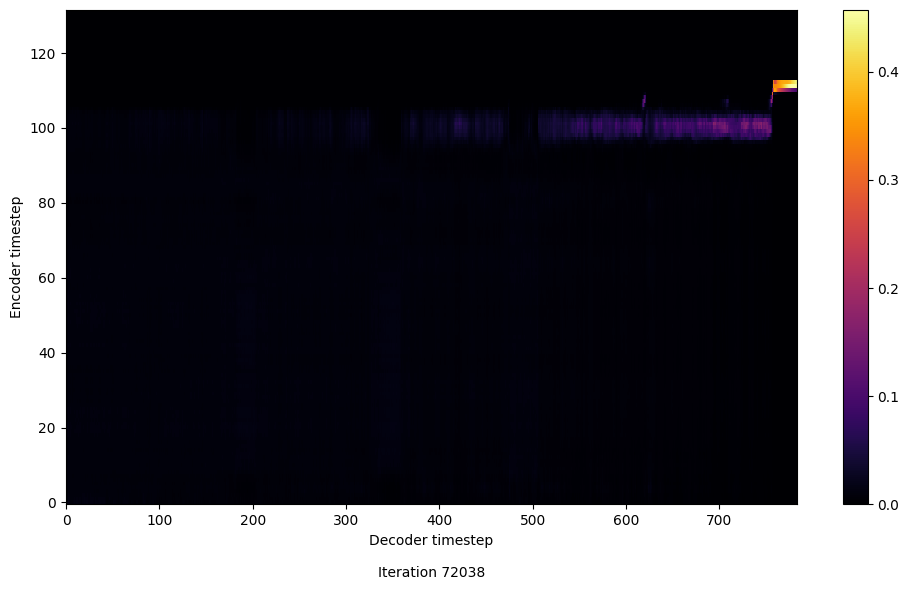

current learning rate :  [0.0001]
Epoch [33/250] completed in 7018.88s

Starting Epoch: 34/250


  0%|          | 1/2183 [00:02<1:42:09,  2.81s/it]

Epoch [34/250], Step [1/2183], Total Loss: 0.500172, Student Loss: 0.766059, Teacher Loss: 0.249304, Distillation Loss: 0.234285, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.80s


  1%|          | 11/2183 [00:29<1:40:15,  2.77s/it]

Epoch [34/250], Step [11/2183], Total Loss: 0.548015, Student Loss: 0.836381, Teacher Loss: 0.263197, Distillation Loss: 0.259649, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.83s


  1%|          | 21/2183 [00:55<1:36:09,  2.67s/it]

Epoch [34/250], Step [21/2183], Total Loss: 0.575559, Student Loss: 0.880153, Teacher Loss: 0.268165, Distillation Loss: 0.270965, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.68s


  1%|▏         | 31/2183 [01:21<1:29:38,  2.50s/it]

Epoch [34/250], Step [31/2183], Total Loss: 0.594278, Student Loss: 0.908487, Teacher Loss: 0.288326, Distillation Loss: 0.280069, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.08s


  2%|▏         | 41/2183 [01:48<1:35:59,  2.69s/it]

Epoch [34/250], Step [41/2183], Total Loss: 0.548710, Student Loss: 0.839975, Teacher Loss: 0.249899, Distillation Loss: 0.257445, Gradient Norm: 0.75, Learning Rate: 0.00010000, Duration: 2.74s


  2%|▏         | 51/2183 [02:14<1:30:31,  2.55s/it]

Epoch [34/250], Step [51/2183], Total Loss: 0.561579, Student Loss: 0.858900, Teacher Loss: 0.254321, Distillation Loss: 0.264258, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.37s


  3%|▎         | 61/2183 [02:41<1:36:11,  2.72s/it]

Epoch [34/250], Step [61/2183], Total Loss: 0.510833, Student Loss: 0.782203, Teacher Loss: 0.261325, Distillation Loss: 0.239464, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 3.09s


  3%|▎         | 71/2183 [03:06<1:26:58,  2.47s/it]

Epoch [34/250], Step [71/2183], Total Loss: 0.557800, Student Loss: 0.852292, Teacher Loss: 0.274321, Distillation Loss: 0.263308, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.48s


  4%|▎         | 81/2183 [03:32<1:31:14,  2.60s/it]

Epoch [34/250], Step [81/2183], Total Loss: 0.509477, Student Loss: 0.773279, Teacher Loss: 0.231469, Distillation Loss: 0.245675, Gradient Norm: 1.58, Learning Rate: 0.00010000, Duration: 2.56s


  4%|▍         | 91/2183 [03:57<1:26:01,  2.47s/it]

Epoch [34/250], Step [91/2183], Total Loss: 0.614386, Student Loss: 0.939777, Teacher Loss: 0.275446, Distillation Loss: 0.288994, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.20s


  5%|▍         | 101/2183 [04:23<1:27:03,  2.51s/it]

Epoch [34/250], Step [101/2183], Total Loss: 0.599757, Student Loss: 0.918422, Teacher Loss: 0.276839, Distillation Loss: 0.281093, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.37s


  5%|▌         | 111/2183 [04:49<1:28:40,  2.57s/it]

Epoch [34/250], Step [111/2183], Total Loss: 0.572562, Student Loss: 0.871890, Teacher Loss: 0.262363, Distillation Loss: 0.273235, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.45s


  6%|▌         | 121/2183 [05:15<1:32:06,  2.68s/it]

Epoch [34/250], Step [121/2183], Total Loss: 0.485827, Student Loss: 0.742610, Teacher Loss: 0.224558, Distillation Loss: 0.229045, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.83s


  6%|▌         | 131/2183 [05:40<1:24:52,  2.48s/it]

Epoch [34/250], Step [131/2183], Total Loss: 0.614510, Student Loss: 0.934238, Teacher Loss: 0.279054, Distillation Loss: 0.294781, Gradient Norm: 1.79, Learning Rate: 0.00010000, Duration: 2.56s


  6%|▋         | 141/2183 [06:06<1:25:55,  2.52s/it]

Epoch [34/250], Step [141/2183], Total Loss: 0.592674, Student Loss: 0.905762, Teacher Loss: 0.281275, Distillation Loss: 0.279586, Gradient Norm: 1.50, Learning Rate: 0.00010000, Duration: 2.48s


  7%|▋         | 151/2183 [06:32<1:24:22,  2.49s/it]

Epoch [34/250], Step [151/2183], Total Loss: 0.542368, Student Loss: 0.828478, Teacher Loss: 0.240428, Distillation Loss: 0.256257, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.37s


  7%|▋         | 161/2183 [06:58<1:28:24,  2.62s/it]

Epoch [34/250], Step [161/2183], Total Loss: 0.581246, Student Loss: 0.887730, Teacher Loss: 0.261310, Distillation Loss: 0.274762, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.58s


  8%|▊         | 171/2183 [07:24<1:26:14,  2.57s/it]

Epoch [34/250], Step [171/2183], Total Loss: 0.685858, Student Loss: 1.050579, Teacher Loss: 0.324797, Distillation Loss: 0.321137, Gradient Norm: 1.34, Learning Rate: 0.00010000, Duration: 2.90s


  8%|▊         | 181/2183 [07:49<1:22:42,  2.48s/it]

Epoch [34/250], Step [181/2183], Total Loss: 0.675069, Student Loss: 1.028646, Teacher Loss: 0.319797, Distillation Loss: 0.321492, Gradient Norm: 1.83, Learning Rate: 0.00010000, Duration: 2.62s


  9%|▊         | 191/2183 [08:14<1:19:36,  2.40s/it]

Epoch [34/250], Step [191/2183], Total Loss: 0.625016, Student Loss: 0.947797, Teacher Loss: 0.298115, Distillation Loss: 0.302234, Gradient Norm: 1.79, Learning Rate: 0.00010000, Duration: 1.79s


  9%|▉         | 201/2183 [08:40<1:26:58,  2.63s/it]

Epoch [34/250], Step [201/2183], Total Loss: 0.597868, Student Loss: 0.910498, Teacher Loss: 0.267796, Distillation Loss: 0.285238, Gradient Norm: 1.42, Learning Rate: 0.00010000, Duration: 2.66s


 10%|▉         | 211/2183 [09:06<1:24:16,  2.56s/it]

Epoch [34/250], Step [211/2183], Total Loss: 0.702810, Student Loss: 1.072499, Teacher Loss: 0.343322, Distillation Loss: 0.333121, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.46s


 10%|█         | 221/2183 [09:31<1:22:22,  2.52s/it]

Epoch [34/250], Step [221/2183], Total Loss: 0.636052, Student Loss: 0.975429, Teacher Loss: 0.295828, Distillation Loss: 0.296675, Gradient Norm: 1.72, Learning Rate: 0.00010000, Duration: 2.27s


 11%|█         | 231/2183 [09:57<1:25:43,  2.63s/it]

Epoch [34/250], Step [231/2183], Total Loss: 0.412628, Student Loss: 0.627119, Teacher Loss: 0.185117, Distillation Loss: 0.198136, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.45s


 11%|█         | 241/2183 [10:23<1:20:21,  2.48s/it]

Epoch [34/250], Step [241/2183], Total Loss: 0.622463, Student Loss: 0.948203, Teacher Loss: 0.298171, Distillation Loss: 0.296723, Gradient Norm: 1.92, Learning Rate: 0.00010000, Duration: 2.27s


 11%|█▏        | 251/2183 [10:49<1:22:47,  2.57s/it]

Epoch [34/250], Step [251/2183], Total Loss: 0.614168, Student Loss: 0.940770, Teacher Loss: 0.300924, Distillation Loss: 0.287567, Gradient Norm: 0.95, Learning Rate: 0.00010000, Duration: 2.49s


 12%|█▏        | 261/2183 [11:14<1:20:59,  2.53s/it]

Epoch [34/250], Step [261/2183], Total Loss: 0.639003, Student Loss: 0.980068, Teacher Loss: 0.316653, Distillation Loss: 0.297938, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.50s


 12%|█▏        | 271/2183 [11:40<1:20:20,  2.52s/it]

Epoch [34/250], Step [271/2183], Total Loss: 0.673033, Student Loss: 1.026706, Teacher Loss: 0.330210, Distillation Loss: 0.319361, Gradient Norm: 1.63, Learning Rate: 0.00010000, Duration: 2.61s


 13%|█▎        | 281/2183 [12:06<1:25:08,  2.69s/it]

Epoch [34/250], Step [281/2183], Total Loss: 0.589985, Student Loss: 0.900009, Teacher Loss: 0.283772, Distillation Loss: 0.279961, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.44s


 13%|█▎        | 291/2183 [12:31<1:21:30,  2.58s/it]

Epoch [34/250], Step [291/2183], Total Loss: 0.606232, Student Loss: 0.927759, Teacher Loss: 0.281101, Distillation Loss: 0.284705, Gradient Norm: 1.53, Learning Rate: 0.00010000, Duration: 2.61s


 14%|█▍        | 301/2183 [12:56<1:19:22,  2.53s/it]

Epoch [34/250], Step [301/2183], Total Loss: 0.560334, Student Loss: 0.854348, Teacher Loss: 0.271612, Distillation Loss: 0.266321, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.49s


 14%|█▍        | 311/2183 [13:22<1:19:04,  2.53s/it]

Epoch [34/250], Step [311/2183], Total Loss: 0.512201, Student Loss: 0.784310, Teacher Loss: 0.256442, Distillation Loss: 0.240092, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.30s


 15%|█▍        | 321/2183 [13:47<1:16:25,  2.46s/it]

Epoch [34/250], Step [321/2183], Total Loss: 0.507070, Student Loss: 0.775099, Teacher Loss: 0.256993, Distillation Loss: 0.239042, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.43s


 15%|█▌        | 331/2183 [14:12<1:15:28,  2.45s/it]

Epoch [34/250], Step [331/2183], Total Loss: 0.614432, Student Loss: 0.936746, Teacher Loss: 0.289372, Distillation Loss: 0.292119, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.43s


 16%|█▌        | 341/2183 [14:38<1:24:17,  2.75s/it]

Epoch [34/250], Step [341/2183], Total Loss: 0.614630, Student Loss: 0.939727, Teacher Loss: 0.281445, Distillation Loss: 0.289533, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.87s


 16%|█▌        | 351/2183 [15:04<1:15:35,  2.48s/it]

Epoch [34/250], Step [351/2183], Total Loss: 0.599607, Student Loss: 0.914980, Teacher Loss: 0.277948, Distillation Loss: 0.284234, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.11s


 17%|█▋        | 361/2183 [15:30<1:22:15,  2.71s/it]

Epoch [34/250], Step [361/2183], Total Loss: 0.580977, Student Loss: 0.892180, Teacher Loss: 0.295323, Distillation Loss: 0.269774, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.77s


 17%|█▋        | 371/2183 [15:56<1:19:36,  2.64s/it]

Epoch [34/250], Step [371/2183], Total Loss: 0.516027, Student Loss: 0.786360, Teacher Loss: 0.230731, Distillation Loss: 0.245695, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.68s


 17%|█▋        | 381/2183 [16:22<1:14:01,  2.46s/it]

Epoch [34/250], Step [381/2183], Total Loss: 0.697001, Student Loss: 1.070596, Teacher Loss: 0.328443, Distillation Loss: 0.323407, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.21s


 18%|█▊        | 391/2183 [16:50<1:24:32,  2.83s/it]

Epoch [34/250], Step [391/2183], Total Loss: 0.547157, Student Loss: 0.838734, Teacher Loss: 0.289292, Distillation Loss: 0.255580, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.82s


 18%|█▊        | 401/2183 [17:16<1:19:20,  2.67s/it]

Epoch [34/250], Step [401/2183], Total Loss: 0.463873, Student Loss: 0.705784, Teacher Loss: 0.203788, Distillation Loss: 0.221961, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.69s


 19%|█▉        | 411/2183 [17:42<1:18:09,  2.65s/it]

Epoch [34/250], Step [411/2183], Total Loss: 0.360787, Student Loss: 0.544603, Teacher Loss: 0.166240, Distillation Loss: 0.176971, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.60s


 19%|█▉        | 421/2183 [18:09<1:20:04,  2.73s/it]

Epoch [34/250], Step [421/2183], Total Loss: 0.638979, Student Loss: 0.975898, Teacher Loss: 0.287643, Distillation Loss: 0.302060, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.68s


 20%|█▉        | 431/2183 [18:34<1:07:54,  2.33s/it]

Epoch [34/250], Step [431/2183], Total Loss: 0.635918, Student Loss: 0.965718, Teacher Loss: 0.321244, Distillation Loss: 0.306119, Gradient Norm: 2.20, Learning Rate: 0.00010000, Duration: 2.28s


 20%|██        | 441/2183 [18:59<1:12:10,  2.49s/it]

Epoch [34/250], Step [441/2183], Total Loss: 0.626796, Student Loss: 0.957407, Teacher Loss: 0.284947, Distillation Loss: 0.296184, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.70s


 21%|██        | 451/2183 [19:24<1:12:24,  2.51s/it]

Epoch [34/250], Step [451/2183], Total Loss: 0.633251, Student Loss: 0.967580, Teacher Loss: 0.300829, Distillation Loss: 0.298922, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.62s


 21%|██        | 461/2183 [19:49<1:15:54,  2.65s/it]

Epoch [34/250], Step [461/2183], Total Loss: 0.445751, Student Loss: 0.682357, Teacher Loss: 0.222260, Distillation Loss: 0.209146, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.61s


 22%|██▏       | 471/2183 [20:16<1:17:09,  2.70s/it]

Epoch [34/250], Step [471/2183], Total Loss: 0.527280, Student Loss: 0.804146, Teacher Loss: 0.238415, Distillation Loss: 0.250414, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.78s


 22%|██▏       | 481/2183 [20:42<1:11:03,  2.50s/it]

Epoch [34/250], Step [481/2183], Total Loss: 0.604576, Student Loss: 0.923888, Teacher Loss: 0.280706, Distillation Loss: 0.285264, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.24s


 22%|██▏       | 491/2183 [21:08<1:12:50,  2.58s/it]

Epoch [34/250], Step [491/2183], Total Loss: 0.503501, Student Loss: 0.769190, Teacher Loss: 0.249068, Distillation Loss: 0.237811, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.48s


 23%|██▎       | 501/2183 [21:34<1:15:58,  2.71s/it]

Epoch [34/250], Step [501/2183], Total Loss: 0.636639, Student Loss: 0.969049, Teacher Loss: 0.302745, Distillation Loss: 0.304229, Gradient Norm: 1.76, Learning Rate: 0.00010000, Duration: 2.66s


 23%|██▎       | 511/2183 [22:01<1:14:56,  2.69s/it]

Epoch [34/250], Step [511/2183], Total Loss: 0.611910, Student Loss: 0.931886, Teacher Loss: 0.301369, Distillation Loss: 0.291934, Gradient Norm: 2.02, Learning Rate: 0.00010000, Duration: 2.67s


 24%|██▍       | 521/2183 [22:24<1:04:19,  2.32s/it]

Epoch [34/250], Step [521/2183], Total Loss: 0.590192, Student Loss: 0.901286, Teacher Loss: 0.273984, Distillation Loss: 0.279099, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.37s


 24%|██▍       | 531/2183 [22:50<1:12:41,  2.64s/it]

Epoch [34/250], Step [531/2183], Total Loss: 0.467856, Student Loss: 0.708100, Teacher Loss: 0.207060, Distillation Loss: 0.227612, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.71s


 25%|██▍       | 541/2183 [23:15<1:07:32,  2.47s/it]

Epoch [34/250], Step [541/2183], Total Loss: 0.572900, Student Loss: 0.873780, Teacher Loss: 0.261565, Distillation Loss: 0.272020, Gradient Norm: 1.56, Learning Rate: 0.00010000, Duration: 2.29s


 25%|██▌       | 551/2183 [23:40<1:11:00,  2.61s/it]

Epoch [34/250], Step [551/2183], Total Loss: 0.467034, Student Loss: 0.713141, Teacher Loss: 0.214364, Distillation Loss: 0.220927, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.85s


 26%|██▌       | 561/2183 [24:06<1:08:13,  2.52s/it]

Epoch [34/250], Step [561/2183], Total Loss: 0.551860, Student Loss: 0.839014, Teacher Loss: 0.268139, Distillation Loss: 0.264706, Gradient Norm: 1.44, Learning Rate: 0.00010000, Duration: 2.41s


 26%|██▌       | 571/2183 [24:33<1:11:06,  2.65s/it]

Epoch [34/250], Step [571/2183], Total Loss: 0.606883, Student Loss: 0.923681, Teacher Loss: 0.295865, Distillation Loss: 0.290086, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.62s


 27%|██▋       | 581/2183 [24:57<1:04:47,  2.43s/it]

Epoch [34/250], Step [581/2183], Total Loss: 0.660919, Student Loss: 1.007412, Teacher Loss: 0.324048, Distillation Loss: 0.314425, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.45s


 27%|██▋       | 591/2183 [25:25<1:12:36,  2.74s/it]

Epoch [34/250], Step [591/2183], Total Loss: 0.548216, Student Loss: 0.837207, Teacher Loss: 0.256779, Distillation Loss: 0.259226, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.71s


 28%|██▊       | 601/2183 [25:50<1:04:55,  2.46s/it]

Epoch [34/250], Step [601/2183], Total Loss: 0.661689, Student Loss: 1.012971, Teacher Loss: 0.298756, Distillation Loss: 0.310408, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.21s


 28%|██▊       | 611/2183 [26:17<1:10:43,  2.70s/it]

Epoch [34/250], Step [611/2183], Total Loss: 0.583781, Student Loss: 0.890490, Teacher Loss: 0.281794, Distillation Loss: 0.277071, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.67s


 28%|██▊       | 621/2183 [26:44<1:11:47,  2.76s/it]

Epoch [34/250], Step [621/2183], Total Loss: 0.512020, Student Loss: 0.782512, Teacher Loss: 0.232042, Distillation Loss: 0.241529, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.78s


 29%|██▉       | 631/2183 [27:10<1:06:55,  2.59s/it]

Epoch [34/250], Step [631/2183], Total Loss: 0.430565, Student Loss: 0.654731, Teacher Loss: 0.186828, Distillation Loss: 0.206399, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.48s


 29%|██▉       | 641/2183 [27:36<1:08:41,  2.67s/it]

Epoch [34/250], Step [641/2183], Total Loss: 0.628217, Student Loss: 0.954977, Teacher Loss: 0.283775, Distillation Loss: 0.301457, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 3.10s


 30%|██▉       | 651/2183 [28:01<1:02:46,  2.46s/it]

Epoch [34/250], Step [651/2183], Total Loss: 0.683073, Student Loss: 1.044362, Teacher Loss: 0.332668, Distillation Loss: 0.321783, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.54s


 30%|███       | 661/2183 [28:26<1:04:35,  2.55s/it]

Epoch [34/250], Step [661/2183], Total Loss: 0.659186, Student Loss: 1.009024, Teacher Loss: 0.311271, Distillation Loss: 0.309348, Gradient Norm: 1.53, Learning Rate: 0.00010000, Duration: 2.46s


 31%|███       | 671/2183 [28:52<1:07:56,  2.70s/it]

Epoch [34/250], Step [671/2183], Total Loss: 0.659828, Student Loss: 1.006119, Teacher Loss: 0.304551, Distillation Loss: 0.313538, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.49s


 31%|███       | 681/2183 [29:18<1:04:34,  2.58s/it]

Epoch [34/250], Step [681/2183], Total Loss: 0.684380, Student Loss: 1.052188, Teacher Loss: 0.325202, Distillation Loss: 0.316572, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.55s


 32%|███▏      | 691/2183 [29:43<1:01:08,  2.46s/it]

Epoch [34/250], Step [691/2183], Total Loss: 0.624865, Student Loss: 0.956170, Teacher Loss: 0.283610, Distillation Loss: 0.293560, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.60s


 32%|███▏      | 701/2183 [30:10<1:08:08,  2.76s/it]

Epoch [34/250], Step [701/2183], Total Loss: 0.569422, Student Loss: 0.873742, Teacher Loss: 0.270256, Distillation Loss: 0.265103, Gradient Norm: 1.71, Learning Rate: 0.00010000, Duration: 2.85s


 33%|███▎      | 711/2183 [30:35<1:03:17,  2.58s/it]

Epoch [34/250], Step [711/2183], Total Loss: 0.529434, Student Loss: 0.804290, Teacher Loss: 0.232296, Distillation Loss: 0.254578, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.78s


 33%|███▎      | 721/2183 [31:01<1:05:29,  2.69s/it]

Epoch [34/250], Step [721/2183], Total Loss: 0.603459, Student Loss: 0.922270, Teacher Loss: 0.275396, Distillation Loss: 0.284649, Gradient Norm: 1.76, Learning Rate: 0.00010000, Duration: 2.70s


 33%|███▎      | 731/2183 [31:27<1:02:39,  2.59s/it]

Epoch [34/250], Step [731/2183], Total Loss: 0.430089, Student Loss: 0.657605, Teacher Loss: 0.207966, Distillation Loss: 0.202573, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.71s


 34%|███▍      | 741/2183 [31:52<57:25,  2.39s/it]  

Epoch [34/250], Step [741/2183], Total Loss: 0.574152, Student Loss: 0.875249, Teacher Loss: 0.265512, Distillation Loss: 0.273056, Gradient Norm: 2.43, Learning Rate: 0.00010000, Duration: 2.11s


 34%|███▍      | 751/2183 [32:17<58:50,  2.47s/it]  

Epoch [34/250], Step [751/2183], Total Loss: 0.541152, Student Loss: 0.823640, Teacher Loss: 0.240056, Distillation Loss: 0.258663, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.64s


 35%|███▍      | 761/2183 [32:43<1:01:09,  2.58s/it]

Epoch [34/250], Step [761/2183], Total Loss: 0.604757, Student Loss: 0.925472, Teacher Loss: 0.290795, Distillation Loss: 0.284043, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.62s


 35%|███▌      | 771/2183 [33:10<1:03:06,  2.68s/it]

Epoch [34/250], Step [771/2183], Total Loss: 0.571133, Student Loss: 0.871745, Teacher Loss: 0.277726, Distillation Loss: 0.270521, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.50s


 36%|███▌      | 781/2183 [33:37<1:02:50,  2.69s/it]

Epoch [34/250], Step [781/2183], Total Loss: 0.635733, Student Loss: 0.969408, Teacher Loss: 0.325542, Distillation Loss: 0.302058, Gradient Norm: 2.78, Learning Rate: 0.00010000, Duration: 2.50s


 36%|███▌      | 791/2183 [34:03<1:02:47,  2.71s/it]

Epoch [34/250], Step [791/2183], Total Loss: 0.565710, Student Loss: 0.866228, Teacher Loss: 0.279623, Distillation Loss: 0.265192, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.87s


 37%|███▋      | 801/2183 [34:30<1:00:14,  2.62s/it]

Epoch [34/250], Step [801/2183], Total Loss: 0.677653, Student Loss: 1.038098, Teacher Loss: 0.312765, Distillation Loss: 0.317208, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.65s


 37%|███▋      | 811/2183 [34:57<1:02:37,  2.74s/it]

Epoch [34/250], Step [811/2183], Total Loss: 0.649740, Student Loss: 0.991676, Teacher Loss: 0.312142, Distillation Loss: 0.307803, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 2.74s


 38%|███▊      | 821/2183 [35:22<58:10,  2.56s/it]  

Epoch [34/250], Step [821/2183], Total Loss: 0.663121, Student Loss: 1.008733, Teacher Loss: 0.313816, Distillation Loss: 0.317510, Gradient Norm: 1.47, Learning Rate: 0.00010000, Duration: 2.46s


 38%|███▊      | 831/2183 [35:49<59:40,  2.65s/it]  

Epoch [34/250], Step [831/2183], Total Loss: 0.480707, Student Loss: 0.734442, Teacher Loss: 0.220906, Distillation Loss: 0.226972, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.75s


 39%|███▊      | 841/2183 [36:16<1:01:38,  2.76s/it]

Epoch [34/250], Step [841/2183], Total Loss: 0.509426, Student Loss: 0.781657, Teacher Loss: 0.244610, Distillation Loss: 0.237195, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.66s


 39%|███▉      | 851/2183 [36:42<59:17,  2.67s/it]  

Epoch [34/250], Step [851/2183], Total Loss: 0.532864, Student Loss: 0.813196, Teacher Loss: 0.261790, Distillation Loss: 0.252532, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.80s


 39%|███▉      | 861/2183 [37:07<59:32,  2.70s/it]

Epoch [34/250], Step [861/2183], Total Loss: 0.490128, Student Loss: 0.745743, Teacher Loss: 0.225435, Distillation Loss: 0.234512, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.68s


 40%|███▉      | 871/2183 [37:34<54:56,  2.51s/it]  

Epoch [34/250], Step [871/2183], Total Loss: 0.504785, Student Loss: 0.769215, Teacher Loss: 0.224993, Distillation Loss: 0.240356, Gradient Norm: 1.58, Learning Rate: 0.00010000, Duration: 2.13s


 40%|████      | 881/2183 [38:00<55:58,  2.58s/it]

Epoch [34/250], Step [881/2183], Total Loss: 0.623841, Student Loss: 0.955719, Teacher Loss: 0.316069, Distillation Loss: 0.291962, Gradient Norm: 1.43, Learning Rate: 0.00010000, Duration: 2.83s


 41%|████      | 891/2183 [38:26<58:48,  2.73s/it]  

Epoch [34/250], Step [891/2183], Total Loss: 0.571908, Student Loss: 0.874187, Teacher Loss: 0.256689, Distillation Loss: 0.269630, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.77s


 41%|████▏     | 901/2183 [38:52<57:34,  2.69s/it]

Epoch [34/250], Step [901/2183], Total Loss: 0.525676, Student Loss: 0.805098, Teacher Loss: 0.253202, Distillation Loss: 0.246254, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.78s


 42%|████▏     | 911/2183 [39:20<58:16,  2.75s/it]

Epoch [34/250], Step [911/2183], Total Loss: 0.539989, Student Loss: 0.825888, Teacher Loss: 0.259347, Distillation Loss: 0.254090, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.62s


 42%|████▏     | 921/2183 [39:47<56:40,  2.69s/it]  

Epoch [34/250], Step [921/2183], Total Loss: 0.653083, Student Loss: 0.999829, Teacher Loss: 0.340968, Distillation Loss: 0.306337, Gradient Norm: 1.54, Learning Rate: 0.00010000, Duration: 2.56s


 43%|████▎     | 931/2183 [40:13<54:05,  2.59s/it]

Epoch [34/250], Step [931/2183], Total Loss: 0.569524, Student Loss: 0.874797, Teacher Loss: 0.283585, Distillation Loss: 0.264251, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.61s


 43%|████▎     | 941/2183 [40:40<56:34,  2.73s/it]

Epoch [34/250], Step [941/2183], Total Loss: 0.602091, Student Loss: 0.915643, Teacher Loss: 0.270346, Distillation Loss: 0.288540, Gradient Norm: 2.39, Learning Rate: 0.00010000, Duration: 2.78s


 44%|████▎     | 951/2183 [41:06<51:34,  2.51s/it]

Epoch [34/250], Step [951/2183], Total Loss: 0.577975, Student Loss: 0.888235, Teacher Loss: 0.275321, Distillation Loss: 0.267715, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.22s


 44%|████▍     | 961/2183 [41:32<51:34,  2.53s/it]

Epoch [34/250], Step [961/2183], Total Loss: 0.692382, Student Loss: 1.057153, Teacher Loss: 0.314640, Distillation Loss: 0.327611, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.31s


 44%|████▍     | 971/2183 [41:59<55:48,  2.76s/it]

Epoch [34/250], Step [971/2183], Total Loss: 0.622342, Student Loss: 0.948097, Teacher Loss: 0.271860, Distillation Loss: 0.296587, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.91s


 45%|████▍     | 981/2183 [42:24<52:49,  2.64s/it]

Epoch [34/250], Step [981/2183], Total Loss: 0.547306, Student Loss: 0.836349, Teacher Loss: 0.274495, Distillation Loss: 0.258264, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.77s


 45%|████▌     | 991/2183 [42:49<50:01,  2.52s/it]

Epoch [34/250], Step [991/2183], Total Loss: 0.504627, Student Loss: 0.768476, Teacher Loss: 0.218430, Distillation Loss: 0.240777, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.30s


 46%|████▌     | 1001/2183 [43:16<54:23,  2.76s/it]

Epoch [34/250], Step [1001/2183], Total Loss: 0.525964, Student Loss: 0.799338, Teacher Loss: 0.258911, Distillation Loss: 0.252591, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.79s


 46%|████▋     | 1011/2183 [43:41<47:57,  2.45s/it]

Epoch [34/250], Step [1011/2183], Total Loss: 0.520428, Student Loss: 0.797741, Teacher Loss: 0.226441, Distillation Loss: 0.243115, Gradient Norm: 1.77, Learning Rate: 0.00010000, Duration: 2.06s


 47%|████▋     | 1021/2183 [44:07<50:58,  2.63s/it]

Epoch [34/250], Step [1021/2183], Total Loss: 0.570447, Student Loss: 0.873904, Teacher Loss: 0.280305, Distillation Loss: 0.266990, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.74s


 47%|████▋     | 1031/2183 [44:33<50:14,  2.62s/it]

Epoch [34/250], Step [1031/2183], Total Loss: 0.548186, Student Loss: 0.834935, Teacher Loss: 0.285327, Distillation Loss: 0.261436, Gradient Norm: 1.90, Learning Rate: 0.00010000, Duration: 2.63s


 48%|████▊     | 1041/2183 [45:00<48:32,  2.55s/it]

Epoch [34/250], Step [1041/2183], Total Loss: 0.607582, Student Loss: 0.930256, Teacher Loss: 0.293438, Distillation Loss: 0.284907, Gradient Norm: 1.97, Learning Rate: 0.00010000, Duration: 2.54s


 48%|████▊     | 1051/2183 [45:27<50:49,  2.69s/it]

Epoch [34/250], Step [1051/2183], Total Loss: 0.543235, Student Loss: 0.830100, Teacher Loss: 0.264868, Distillation Loss: 0.256370, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.58s


 49%|████▊     | 1061/2183 [45:52<45:30,  2.43s/it]

Epoch [34/250], Step [1061/2183], Total Loss: 0.633806, Student Loss: 0.969953, Teacher Loss: 0.303772, Distillation Loss: 0.297658, Gradient Norm: 1.52, Learning Rate: 0.00010000, Duration: 2.07s


 49%|████▉     | 1071/2183 [46:17<47:25,  2.56s/it]

Epoch [34/250], Step [1071/2183], Total Loss: 0.502056, Student Loss: 0.765989, Teacher Loss: 0.230417, Distillation Loss: 0.238123, Gradient Norm: 1.53, Learning Rate: 0.00010000, Duration: 2.79s


 50%|████▉     | 1081/2183 [46:43<48:09,  2.62s/it]

Epoch [34/250], Step [1081/2183], Total Loss: 0.568955, Student Loss: 0.870222, Teacher Loss: 0.263632, Distillation Loss: 0.267689, Gradient Norm: 1.89, Learning Rate: 0.00010000, Duration: 2.72s


 50%|████▉     | 1091/2183 [47:10<48:21,  2.66s/it]

Epoch [34/250], Step [1091/2183], Total Loss: 0.601815, Student Loss: 0.922840, Teacher Loss: 0.280105, Distillation Loss: 0.280791, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.68s


 50%|█████     | 1101/2183 [47:34<46:13,  2.56s/it]

Epoch [34/250], Step [1101/2183], Total Loss: 0.692038, Student Loss: 1.057534, Teacher Loss: 0.329968, Distillation Loss: 0.326542, Gradient Norm: 2.55, Learning Rate: 0.00010000, Duration: 2.67s


 51%|█████     | 1111/2183 [48:00<45:49,  2.56s/it]

Epoch [34/250], Step [1111/2183], Total Loss: 0.622624, Student Loss: 0.953604, Teacher Loss: 0.308539, Distillation Loss: 0.291645, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.69s


 51%|█████▏    | 1121/2183 [48:27<45:37,  2.58s/it]

Epoch [34/250], Step [1121/2183], Total Loss: 0.459194, Student Loss: 0.698459, Teacher Loss: 0.204715, Distillation Loss: 0.219929, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.63s


 52%|█████▏    | 1131/2183 [48:54<48:42,  2.78s/it]

Epoch [34/250], Step [1131/2183], Total Loss: 0.622597, Student Loss: 0.952089, Teacher Loss: 0.303982, Distillation Loss: 0.293105, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.81s


 52%|█████▏    | 1141/2183 [49:19<42:30,  2.45s/it]

Epoch [34/250], Step [1141/2183], Total Loss: 0.591683, Student Loss: 0.904473, Teacher Loss: 0.271747, Distillation Loss: 0.278893, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.49s


 53%|█████▎    | 1151/2183 [49:45<48:01,  2.79s/it]

Epoch [34/250], Step [1151/2183], Total Loss: 0.475112, Student Loss: 0.727124, Teacher Loss: 0.214698, Distillation Loss: 0.223101, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 3.15s


 53%|█████▎    | 1161/2183 [50:10<41:27,  2.43s/it]

Epoch [34/250], Step [1161/2183], Total Loss: 0.631746, Student Loss: 0.959094, Teacher Loss: 0.285132, Distillation Loss: 0.304398, Gradient Norm: 1.92, Learning Rate: 0.00010000, Duration: 2.03s


 54%|█████▎    | 1171/2183 [50:35<43:45,  2.59s/it]

Epoch [34/250], Step [1171/2183], Total Loss: 0.489486, Student Loss: 0.751327, Teacher Loss: 0.250763, Distillation Loss: 0.227645, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.38s


 54%|█████▍    | 1181/2183 [51:02<45:11,  2.71s/it]

Epoch [34/250], Step [1181/2183], Total Loss: 0.600823, Student Loss: 0.917395, Teacher Loss: 0.280395, Distillation Loss: 0.284250, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.64s


 55%|█████▍    | 1191/2183 [51:26<39:46,  2.41s/it]

Epoch [34/250], Step [1191/2183], Total Loss: 0.621675, Student Loss: 0.947976, Teacher Loss: 0.297569, Distillation Loss: 0.295374, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.17s


 55%|█████▌    | 1201/2183 [51:52<41:42,  2.55s/it]

Epoch [34/250], Step [1201/2183], Total Loss: 0.542337, Student Loss: 0.837133, Teacher Loss: 0.289354, Distillation Loss: 0.247540, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.68s


 55%|█████▌    | 1211/2183 [52:18<41:55,  2.59s/it]

Epoch [34/250], Step [1211/2183], Total Loss: 0.599670, Student Loss: 0.917356, Teacher Loss: 0.301399, Distillation Loss: 0.281984, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.34s


 56%|█████▌    | 1221/2183 [52:46<44:11,  2.76s/it]

Epoch [34/250], Step [1221/2183], Total Loss: 0.661700, Student Loss: 1.014530, Teacher Loss: 0.334825, Distillation Loss: 0.308869, Gradient Norm: 1.48, Learning Rate: 0.00010000, Duration: 2.75s


 56%|█████▋    | 1231/2183 [53:11<41:38,  2.62s/it]

Epoch [34/250], Step [1231/2183], Total Loss: 0.521573, Student Loss: 0.795987, Teacher Loss: 0.246468, Distillation Loss: 0.247160, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.79s


 57%|█████▋    | 1241/2183 [53:39<43:28,  2.77s/it]

Epoch [34/250], Step [1241/2183], Total Loss: 0.553492, Student Loss: 0.845796, Teacher Loss: 0.256886, Distillation Loss: 0.261188, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.79s


 57%|█████▋    | 1251/2183 [54:04<38:43,  2.49s/it]

Epoch [34/250], Step [1251/2183], Total Loss: 0.555859, Student Loss: 0.848447, Teacher Loss: 0.257598, Distillation Loss: 0.263270, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.51s


 58%|█████▊    | 1261/2183 [54:29<38:45,  2.52s/it]

Epoch [34/250], Step [1261/2183], Total Loss: 0.465741, Student Loss: 0.709245, Teacher Loss: 0.211167, Distillation Loss: 0.222237, Gradient Norm: 1.42, Learning Rate: 0.00010000, Duration: 2.49s


 58%|█████▊    | 1271/2183 [54:56<41:00,  2.70s/it]

Epoch [34/250], Step [1271/2183], Total Loss: 0.611707, Student Loss: 0.936641, Teacher Loss: 0.296482, Distillation Loss: 0.286772, Gradient Norm: 0.69, Learning Rate: 0.00010000, Duration: 2.70s


 59%|█████▊    | 1281/2183 [55:22<38:49,  2.58s/it]

Epoch [34/250], Step [1281/2183], Total Loss: 0.517055, Student Loss: 0.793221, Teacher Loss: 0.270281, Distillation Loss: 0.240889, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.75s


 59%|█████▉    | 1291/2183 [55:47<36:41,  2.47s/it]

Epoch [34/250], Step [1291/2183], Total Loss: 0.516224, Student Loss: 0.786151, Teacher Loss: 0.244152, Distillation Loss: 0.246296, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.58s


 60%|█████▉    | 1301/2183 [56:14<40:25,  2.75s/it]

Epoch [34/250], Step [1301/2183], Total Loss: 0.500651, Student Loss: 0.765566, Teacher Loss: 0.263520, Distillation Loss: 0.235737, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.83s


 60%|██████    | 1311/2183 [56:40<37:15,  2.56s/it]

Epoch [34/250], Step [1311/2183], Total Loss: 0.530127, Student Loss: 0.808239, Teacher Loss: 0.241471, Distillation Loss: 0.252015, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.71s


 61%|██████    | 1321/2183 [57:05<35:59,  2.50s/it]

Epoch [34/250], Step [1321/2183], Total Loss: 0.687354, Student Loss: 1.046299, Teacher Loss: 0.325101, Distillation Loss: 0.328410, Gradient Norm: 1.59, Learning Rate: 0.00010000, Duration: 2.31s


 61%|██████    | 1331/2183 [57:31<38:17,  2.70s/it]

Epoch [34/250], Step [1331/2183], Total Loss: 0.395398, Student Loss: 0.602469, Teacher Loss: 0.182196, Distillation Loss: 0.188327, Gradient Norm: 0.69, Learning Rate: 0.00010000, Duration: 2.70s


 61%|██████▏   | 1341/2183 [57:59<39:00,  2.78s/it]

Epoch [34/250], Step [1341/2183], Total Loss: 0.434498, Student Loss: 0.664983, Teacher Loss: 0.202900, Distillation Loss: 0.204013, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.83s


 62%|██████▏   | 1351/2183 [58:25<36:46,  2.65s/it]

Epoch [34/250], Step [1351/2183], Total Loss: 0.537653, Student Loss: 0.826645, Teacher Loss: 0.269245, Distillation Loss: 0.248662, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.79s


 62%|██████▏   | 1361/2183 [58:50<33:56,  2.48s/it]

Epoch [34/250], Step [1361/2183], Total Loss: 0.535796, Student Loss: 0.820168, Teacher Loss: 0.259516, Distillation Loss: 0.251424, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.23s


 63%|██████▎   | 1371/2183 [59:17<35:21,  2.61s/it]

Epoch [34/250], Step [1371/2183], Total Loss: 0.568481, Student Loss: 0.869578, Teacher Loss: 0.267054, Distillation Loss: 0.267384, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.78s


 63%|██████▎   | 1381/2183 [59:43<35:04,  2.62s/it]

Epoch [34/250], Step [1381/2183], Total Loss: 0.545576, Student Loss: 0.835886, Teacher Loss: 0.264020, Distillation Loss: 0.255267, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.55s


 64%|██████▎   | 1391/2183 [1:00:08<33:00,  2.50s/it]

Epoch [34/250], Step [1391/2183], Total Loss: 0.516268, Student Loss: 0.790354, Teacher Loss: 0.256120, Distillation Loss: 0.242182, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.78s


 64%|██████▍   | 1401/2183 [1:00:35<32:51,  2.52s/it]

Epoch [34/250], Step [1401/2183], Total Loss: 0.608773, Student Loss: 0.926469, Teacher Loss: 0.262869, Distillation Loss: 0.291076, Gradient Norm: 1.93, Learning Rate: 0.00010000, Duration: 2.28s


 65%|██████▍   | 1411/2183 [1:01:02<33:17,  2.59s/it]

Epoch [34/250], Step [1411/2183], Total Loss: 0.443054, Student Loss: 0.674093, Teacher Loss: 0.207421, Distillation Loss: 0.212015, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.41s


 65%|██████▌   | 1421/2183 [1:01:28<34:45,  2.74s/it]

Epoch [34/250], Step [1421/2183], Total Loss: 0.577134, Student Loss: 0.879894, Teacher Loss: 0.284780, Distillation Loss: 0.274374, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.83s


 66%|██████▌   | 1431/2183 [1:01:55<33:30,  2.67s/it]

Epoch [34/250], Step [1431/2183], Total Loss: 0.546883, Student Loss: 0.833141, Teacher Loss: 0.252969, Distillation Loss: 0.260626, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.91s


 66%|██████▌   | 1441/2183 [1:02:21<32:35,  2.63s/it]

Epoch [34/250], Step [1441/2183], Total Loss: 0.441627, Student Loss: 0.671301, Teacher Loss: 0.211072, Distillation Loss: 0.211953, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.60s


 66%|██████▋   | 1451/2183 [1:02:47<30:39,  2.51s/it]

Epoch [34/250], Step [1451/2183], Total Loss: 0.659182, Student Loss: 1.007650, Teacher Loss: 0.310429, Distillation Loss: 0.310714, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.42s


 67%|██████▋   | 1461/2183 [1:03:13<32:09,  2.67s/it]

Epoch [34/250], Step [1461/2183], Total Loss: 0.593571, Student Loss: 0.908917, Teacher Loss: 0.283973, Distillation Loss: 0.278224, Gradient Norm: 0.64, Learning Rate: 0.00010000, Duration: 2.66s


 67%|██████▋   | 1471/2183 [1:03:39<30:21,  2.56s/it]

Epoch [34/250], Step [1471/2183], Total Loss: 0.506377, Student Loss: 0.772725, Teacher Loss: 0.232866, Distillation Loss: 0.240028, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.79s


 68%|██████▊   | 1481/2183 [1:04:05<29:44,  2.54s/it]

Epoch [34/250], Step [1481/2183], Total Loss: 0.603551, Student Loss: 0.928316, Teacher Loss: 0.321880, Distillation Loss: 0.278787, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.14s


 68%|██████▊   | 1491/2183 [1:04:31<28:36,  2.48s/it]

Epoch [34/250], Step [1491/2183], Total Loss: 0.632396, Student Loss: 0.964757, Teacher Loss: 0.290290, Distillation Loss: 0.300034, Gradient Norm: 2.79, Learning Rate: 0.00010000, Duration: 2.61s


 69%|██████▉   | 1501/2183 [1:04:56<28:23,  2.50s/it]

Epoch [34/250], Step [1501/2183], Total Loss: 0.570905, Student Loss: 0.874576, Teacher Loss: 0.259213, Distillation Loss: 0.267234, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.21s


 69%|██████▉   | 1511/2183 [1:05:23<31:49,  2.84s/it]

Epoch [34/250], Step [1511/2183], Total Loss: 0.460458, Student Loss: 0.698977, Teacher Loss: 0.235286, Distillation Loss: 0.221938, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 3.13s


 70%|██████▉   | 1521/2183 [1:05:49<28:47,  2.61s/it]

Epoch [34/250], Step [1521/2183], Total Loss: 0.598543, Student Loss: 0.915331, Teacher Loss: 0.311547, Distillation Loss: 0.281754, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.74s


 70%|███████   | 1531/2183 [1:06:15<28:39,  2.64s/it]

Epoch [34/250], Step [1531/2183], Total Loss: 0.489150, Student Loss: 0.747891, Teacher Loss: 0.221588, Distillation Loss: 0.230409, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.73s


 71%|███████   | 1541/2183 [1:06:42<29:59,  2.80s/it]

Epoch [34/250], Step [1541/2183], Total Loss: 0.543935, Student Loss: 0.831307, Teacher Loss: 0.273246, Distillation Loss: 0.256563, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.76s


 71%|███████   | 1551/2183 [1:07:08<25:29,  2.42s/it]

Epoch [34/250], Step [1551/2183], Total Loss: 0.497878, Student Loss: 0.760857, Teacher Loss: 0.241255, Distillation Loss: 0.234898, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.06s


 72%|███████▏  | 1561/2183 [1:07:34<26:38,  2.57s/it]

Epoch [34/250], Step [1561/2183], Total Loss: 0.627052, Student Loss: 0.957955, Teacher Loss: 0.316353, Distillation Loss: 0.296148, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.67s


 72%|███████▏  | 1571/2183 [1:08:01<28:23,  2.78s/it]

Epoch [34/250], Step [1571/2183], Total Loss: 0.485053, Student Loss: 0.741668, Teacher Loss: 0.233178, Distillation Loss: 0.228439, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.75s


 72%|███████▏  | 1581/2183 [1:08:27<25:34,  2.55s/it]

Epoch [34/250], Step [1581/2183], Total Loss: 0.637104, Student Loss: 0.971339, Teacher Loss: 0.299580, Distillation Loss: 0.302869, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.60s


 73%|███████▎  | 1591/2183 [1:08:54<26:03,  2.64s/it]

Epoch [34/250], Step [1591/2183], Total Loss: 0.517738, Student Loss: 0.788753, Teacher Loss: 0.236551, Distillation Loss: 0.246722, Gradient Norm: 0.83, Learning Rate: 0.00010000, Duration: 2.60s


 73%|███████▎  | 1601/2183 [1:09:18<24:28,  2.52s/it]

Epoch [34/250], Step [1601/2183], Total Loss: 0.641702, Student Loss: 0.983782, Teacher Loss: 0.301092, Distillation Loss: 0.299622, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.49s


 74%|███████▍  | 1611/2183 [1:09:45<24:06,  2.53s/it]

Epoch [34/250], Step [1611/2183], Total Loss: 0.572287, Student Loss: 0.881370, Teacher Loss: 0.284049, Distillation Loss: 0.263204, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.48s


 74%|███████▍  | 1621/2183 [1:10:11<23:07,  2.47s/it]

Epoch [34/250], Step [1621/2183], Total Loss: 0.476073, Student Loss: 0.724345, Teacher Loss: 0.228315, Distillation Loss: 0.227801, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.07s


 75%|███████▍  | 1631/2183 [1:10:37<23:49,  2.59s/it]

Epoch [34/250], Step [1631/2183], Total Loss: 0.450153, Student Loss: 0.687381, Teacher Loss: 0.201511, Distillation Loss: 0.212925, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.78s


 75%|███████▌  | 1641/2183 [1:11:02<22:16,  2.47s/it]

Epoch [34/250], Step [1641/2183], Total Loss: 0.441676, Student Loss: 0.672027, Teacher Loss: 0.191503, Distillation Loss: 0.211324, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.62s


 76%|███████▌  | 1651/2183 [1:11:27<21:38,  2.44s/it]

Epoch [34/250], Step [1651/2183], Total Loss: 0.537199, Student Loss: 0.822467, Teacher Loss: 0.257621, Distillation Loss: 0.251932, Gradient Norm: 1.06, Learning Rate: 0.00010000, Duration: 2.14s


 76%|███████▌  | 1661/2183 [1:11:53<21:55,  2.52s/it]

Epoch [34/250], Step [1661/2183], Total Loss: 0.603136, Student Loss: 0.920075, Teacher Loss: 0.305298, Distillation Loss: 0.286197, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.47s


 77%|███████▋  | 1671/2183 [1:12:18<20:26,  2.40s/it]

Epoch [34/250], Step [1671/2183], Total Loss: 0.571015, Student Loss: 0.866489, Teacher Loss: 0.244203, Distillation Loss: 0.275540, Gradient Norm: 1.88, Learning Rate: 0.00010000, Duration: 1.80s


 77%|███████▋  | 1681/2183 [1:12:45<21:52,  2.62s/it]

Epoch [34/250], Step [1681/2183], Total Loss: 0.582819, Student Loss: 0.889094, Teacher Loss: 0.273589, Distillation Loss: 0.276543, Gradient Norm: 1.91, Learning Rate: 0.00010000, Duration: 2.50s


 77%|███████▋  | 1691/2183 [1:13:10<20:17,  2.47s/it]

Epoch [34/250], Step [1691/2183], Total Loss: 0.624728, Student Loss: 0.951941, Teacher Loss: 0.297576, Distillation Loss: 0.297516, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.60s


 78%|███████▊  | 1701/2183 [1:13:37<21:47,  2.71s/it]

Epoch [34/250], Step [1701/2183], Total Loss: 0.537485, Student Loss: 0.818342, Teacher Loss: 0.230288, Distillation Loss: 0.256628, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.65s


 78%|███████▊  | 1711/2183 [1:14:03<20:49,  2.65s/it]

Epoch [34/250], Step [1711/2183], Total Loss: 0.532151, Student Loss: 0.817112, Teacher Loss: 0.249678, Distillation Loss: 0.247190, Gradient Norm: 0.84, Learning Rate: 0.00010000, Duration: 2.56s


 79%|███████▉  | 1721/2183 [1:14:30<20:00,  2.60s/it]

Epoch [34/250], Step [1721/2183], Total Loss: 0.616339, Student Loss: 0.934314, Teacher Loss: 0.326492, Distillation Loss: 0.298365, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.55s


 79%|███████▉  | 1731/2183 [1:14:56<20:11,  2.68s/it]

Epoch [34/250], Step [1731/2183], Total Loss: 0.644800, Student Loss: 0.989004, Teacher Loss: 0.321472, Distillation Loss: 0.300596, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.77s


 80%|███████▉  | 1741/2183 [1:15:21<16:57,  2.30s/it]

Epoch [34/250], Step [1741/2183], Total Loss: 0.552570, Student Loss: 0.845922, Teacher Loss: 0.264396, Distillation Loss: 0.259218, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 1.83s


 80%|████████  | 1751/2183 [1:15:47<19:13,  2.67s/it]

Epoch [34/250], Step [1751/2183], Total Loss: 0.508744, Student Loss: 0.777137, Teacher Loss: 0.245027, Distillation Loss: 0.240350, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.76s


 81%|████████  | 1761/2183 [1:16:13<18:50,  2.68s/it]

Epoch [34/250], Step [1761/2183], Total Loss: 0.454098, Student Loss: 0.693554, Teacher Loss: 0.233010, Distillation Loss: 0.214642, Gradient Norm: 0.68, Learning Rate: 0.00010000, Duration: 2.83s


 81%|████████  | 1771/2183 [1:16:40<18:27,  2.69s/it]

Epoch [34/250], Step [1771/2183], Total Loss: 0.516949, Student Loss: 0.786428, Teacher Loss: 0.235504, Distillation Loss: 0.247470, Gradient Norm: 2.38, Learning Rate: 0.00010000, Duration: 2.60s


 82%|████████▏ | 1781/2183 [1:17:07<17:40,  2.64s/it]

Epoch [34/250], Step [1781/2183], Total Loss: 0.600819, Student Loss: 0.912456, Teacher Loss: 0.302127, Distillation Loss: 0.289182, Gradient Norm: 2.25, Learning Rate: 0.00010000, Duration: 2.53s


 82%|████████▏ | 1791/2183 [1:17:34<18:05,  2.77s/it]

Epoch [34/250], Step [1791/2183], Total Loss: 0.523042, Student Loss: 0.792757, Teacher Loss: 0.236740, Distillation Loss: 0.253328, Gradient Norm: 2.05, Learning Rate: 0.00010000, Duration: 2.57s


 83%|████████▎ | 1801/2183 [1:17:59<16:22,  2.57s/it]

Epoch [34/250], Step [1801/2183], Total Loss: 0.584905, Student Loss: 0.899170, Teacher Loss: 0.289178, Distillation Loss: 0.270640, Gradient Norm: 2.05, Learning Rate: 0.00010000, Duration: 2.57s


 83%|████████▎ | 1811/2183 [1:18:25<15:53,  2.56s/it]

Epoch [34/250], Step [1811/2183], Total Loss: 0.522570, Student Loss: 0.795868, Teacher Loss: 0.234757, Distillation Loss: 0.249271, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.73s


 83%|████████▎ | 1821/2183 [1:18:52<16:02,  2.66s/it]

Epoch [34/250], Step [1821/2183], Total Loss: 0.638455, Student Loss: 0.976960, Teacher Loss: 0.311330, Distillation Loss: 0.299950, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.43s


 84%|████████▍ | 1831/2183 [1:19:19<15:51,  2.70s/it]

Epoch [34/250], Step [1831/2183], Total Loss: 0.577267, Student Loss: 0.884452, Teacher Loss: 0.291662, Distillation Loss: 0.270082, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.85s


 84%|████████▍ | 1841/2183 [1:19:44<13:34,  2.38s/it]

Epoch [34/250], Step [1841/2183], Total Loss: 0.617584, Student Loss: 0.949952, Teacher Loss: 0.305159, Distillation Loss: 0.285216, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.42s


 85%|████████▍ | 1851/2183 [1:20:10<14:19,  2.59s/it]

Epoch [34/250], Step [1851/2183], Total Loss: 0.528181, Student Loss: 0.806214, Teacher Loss: 0.241144, Distillation Loss: 0.250148, Gradient Norm: 2.11, Learning Rate: 0.00010000, Duration: 2.80s


 85%|████████▌ | 1861/2183 [1:20:36<13:57,  2.60s/it]

Epoch [34/250], Step [1861/2183], Total Loss: 0.587187, Student Loss: 0.895454, Teacher Loss: 0.265311, Distillation Loss: 0.278920, Gradient Norm: 1.45, Learning Rate: 0.00010000, Duration: 2.66s


 86%|████████▌ | 1871/2183 [1:21:03<14:09,  2.72s/it]

Epoch [34/250], Step [1871/2183], Total Loss: 0.586650, Student Loss: 0.892880, Teacher Loss: 0.273793, Distillation Loss: 0.280420, Gradient Norm: 1.56, Learning Rate: 0.00010000, Duration: 2.68s


 86%|████████▌ | 1881/2183 [1:21:29<12:43,  2.53s/it]

Epoch [34/250], Step [1881/2183], Total Loss: 0.615224, Student Loss: 0.940251, Teacher Loss: 0.280250, Distillation Loss: 0.290197, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.58s


 87%|████████▋ | 1891/2183 [1:21:54<12:52,  2.65s/it]

Epoch [34/250], Step [1891/2183], Total Loss: 0.547638, Student Loss: 0.838607, Teacher Loss: 0.251028, Distillation Loss: 0.256669, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.54s


 87%|████████▋ | 1901/2183 [1:22:21<11:57,  2.55s/it]

Epoch [34/250], Step [1901/2183], Total Loss: 0.607530, Student Loss: 0.923693, Teacher Loss: 0.275733, Distillation Loss: 0.291367, Gradient Norm: 1.92, Learning Rate: 0.00010000, Duration: 2.63s


 88%|████████▊ | 1911/2183 [1:22:47<11:32,  2.55s/it]

Epoch [34/250], Step [1911/2183], Total Loss: 0.658985, Student Loss: 1.007653, Teacher Loss: 0.333996, Distillation Loss: 0.310316, Gradient Norm: 1.53, Learning Rate: 0.00010000, Duration: 2.26s


 88%|████████▊ | 1921/2183 [1:23:13<11:21,  2.60s/it]

Epoch [34/250], Step [1921/2183], Total Loss: 0.458894, Student Loss: 0.700306, Teacher Loss: 0.227639, Distillation Loss: 0.217482, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.40s


 88%|████████▊ | 1931/2183 [1:23:41<11:36,  2.76s/it]

Epoch [34/250], Step [1931/2183], Total Loss: 0.547592, Student Loss: 0.833577, Teacher Loss: 0.246335, Distillation Loss: 0.261607, Gradient Norm: 1.86, Learning Rate: 0.00010000, Duration: 2.85s


 89%|████████▉ | 1941/2183 [1:24:07<10:05,  2.50s/it]

Epoch [34/250], Step [1941/2183], Total Loss: 0.468089, Student Loss: 0.714912, Teacher Loss: 0.211736, Distillation Loss: 0.221266, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.09s


 89%|████████▉ | 1951/2183 [1:24:34<10:22,  2.68s/it]

Epoch [34/250], Step [1951/2183], Total Loss: 0.540207, Student Loss: 0.820629, Teacher Loss: 0.291546, Distillation Loss: 0.259785, Gradient Norm: 1.87, Learning Rate: 0.00010000, Duration: 2.59s


 90%|████████▉ | 1961/2183 [1:25:00<09:42,  2.62s/it]

Epoch [34/250], Step [1961/2183], Total Loss: 0.631774, Student Loss: 0.966963, Teacher Loss: 0.293590, Distillation Loss: 0.296585, Gradient Norm: 1.80, Learning Rate: 0.00010000, Duration: 2.61s


 90%|█████████ | 1971/2183 [1:25:25<08:43,  2.47s/it]

Epoch [34/250], Step [1971/2183], Total Loss: 0.579860, Student Loss: 0.884594, Teacher Loss: 0.283307, Distillation Loss: 0.275127, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.40s


 91%|█████████ | 1981/2183 [1:25:51<08:44,  2.60s/it]

Epoch [34/250], Step [1981/2183], Total Loss: 0.578266, Student Loss: 0.874905, Teacher Loss: 0.296455, Distillation Loss: 0.281628, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.67s


 91%|█████████ | 1991/2183 [1:26:18<08:28,  2.65s/it]

Epoch [34/250], Step [1991/2183], Total Loss: 0.528803, Student Loss: 0.808286, Teacher Loss: 0.298121, Distillation Loss: 0.249320, Gradient Norm: 0.62, Learning Rate: 0.00010000, Duration: 2.81s


 92%|█████████▏| 2001/2183 [1:26:44<08:02,  2.65s/it]

Epoch [34/250], Step [2001/2183], Total Loss: 0.516229, Student Loss: 0.786426, Teacher Loss: 0.243584, Distillation Loss: 0.246032, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.63s


 92%|█████████▏| 2011/2183 [1:27:11<07:48,  2.72s/it]

Epoch [34/250], Step [2011/2183], Total Loss: 0.560125, Student Loss: 0.858034, Teacher Loss: 0.270618, Distillation Loss: 0.262216, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 2.84s


 93%|█████████▎| 2021/2183 [1:27:38<07:16,  2.70s/it]

Epoch [34/250], Step [2021/2183], Total Loss: 0.626681, Student Loss: 0.961039, Teacher Loss: 0.329513, Distillation Loss: 0.292323, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.82s


 93%|█████████▎| 2031/2183 [1:28:04<06:47,  2.68s/it]

Epoch [34/250], Step [2031/2183], Total Loss: 0.491566, Student Loss: 0.752864, Teacher Loss: 0.256889, Distillation Loss: 0.230269, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.67s


 93%|█████████▎| 2041/2183 [1:28:28<05:45,  2.43s/it]

Epoch [34/250], Step [2041/2183], Total Loss: 0.551531, Student Loss: 0.837787, Teacher Loss: 0.287357, Distillation Loss: 0.265274, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.09s


 94%|█████████▍| 2051/2183 [1:28:54<05:37,  2.55s/it]

Epoch [34/250], Step [2051/2183], Total Loss: 0.603773, Student Loss: 0.927131, Teacher Loss: 0.294640, Distillation Loss: 0.280415, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.54s


 94%|█████████▍| 2061/2183 [1:29:21<05:27,  2.69s/it]

Epoch [34/250], Step [2061/2183], Total Loss: 0.581779, Student Loss: 0.886417, Teacher Loss: 0.286557, Distillation Loss: 0.277140, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.64s


 95%|█████████▍| 2071/2183 [1:29:48<04:50,  2.59s/it]

Epoch [34/250], Step [2071/2183], Total Loss: 0.556881, Student Loss: 0.850150, Teacher Loss: 0.266475, Distillation Loss: 0.263612, Gradient Norm: 0.92, Learning Rate: 0.00010000, Duration: 2.54s


 95%|█████████▌| 2081/2183 [1:30:14<04:23,  2.58s/it]

Epoch [34/250], Step [2081/2183], Total Loss: 0.582011, Student Loss: 0.888754, Teacher Loss: 0.311184, Distillation Loss: 0.275268, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.53s


 96%|█████████▌| 2091/2183 [1:30:39<04:11,  2.73s/it]

Epoch [34/250], Step [2091/2183], Total Loss: 0.554404, Student Loss: 0.850571, Teacher Loss: 0.257399, Distillation Loss: 0.258236, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.85s


 96%|█████████▌| 2101/2183 [1:31:06<03:41,  2.70s/it]

Epoch [34/250], Step [2101/2183], Total Loss: 0.549329, Student Loss: 0.840626, Teacher Loss: 0.278199, Distillation Loss: 0.258031, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.80s


 97%|█████████▋| 2111/2183 [1:31:33<03:09,  2.64s/it]

Epoch [34/250], Step [2111/2183], Total Loss: 0.525973, Student Loss: 0.804086, Teacher Loss: 0.249660, Distillation Loss: 0.247861, Gradient Norm: 0.65, Learning Rate: 0.00010000, Duration: 2.77s


 97%|█████████▋| 2121/2183 [1:31:58<02:35,  2.51s/it]

Epoch [34/250], Step [2121/2183], Total Loss: 0.602712, Student Loss: 0.919897, Teacher Loss: 0.272699, Distillation Loss: 0.285527, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.50s


 98%|█████████▊| 2131/2183 [1:32:25<02:23,  2.76s/it]

Epoch [34/250], Step [2131/2183], Total Loss: 0.592992, Student Loss: 0.912695, Teacher Loss: 0.307497, Distillation Loss: 0.273289, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.89s


 98%|█████████▊| 2141/2183 [1:32:51<01:47,  2.56s/it]

Epoch [34/250], Step [2141/2183], Total Loss: 0.573449, Student Loss: 0.876006, Teacher Loss: 0.285489, Distillation Loss: 0.270893, Gradient Norm: 2.13, Learning Rate: 0.00010000, Duration: 2.26s


 99%|█████████▊| 2151/2183 [1:33:16<01:19,  2.49s/it]

Epoch [34/250], Step [2151/2183], Total Loss: 0.592777, Student Loss: 0.904984, Teacher Loss: 0.324721, Distillation Loss: 0.280570, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.54s


 99%|█████████▉| 2161/2183 [1:33:41<00:55,  2.50s/it]

Epoch [34/250], Step [2161/2183], Total Loss: 0.493998, Student Loss: 0.755922, Teacher Loss: 0.226458, Distillation Loss: 0.232074, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.46s


 99%|█████████▉| 2171/2183 [1:34:06<00:30,  2.55s/it]

Epoch [34/250], Step [2171/2183], Total Loss: 0.507002, Student Loss: 0.778127, Teacher Loss: 0.268596, Distillation Loss: 0.235877, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.28s


100%|█████████▉| 2181/2183 [1:34:33<00:05,  2.74s/it]

Epoch [34/250], Step [2181/2183], Total Loss: 0.494902, Student Loss: 0.755780, Teacher Loss: 0.246355, Distillation Loss: 0.234024, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.78s


100%|██████████| 2183/2183 [1:34:38<00:00,  2.60s/it]


Epoch: 33 Validation loss 74221: 0.782866  Time: 117.3m LR: 0.000100


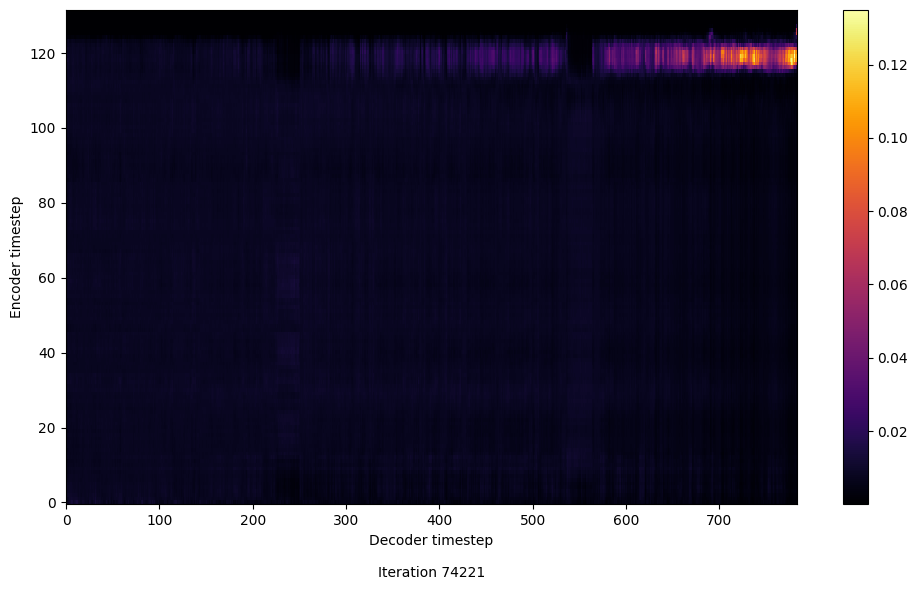

current learning rate :  [0.0001]
Epoch [34/250] completed in 7038.75s

Starting Epoch: 35/250


  0%|          | 1/2183 [00:02<1:25:37,  2.35s/it]

Epoch [35/250], Step [1/2183], Total Loss: 0.624293, Student Loss: 0.953121, Teacher Loss: 0.267375, Distillation Loss: 0.295464, Gradient Norm: 1.66, Learning Rate: 0.00010000, Duration: 2.35s


  1%|          | 11/2183 [00:27<1:32:17,  2.55s/it]

Epoch [35/250], Step [11/2183], Total Loss: 0.553827, Student Loss: 0.846789, Teacher Loss: 0.259112, Distillation Loss: 0.260865, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.35s


  1%|          | 21/2183 [00:55<1:37:53,  2.72s/it]

Epoch [35/250], Step [21/2183], Total Loss: 0.561338, Student Loss: 0.857288, Teacher Loss: 0.265420, Distillation Loss: 0.265388, Gradient Norm: 1.47, Learning Rate: 0.00010000, Duration: 2.63s


  1%|▏         | 31/2183 [01:19<1:27:49,  2.45s/it]

Epoch [35/250], Step [31/2183], Total Loss: 0.640767, Student Loss: 0.979712, Teacher Loss: 0.297229, Distillation Loss: 0.301822, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.63s


  2%|▏         | 41/2183 [01:46<1:38:11,  2.75s/it]

Epoch [35/250], Step [41/2183], Total Loss: 0.563064, Student Loss: 0.859919, Teacher Loss: 0.284119, Distillation Loss: 0.266209, Gradient Norm: 0.97, Learning Rate: 0.00010000, Duration: 2.76s


  2%|▏         | 51/2183 [02:12<1:36:43,  2.72s/it]

Epoch [35/250], Step [51/2183], Total Loss: 0.633061, Student Loss: 0.968464, Teacher Loss: 0.290997, Distillation Loss: 0.297658, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.79s


  3%|▎         | 61/2183 [02:38<1:35:10,  2.69s/it]

Epoch [35/250], Step [61/2183], Total Loss: 0.501602, Student Loss: 0.767419, Teacher Loss: 0.245593, Distillation Loss: 0.235786, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.67s


  3%|▎         | 71/2183 [03:05<1:31:37,  2.60s/it]

Epoch [35/250], Step [71/2183], Total Loss: 0.457506, Student Loss: 0.698587, Teacher Loss: 0.225645, Distillation Loss: 0.216426, Gradient Norm: 0.68, Learning Rate: 0.00010000, Duration: 2.51s


  4%|▎         | 81/2183 [03:32<1:34:31,  2.70s/it]

Epoch [35/250], Step [81/2183], Total Loss: 0.606089, Student Loss: 0.926115, Teacher Loss: 0.310372, Distillation Loss: 0.286063, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.68s


  4%|▍         | 91/2183 [03:58<1:32:30,  2.65s/it]

Epoch [35/250], Step [91/2183], Total Loss: 0.635045, Student Loss: 0.973595, Teacher Loss: 0.316885, Distillation Loss: 0.296495, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.60s


  5%|▍         | 101/2183 [04:25<1:31:57,  2.65s/it]

Epoch [35/250], Step [101/2183], Total Loss: 0.534374, Student Loss: 0.817209, Teacher Loss: 0.247386, Distillation Loss: 0.251538, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.64s


  5%|▌         | 111/2183 [04:51<1:29:16,  2.59s/it]

Epoch [35/250], Step [111/2183], Total Loss: 0.675464, Student Loss: 1.032745, Teacher Loss: 0.316800, Distillation Loss: 0.318182, Gradient Norm: 1.17, Learning Rate: 0.00010000, Duration: 2.37s


  6%|▌         | 121/2183 [05:18<1:29:41,  2.61s/it]

Epoch [35/250], Step [121/2183], Total Loss: 0.478386, Student Loss: 0.728103, Teacher Loss: 0.217960, Distillation Loss: 0.228668, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.53s


  6%|▌         | 131/2183 [05:45<1:28:52,  2.60s/it]

Epoch [35/250], Step [131/2183], Total Loss: 0.605888, Student Loss: 0.933958, Teacher Loss: 0.289549, Distillation Loss: 0.277817, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.37s


  6%|▋         | 141/2183 [06:11<1:31:14,  2.68s/it]

Epoch [35/250], Step [141/2183], Total Loss: 0.511211, Student Loss: 0.782372, Teacher Loss: 0.233652, Distillation Loss: 0.240049, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.47s


  7%|▋         | 151/2183 [06:38<1:32:30,  2.73s/it]

Epoch [35/250], Step [151/2183], Total Loss: 0.515608, Student Loss: 0.791185, Teacher Loss: 0.252927, Distillation Loss: 0.240031, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.91s


  7%|▋         | 161/2183 [07:03<1:24:20,  2.50s/it]

Epoch [35/250], Step [161/2183], Total Loss: 0.488537, Student Loss: 0.752300, Teacher Loss: 0.287701, Distillation Loss: 0.224773, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.83s


  8%|▊         | 171/2183 [07:29<1:27:26,  2.61s/it]

Epoch [35/250], Step [171/2183], Total Loss: 0.659097, Student Loss: 1.005769, Teacher Loss: 0.321024, Distillation Loss: 0.312425, Gradient Norm: 1.36, Learning Rate: 0.00010000, Duration: 2.75s


  8%|▊         | 181/2183 [07:55<1:28:45,  2.66s/it]

Epoch [35/250], Step [181/2183], Total Loss: 0.497183, Student Loss: 0.756907, Teacher Loss: 0.261199, Distillation Loss: 0.237459, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.69s


  9%|▊         | 191/2183 [08:22<1:26:33,  2.61s/it]

Epoch [35/250], Step [191/2183], Total Loss: 0.586790, Student Loss: 0.895860, Teacher Loss: 0.276723, Distillation Loss: 0.277719, Gradient Norm: 1.63, Learning Rate: 0.00010000, Duration: 2.62s


  9%|▉         | 201/2183 [08:47<1:23:57,  2.54s/it]

Epoch [35/250], Step [201/2183], Total Loss: 0.666022, Student Loss: 1.026106, Teacher Loss: 0.320731, Distillation Loss: 0.305938, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.68s


 10%|▉         | 211/2183 [09:12<1:27:11,  2.65s/it]

Epoch [35/250], Step [211/2183], Total Loss: 0.494502, Student Loss: 0.757023, Teacher Loss: 0.248710, Distillation Loss: 0.231982, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 2.73s


 10%|█         | 221/2183 [09:39<1:26:55,  2.66s/it]

Epoch [35/250], Step [221/2183], Total Loss: 0.560168, Student Loss: 0.859877, Teacher Loss: 0.274673, Distillation Loss: 0.260458, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.69s


 11%|█         | 231/2183 [10:05<1:20:28,  2.47s/it]

Epoch [35/250], Step [231/2183], Total Loss: 0.559109, Student Loss: 0.856318, Teacher Loss: 0.278131, Distillation Loss: 0.261900, Gradient Norm: 1.29, Learning Rate: 0.00010000, Duration: 2.54s


 11%|█         | 241/2183 [10:31<1:25:58,  2.66s/it]

Epoch [35/250], Step [241/2183], Total Loss: 0.518963, Student Loss: 0.791677, Teacher Loss: 0.264584, Distillation Loss: 0.246249, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.88s


 11%|█▏        | 251/2183 [10:57<1:23:19,  2.59s/it]

Epoch [35/250], Step [251/2183], Total Loss: 0.506137, Student Loss: 0.775124, Teacher Loss: 0.242228, Distillation Loss: 0.237151, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.56s


 12%|█▏        | 261/2183 [11:25<1:31:16,  2.85s/it]

Epoch [35/250], Step [261/2183], Total Loss: 0.453961, Student Loss: 0.690715, Teacher Loss: 0.198210, Distillation Loss: 0.217207, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 3.11s


 12%|█▏        | 271/2183 [11:52<1:21:20,  2.55s/it]

Epoch [35/250], Step [271/2183], Total Loss: 0.551237, Student Loss: 0.838068, Teacher Loss: 0.226541, Distillation Loss: 0.264406, Gradient Norm: 1.51, Learning Rate: 0.00010000, Duration: 1.98s


 13%|█▎        | 281/2183 [12:19<1:24:24,  2.66s/it]

Epoch [35/250], Step [281/2183], Total Loss: 0.443837, Student Loss: 0.675236, Teacher Loss: 0.232813, Distillation Loss: 0.212438, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.44s


 13%|█▎        | 291/2183 [12:44<1:21:34,  2.59s/it]

Epoch [35/250], Step [291/2183], Total Loss: 0.529935, Student Loss: 0.813011, Teacher Loss: 0.245172, Distillation Loss: 0.246859, Gradient Norm: 1.02, Learning Rate: 0.00010000, Duration: 2.64s


 14%|█▍        | 301/2183 [13:10<1:24:01,  2.68s/it]

Epoch [35/250], Step [301/2183], Total Loss: 0.580189, Student Loss: 0.891318, Teacher Loss: 0.296657, Distillation Loss: 0.269061, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.92s


 14%|█▍        | 311/2183 [13:37<1:23:25,  2.67s/it]

Epoch [35/250], Step [311/2183], Total Loss: 0.516570, Student Loss: 0.789228, Teacher Loss: 0.237651, Distillation Loss: 0.243913, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.73s


 15%|█▍        | 321/2183 [14:04<1:21:22,  2.62s/it]

Epoch [35/250], Step [321/2183], Total Loss: 0.613892, Student Loss: 0.940528, Teacher Loss: 0.293164, Distillation Loss: 0.287257, Gradient Norm: 2.09, Learning Rate: 0.00010000, Duration: 2.42s


 15%|█▌        | 331/2183 [14:28<1:11:08,  2.30s/it]

Epoch [35/250], Step [331/2183], Total Loss: 0.565345, Student Loss: 0.865425, Teacher Loss: 0.260198, Distillation Loss: 0.265265, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 1.80s


 16%|█▌        | 341/2183 [14:55<1:20:45,  2.63s/it]

Epoch [35/250], Step [341/2183], Total Loss: 0.474548, Student Loss: 0.726853, Teacher Loss: 0.228959, Distillation Loss: 0.222244, Gradient Norm: 1.32, Learning Rate: 0.00010000, Duration: 2.63s


 16%|█▌        | 351/2183 [15:21<1:21:41,  2.68s/it]

Epoch [35/250], Step [351/2183], Total Loss: 0.531047, Student Loss: 0.811922, Teacher Loss: 0.269848, Distillation Loss: 0.250171, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.87s


 17%|█▋        | 361/2183 [15:47<1:18:03,  2.57s/it]

Epoch [35/250], Step [361/2183], Total Loss: 0.522774, Student Loss: 0.797693, Teacher Loss: 0.238558, Distillation Loss: 0.247854, Gradient Norm: 1.49, Learning Rate: 0.00010000, Duration: 2.37s


 17%|█▋        | 371/2183 [16:12<1:18:35,  2.60s/it]

Epoch [35/250], Step [371/2183], Total Loss: 0.623073, Student Loss: 0.956666, Teacher Loss: 0.285002, Distillation Loss: 0.289481, Gradient Norm: 1.58, Learning Rate: 0.00010000, Duration: 2.49s


 17%|█▋        | 381/2183 [16:39<1:19:17,  2.64s/it]

Epoch [35/250], Step [381/2183], Total Loss: 0.602078, Student Loss: 0.924906, Teacher Loss: 0.302362, Distillation Loss: 0.279251, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.78s


 18%|█▊        | 391/2183 [17:04<1:18:08,  2.62s/it]

Epoch [35/250], Step [391/2183], Total Loss: 0.543855, Student Loss: 0.830532, Teacher Loss: 0.261072, Distillation Loss: 0.257178, Gradient Norm: 1.33, Learning Rate: 0.00010000, Duration: 2.67s


 18%|█▊        | 401/2183 [17:30<1:14:18,  2.50s/it]

Epoch [35/250], Step [401/2183], Total Loss: 0.580968, Student Loss: 0.890239, Teacher Loss: 0.285194, Distillation Loss: 0.271697, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.48s


 19%|█▉        | 411/2183 [17:55<1:18:26,  2.66s/it]

Epoch [35/250], Step [411/2183], Total Loss: 0.513004, Student Loss: 0.784471, Teacher Loss: 0.241977, Distillation Loss: 0.241538, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.68s


 19%|█▉        | 421/2183 [18:20<1:11:38,  2.44s/it]

Epoch [35/250], Step [421/2183], Total Loss: 0.607851, Student Loss: 0.931897, Teacher Loss: 0.303996, Distillation Loss: 0.283806, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.34s


 20%|█▉        | 431/2183 [18:45<1:17:24,  2.65s/it]

Epoch [35/250], Step [431/2183], Total Loss: 0.534088, Student Loss: 0.813807, Teacher Loss: 0.252767, Distillation Loss: 0.254370, Gradient Norm: 1.98, Learning Rate: 0.00010000, Duration: 2.88s


 20%|██        | 441/2183 [19:10<1:11:11,  2.45s/it]

Epoch [35/250], Step [441/2183], Total Loss: 0.492418, Student Loss: 0.753029, Teacher Loss: 0.210921, Distillation Loss: 0.231808, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.38s


 21%|██        | 451/2183 [19:35<1:12:29,  2.51s/it]

Epoch [35/250], Step [451/2183], Total Loss: 0.546833, Student Loss: 0.832314, Teacher Loss: 0.259409, Distillation Loss: 0.261352, Gradient Norm: 1.15, Learning Rate: 0.00010000, Duration: 2.44s


 21%|██        | 461/2183 [20:02<1:19:18,  2.76s/it]

Epoch [35/250], Step [461/2183], Total Loss: 0.566675, Student Loss: 0.866428, Teacher Loss: 0.286081, Distillation Loss: 0.266922, Gradient Norm: 1.22, Learning Rate: 0.00010000, Duration: 2.87s


 22%|██▏       | 471/2183 [20:28<1:15:34,  2.65s/it]

Epoch [35/250], Step [471/2183], Total Loss: 0.564995, Student Loss: 0.861781, Teacher Loss: 0.280635, Distillation Loss: 0.268209, Gradient Norm: 2.30, Learning Rate: 0.00010000, Duration: 2.73s


 22%|██▏       | 481/2183 [20:55<1:17:07,  2.72s/it]

Epoch [35/250], Step [481/2183], Total Loss: 0.575813, Student Loss: 0.876530, Teacher Loss: 0.298747, Distillation Loss: 0.275097, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.79s


 22%|██▏       | 491/2183 [21:22<1:15:48,  2.69s/it]

Epoch [35/250], Step [491/2183], Total Loss: 0.612463, Student Loss: 0.933527, Teacher Loss: 0.294095, Distillation Loss: 0.291400, Gradient Norm: 1.54, Learning Rate: 0.00010000, Duration: 2.56s


 23%|██▎       | 501/2183 [21:49<1:11:28,  2.55s/it]

Epoch [35/250], Step [501/2183], Total Loss: 0.593472, Student Loss: 0.909580, Teacher Loss: 0.305341, Distillation Loss: 0.277364, Gradient Norm: 1.61, Learning Rate: 0.00010000, Duration: 2.34s


 23%|██▎       | 511/2183 [22:16<1:17:11,  2.77s/it]

Epoch [35/250], Step [511/2183], Total Loss: 0.551646, Student Loss: 0.839850, Teacher Loss: 0.290129, Distillation Loss: 0.263442, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.74s


 24%|██▍       | 521/2183 [22:43<1:16:12,  2.75s/it]

Epoch [35/250], Step [521/2183], Total Loss: 0.587050, Student Loss: 0.901129, Teacher Loss: 0.291818, Distillation Loss: 0.272971, Gradient Norm: 1.40, Learning Rate: 0.00010000, Duration: 2.75s


 24%|██▍       | 531/2183 [23:10<1:11:31,  2.60s/it]

Epoch [35/250], Step [531/2183], Total Loss: 0.611817, Student Loss: 0.938496, Teacher Loss: 0.296711, Distillation Loss: 0.285139, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.15s


 25%|██▍       | 541/2183 [23:36<1:10:02,  2.56s/it]

Epoch [35/250], Step [541/2183], Total Loss: 0.576686, Student Loss: 0.880827, Teacher Loss: 0.266851, Distillation Loss: 0.272545, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.71s


 25%|██▌       | 551/2183 [24:02<1:10:33,  2.59s/it]

Epoch [35/250], Step [551/2183], Total Loss: 0.507254, Student Loss: 0.777497, Teacher Loss: 0.236303, Distillation Loss: 0.237012, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.40s


 26%|██▌       | 561/2183 [24:28<1:11:29,  2.64s/it]

Epoch [35/250], Step [561/2183], Total Loss: 0.594529, Student Loss: 0.905680, Teacher Loss: 0.283073, Distillation Loss: 0.283378, Gradient Norm: 1.63, Learning Rate: 0.00010000, Duration: 2.80s


 26%|██▌       | 571/2183 [24:54<1:10:14,  2.61s/it]

Epoch [35/250], Step [571/2183], Total Loss: 0.473203, Student Loss: 0.723940, Teacher Loss: 0.233650, Distillation Loss: 0.222465, Gradient Norm: 0.78, Learning Rate: 0.00010000, Duration: 2.70s


 27%|██▋       | 581/2183 [25:21<1:08:38,  2.57s/it]

Epoch [35/250], Step [581/2183], Total Loss: 0.526330, Student Loss: 0.806154, Teacher Loss: 0.245483, Distillation Loss: 0.246507, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.43s


 27%|██▋       | 591/2183 [25:46<1:08:03,  2.56s/it]

Epoch [35/250], Step [591/2183], Total Loss: 0.582841, Student Loss: 0.893386, Teacher Loss: 0.277112, Distillation Loss: 0.272297, Gradient Norm: 1.42, Learning Rate: 0.00010000, Duration: 2.73s


 28%|██▊       | 601/2183 [26:13<1:12:08,  2.74s/it]

Epoch [35/250], Step [601/2183], Total Loss: 0.551687, Student Loss: 0.845311, Teacher Loss: 0.291700, Distillation Loss: 0.258064, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.67s


 28%|██▊       | 611/2183 [26:41<1:11:41,  2.74s/it]

Epoch [35/250], Step [611/2183], Total Loss: 0.578575, Student Loss: 0.886113, Teacher Loss: 0.270656, Distillation Loss: 0.271036, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.65s


 28%|██▊       | 621/2183 [27:07<1:12:26,  2.78s/it]

Epoch [35/250], Step [621/2183], Total Loss: 0.557733, Student Loss: 0.852947, Teacher Loss: 0.283573, Distillation Loss: 0.262519, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.73s


 29%|██▉       | 631/2183 [27:34<1:09:27,  2.69s/it]

Epoch [35/250], Step [631/2183], Total Loss: 0.632631, Student Loss: 0.968647, Teacher Loss: 0.310158, Distillation Loss: 0.296615, Gradient Norm: 0.88, Learning Rate: 0.00010000, Duration: 2.61s


 29%|██▉       | 641/2183 [28:01<1:07:09,  2.61s/it]

Epoch [35/250], Step [641/2183], Total Loss: 0.593500, Student Loss: 0.897771, Teacher Loss: 0.241926, Distillation Loss: 0.289229, Gradient Norm: 4.18, Learning Rate: 0.00010000, Duration: 2.65s


 30%|██▉       | 651/2183 [28:28<1:04:01,  2.51s/it]

Epoch [35/250], Step [651/2183], Total Loss: 0.534049, Student Loss: 0.815835, Teacher Loss: 0.243882, Distillation Loss: 0.252264, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.13s


 30%|███       | 661/2183 [28:54<1:06:25,  2.62s/it]

Epoch [35/250], Step [661/2183], Total Loss: 0.443020, Student Loss: 0.674736, Teacher Loss: 0.228680, Distillation Loss: 0.211304, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.74s


 31%|███       | 671/2183 [29:20<1:03:40,  2.53s/it]

Epoch [35/250], Step [671/2183], Total Loss: 0.497599, Student Loss: 0.752098, Teacher Loss: 0.336003, Distillation Loss: 0.243101, Gradient Norm: 0.70, Learning Rate: 0.00010000, Duration: 2.49s


 31%|███       | 681/2183 [29:47<1:06:32,  2.66s/it]

Epoch [35/250], Step [681/2183], Total Loss: 0.573937, Student Loss: 0.872004, Teacher Loss: 0.263651, Distillation Loss: 0.275871, Gradient Norm: 1.81, Learning Rate: 0.00010000, Duration: 2.72s


 32%|███▏      | 691/2183 [30:11<1:01:46,  2.48s/it]

Epoch [35/250], Step [691/2183], Total Loss: 0.564565, Student Loss: 0.864120, Teacher Loss: 0.270555, Distillation Loss: 0.265010, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.68s


 32%|███▏      | 701/2183 [30:37<1:02:31,  2.53s/it]

Epoch [35/250], Step [701/2183], Total Loss: 0.523471, Student Loss: 0.800430, Teacher Loss: 0.240811, Distillation Loss: 0.246513, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.51s


 33%|███▎      | 711/2183 [31:04<1:06:26,  2.71s/it]

Epoch [35/250], Step [711/2183], Total Loss: 0.544257, Student Loss: 0.831175, Teacher Loss: 0.247739, Distillation Loss: 0.257338, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.58s


 33%|███▎      | 721/2183 [31:30<59:35,  2.45s/it]  

Epoch [35/250], Step [721/2183], Total Loss: 0.637650, Student Loss: 0.971539, Teacher Loss: 0.293606, Distillation Loss: 0.303762, Gradient Norm: 1.23, Learning Rate: 0.00010000, Duration: 1.97s


 33%|███▎      | 731/2183 [31:56<1:06:23,  2.74s/it]

Epoch [35/250], Step [731/2183], Total Loss: 0.530398, Student Loss: 0.813084, Teacher Loss: 0.248429, Distillation Loss: 0.247712, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.72s


 34%|███▍      | 741/2183 [32:21<56:28,  2.35s/it]  

Epoch [35/250], Step [741/2183], Total Loss: 0.661540, Student Loss: 1.010650, Teacher Loss: 0.321303, Distillation Loss: 0.312430, Gradient Norm: 1.76, Learning Rate: 0.00010000, Duration: 2.15s


 34%|███▍      | 751/2183 [32:47<1:04:20,  2.70s/it]

Epoch [35/250], Step [751/2183], Total Loss: 0.534400, Student Loss: 0.816522, Teacher Loss: 0.240248, Distillation Loss: 0.252278, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.83s


 35%|███▍      | 761/2183 [33:13<1:00:23,  2.55s/it]

Epoch [35/250], Step [761/2183], Total Loss: 0.467219, Student Loss: 0.711533, Teacher Loss: 0.230635, Distillation Loss: 0.222905, Gradient Norm: 0.77, Learning Rate: 0.00010000, Duration: 2.49s


 35%|███▌      | 771/2183 [33:40<1:00:56,  2.59s/it]

Epoch [35/250], Step [771/2183], Total Loss: 0.700819, Student Loss: 1.073262, Teacher Loss: 0.321815, Distillation Loss: 0.328376, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.60s


 36%|███▌      | 781/2183 [34:06<1:01:41,  2.64s/it]

Epoch [35/250], Step [781/2183], Total Loss: 0.638732, Student Loss: 0.977842, Teacher Loss: 0.302970, Distillation Loss: 0.299622, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.64s


 36%|███▌      | 791/2183 [34:33<1:02:08,  2.68s/it]

Epoch [35/250], Step [791/2183], Total Loss: 0.614688, Student Loss: 0.943525, Teacher Loss: 0.317771, Distillation Loss: 0.285851, Gradient Norm: 1.43, Learning Rate: 0.00010000, Duration: 2.65s


 37%|███▋      | 801/2183 [34:59<1:02:37,  2.72s/it]

Epoch [35/250], Step [801/2183], Total Loss: 0.436845, Student Loss: 0.668033, Teacher Loss: 0.236733, Distillation Loss: 0.205657, Gradient Norm: 0.61, Learning Rate: 0.00010000, Duration: 2.82s


 37%|███▋      | 811/2183 [35:23<58:05,  2.54s/it]  

Epoch [35/250], Step [811/2183], Total Loss: 0.630627, Student Loss: 0.963976, Teacher Loss: 0.292315, Distillation Loss: 0.297277, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.43s


 38%|███▊      | 821/2183 [35:51<1:02:59,  2.78s/it]

Epoch [35/250], Step [821/2183], Total Loss: 0.498421, Student Loss: 0.760363, Teacher Loss: 0.251495, Distillation Loss: 0.236479, Gradient Norm: 0.70, Learning Rate: 0.00010000, Duration: 2.80s


 38%|███▊      | 831/2183 [36:17<57:07,  2.53s/it]  

Epoch [35/250], Step [831/2183], Total Loss: 0.429873, Student Loss: 0.656255, Teacher Loss: 0.204348, Distillation Loss: 0.203492, Gradient Norm: 0.80, Learning Rate: 0.00010000, Duration: 2.47s


 39%|███▊      | 841/2183 [36:43<1:00:59,  2.73s/it]

Epoch [35/250], Step [841/2183], Total Loss: 0.508573, Student Loss: 0.778161, Teacher Loss: 0.242812, Distillation Loss: 0.238986, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.64s


 39%|███▉      | 851/2183 [37:11<59:17,  2.67s/it]  

Epoch [35/250], Step [851/2183], Total Loss: 0.608832, Student Loss: 0.930353, Teacher Loss: 0.308718, Distillation Loss: 0.287312, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.49s


 39%|███▉      | 861/2183 [37:38<59:36,  2.71s/it]  

Epoch [35/250], Step [861/2183], Total Loss: 0.569028, Student Loss: 0.866138, Teacher Loss: 0.271188, Distillation Loss: 0.271918, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.66s


 40%|███▉      | 871/2183 [38:04<55:59,  2.56s/it]  

Epoch [35/250], Step [871/2183], Total Loss: 0.613121, Student Loss: 0.936266, Teacher Loss: 0.303483, Distillation Loss: 0.289976, Gradient Norm: 1.17, Learning Rate: 0.00010000, Duration: 2.64s


 40%|████      | 881/2183 [38:30<59:14,  2.73s/it]

Epoch [35/250], Step [881/2183], Total Loss: 0.604525, Student Loss: 0.915751, Teacher Loss: 0.318755, Distillation Loss: 0.293299, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.81s


 41%|████      | 891/2183 [38:56<57:17,  2.66s/it]

Epoch [35/250], Step [891/2183], Total Loss: 0.508622, Student Loss: 0.774726, Teacher Loss: 0.233243, Distillation Loss: 0.242518, Gradient Norm: 0.84, Learning Rate: 0.00010000, Duration: 2.40s


 41%|████▏     | 901/2183 [39:23<58:52,  2.76s/it]

Epoch [35/250], Step [901/2183], Total Loss: 0.539950, Student Loss: 0.828417, Teacher Loss: 0.277798, Distillation Loss: 0.251482, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.76s


 42%|████▏     | 911/2183 [39:49<56:55,  2.69s/it]

Epoch [35/250], Step [911/2183], Total Loss: 0.642000, Student Loss: 0.980659, Teacher Loss: 0.312040, Distillation Loss: 0.303341, Gradient Norm: 1.75, Learning Rate: 0.00010000, Duration: 2.67s


 42%|████▏     | 921/2183 [40:16<58:03,  2.76s/it]

Epoch [35/250], Step [921/2183], Total Loss: 0.599629, Student Loss: 0.923447, Teacher Loss: 0.297929, Distillation Loss: 0.275811, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.80s


 43%|████▎     | 931/2183 [40:42<53:39,  2.57s/it]

Epoch [35/250], Step [931/2183], Total Loss: 0.582435, Student Loss: 0.884824, Teacher Loss: 0.299101, Distillation Loss: 0.280047, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.45s


 43%|████▎     | 941/2183 [41:08<53:03,  2.56s/it]

Epoch [35/250], Step [941/2183], Total Loss: 0.563913, Student Loss: 0.864263, Teacher Loss: 0.261843, Distillation Loss: 0.263564, Gradient Norm: 0.98, Learning Rate: 0.00010000, Duration: 2.46s


 44%|████▎     | 951/2183 [41:35<52:42,  2.57s/it]

Epoch [35/250], Step [951/2183], Total Loss: 0.628815, Student Loss: 0.964870, Teacher Loss: 0.325204, Distillation Loss: 0.292760, Gradient Norm: 1.14, Learning Rate: 0.00010000, Duration: 2.45s


 44%|████▍     | 961/2183 [42:01<55:40,  2.73s/it]

Epoch [35/250], Step [961/2183], Total Loss: 0.631737, Student Loss: 0.965463, Teacher Loss: 0.290125, Distillation Loss: 0.298011, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.74s


 44%|████▍     | 971/2183 [42:25<48:27,  2.40s/it]

Epoch [35/250], Step [971/2183], Total Loss: 0.645406, Student Loss: 0.988233, Teacher Loss: 0.315444, Distillation Loss: 0.302580, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.39s


 45%|████▍     | 981/2183 [42:51<50:55,  2.54s/it]

Epoch [35/250], Step [981/2183], Total Loss: 0.606768, Student Loss: 0.926318, Teacher Loss: 0.294541, Distillation Loss: 0.287219, Gradient Norm: 1.20, Learning Rate: 0.00010000, Duration: 2.61s


 45%|████▌     | 991/2183 [43:17<52:26,  2.64s/it]

Epoch [35/250], Step [991/2183], Total Loss: 0.436885, Student Loss: 0.665642, Teacher Loss: 0.211960, Distillation Loss: 0.208128, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.74s


 46%|████▌     | 1001/2183 [43:43<51:04,  2.59s/it]

Epoch [35/250], Step [1001/2183], Total Loss: 0.574015, Student Loss: 0.876829, Teacher Loss: 0.253116, Distillation Loss: 0.271200, Gradient Norm: 1.98, Learning Rate: 0.00010000, Duration: 2.66s


 46%|████▋     | 1011/2183 [44:08<51:15,  2.62s/it]

Epoch [35/250], Step [1011/2183], Total Loss: 0.527371, Student Loss: 0.807752, Teacher Loss: 0.257151, Distillation Loss: 0.246989, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.71s


 47%|████▋     | 1021/2183 [44:35<51:27,  2.66s/it]

Epoch [35/250], Step [1021/2183], Total Loss: 0.620336, Student Loss: 0.952652, Teacher Loss: 0.291797, Distillation Loss: 0.288021, Gradient Norm: 1.18, Learning Rate: 0.00010000, Duration: 2.40s


 47%|████▋     | 1031/2183 [45:01<48:20,  2.52s/it]

Epoch [35/250], Step [1031/2183], Total Loss: 0.579725, Student Loss: 0.887538, Teacher Loss: 0.302504, Distillation Loss: 0.271912, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.22s


 48%|████▊     | 1041/2183 [45:29<52:36,  2.76s/it]

Epoch [35/250], Step [1041/2183], Total Loss: 0.577869, Student Loss: 0.886130, Teacher Loss: 0.285272, Distillation Loss: 0.269608, Gradient Norm: 1.29, Learning Rate: 0.00010000, Duration: 2.81s


 48%|████▊     | 1051/2183 [45:55<47:10,  2.50s/it]

Epoch [35/250], Step [1051/2183], Total Loss: 0.615506, Student Loss: 0.939901, Teacher Loss: 0.307982, Distillation Loss: 0.291111, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.35s


 49%|████▊     | 1061/2183 [46:21<49:51,  2.67s/it]

Epoch [35/250], Step [1061/2183], Total Loss: 0.543380, Student Loss: 0.831655, Teacher Loss: 0.247313, Distillation Loss: 0.255105, Gradient Norm: 1.70, Learning Rate: 0.00010000, Duration: 2.75s


 49%|████▉     | 1071/2183 [46:48<48:22,  2.61s/it]

Epoch [35/250], Step [1071/2183], Total Loss: 0.627741, Student Loss: 0.961566, Teacher Loss: 0.324246, Distillation Loss: 0.293915, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.53s


 50%|████▉     | 1081/2183 [47:15<50:00,  2.72s/it]

Epoch [35/250], Step [1081/2183], Total Loss: 0.495223, Student Loss: 0.755292, Teacher Loss: 0.217802, Distillation Loss: 0.235153, Gradient Norm: 1.16, Learning Rate: 0.00010000, Duration: 2.96s


 50%|████▉     | 1091/2183 [47:41<47:58,  2.64s/it]

Epoch [35/250], Step [1091/2183], Total Loss: 0.527521, Student Loss: 0.803732, Teacher Loss: 0.238887, Distillation Loss: 0.251310, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.86s


 50%|█████     | 1101/2183 [48:06<45:40,  2.53s/it]

Epoch [35/250], Step [1101/2183], Total Loss: 0.577824, Student Loss: 0.886437, Teacher Loss: 0.286592, Distillation Loss: 0.269212, Gradient Norm: 1.34, Learning Rate: 0.00010000, Duration: 2.66s


 51%|█████     | 1111/2183 [48:31<42:55,  2.40s/it]

Epoch [35/250], Step [1111/2183], Total Loss: 0.597813, Student Loss: 0.913701, Teacher Loss: 0.265641, Distillation Loss: 0.281925, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.14s


 51%|█████▏    | 1121/2183 [48:57<44:27,  2.51s/it]

Epoch [35/250], Step [1121/2183], Total Loss: 0.546365, Student Loss: 0.837115, Teacher Loss: 0.254511, Distillation Loss: 0.255614, Gradient Norm: 1.04, Learning Rate: 0.00010000, Duration: 2.39s


 52%|█████▏    | 1131/2183 [49:23<43:56,  2.51s/it]

Epoch [35/250], Step [1131/2183], Total Loss: 0.691096, Student Loss: 1.058740, Teacher Loss: 0.309652, Distillation Loss: 0.323453, Gradient Norm: 4.88, Learning Rate: 0.00010000, Duration: 2.13s


 52%|█████▏    | 1141/2183 [49:50<46:33,  2.68s/it]

Epoch [35/250], Step [1141/2183], Total Loss: 0.490795, Student Loss: 0.751224, Teacher Loss: 0.239044, Distillation Loss: 0.230366, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.74s


 53%|█████▎    | 1151/2183 [50:15<43:41,  2.54s/it]

Epoch [35/250], Step [1151/2183], Total Loss: 0.513979, Student Loss: 0.785082, Teacher Loss: 0.240974, Distillation Loss: 0.242876, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.50s


 53%|█████▎    | 1161/2183 [50:41<43:51,  2.57s/it]

Epoch [35/250], Step [1161/2183], Total Loss: 0.479010, Student Loss: 0.733149, Teacher Loss: 0.227465, Distillation Loss: 0.224870, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.83s


 54%|█████▎    | 1171/2183 [51:07<45:46,  2.71s/it]

Epoch [35/250], Step [1171/2183], Total Loss: 0.560061, Student Loss: 0.858667, Teacher Loss: 0.270256, Distillation Loss: 0.261456, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.68s


 54%|█████▍    | 1181/2183 [51:33<41:11,  2.47s/it]

Epoch [35/250], Step [1181/2183], Total Loss: 0.588964, Student Loss: 0.901436, Teacher Loss: 0.344515, Distillation Loss: 0.276492, Gradient Norm: 1.10, Learning Rate: 0.00010000, Duration: 2.24s


 55%|█████▍    | 1191/2183 [51:59<43:39,  2.64s/it]

Epoch [35/250], Step [1191/2183], Total Loss: 0.566118, Student Loss: 0.862245, Teacher Loss: 0.293071, Distillation Loss: 0.269991, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.81s


 55%|█████▌    | 1201/2183 [52:26<44:22,  2.71s/it]

Epoch [35/250], Step [1201/2183], Total Loss: 0.474613, Student Loss: 0.725176, Teacher Loss: 0.216440, Distillation Loss: 0.224050, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.67s


 55%|█████▌    | 1211/2183 [52:53<44:06,  2.72s/it]

Epoch [35/250], Step [1211/2183], Total Loss: 0.548096, Student Loss: 0.837466, Teacher Loss: 0.282046, Distillation Loss: 0.258727, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.71s


 56%|█████▌    | 1221/2183 [53:20<41:46,  2.61s/it]

Epoch [35/250], Step [1221/2183], Total Loss: 0.640184, Student Loss: 0.979389, Teacher Loss: 0.342529, Distillation Loss: 0.300979, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.26s


 56%|█████▋    | 1231/2183 [53:46<41:36,  2.62s/it]

Epoch [35/250], Step [1231/2183], Total Loss: 0.613344, Student Loss: 0.941033, Teacher Loss: 0.283406, Distillation Loss: 0.285654, Gradient Norm: 1.82, Learning Rate: 0.00010000, Duration: 2.71s


 57%|█████▋    | 1241/2183 [54:12<40:30,  2.58s/it]

Epoch [35/250], Step [1241/2183], Total Loss: 0.589817, Student Loss: 0.904208, Teacher Loss: 0.275706, Distillation Loss: 0.275426, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 2.31s


 57%|█████▋    | 1251/2183 [54:38<39:51,  2.57s/it]

Epoch [35/250], Step [1251/2183], Total Loss: 0.572744, Student Loss: 0.875326, Teacher Loss: 0.269690, Distillation Loss: 0.270162, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.74s


 58%|█████▊    | 1261/2183 [55:04<41:22,  2.69s/it]

Epoch [35/250], Step [1261/2183], Total Loss: 0.542969, Student Loss: 0.825730, Teacher Loss: 0.244765, Distillation Loss: 0.260208, Gradient Norm: 1.85, Learning Rate: 0.00010000, Duration: 2.69s


 58%|█████▊    | 1271/2183 [55:30<39:45,  2.62s/it]

Epoch [35/250], Step [1271/2183], Total Loss: 0.571700, Student Loss: 0.875292, Teacher Loss: 0.276621, Distillation Loss: 0.268108, Gradient Norm: 1.38, Learning Rate: 0.00010000, Duration: 2.59s


 59%|█████▊    | 1281/2183 [55:56<39:05,  2.60s/it]

Epoch [35/250], Step [1281/2183], Total Loss: 0.512190, Student Loss: 0.778466, Teacher Loss: 0.229272, Distillation Loss: 0.245914, Gradient Norm: 1.65, Learning Rate: 0.00010000, Duration: 2.80s


 59%|█████▉    | 1291/2183 [56:22<35:49,  2.41s/it]

Epoch [35/250], Step [1291/2183], Total Loss: 0.640391, Student Loss: 0.976180, Teacher Loss: 0.311119, Distillation Loss: 0.304602, Gradient Norm: 1.83, Learning Rate: 0.00010000, Duration: 2.02s


 60%|█████▉    | 1301/2183 [56:48<40:13,  2.74s/it]

Epoch [35/250], Step [1301/2183], Total Loss: 0.425353, Student Loss: 0.649187, Teacher Loss: 0.197040, Distillation Loss: 0.201519, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 3.09s


 60%|██████    | 1311/2183 [57:14<37:39,  2.59s/it]

Epoch [35/250], Step [1311/2183], Total Loss: 0.561731, Student Loss: 0.852073, Teacher Loss: 0.302579, Distillation Loss: 0.271389, Gradient Norm: 1.62, Learning Rate: 0.00010000, Duration: 2.64s


 61%|██████    | 1321/2183 [57:39<38:16,  2.66s/it]

Epoch [35/250], Step [1321/2183], Total Loss: 0.554289, Student Loss: 0.847414, Teacher Loss: 0.288401, Distillation Loss: 0.261163, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.71s


 61%|██████    | 1331/2183 [58:04<33:35,  2.37s/it]

Epoch [35/250], Step [1331/2183], Total Loss: 0.593538, Student Loss: 0.907492, Teacher Loss: 0.281218, Distillation Loss: 0.279585, Gradient Norm: 2.23, Learning Rate: 0.00010000, Duration: 2.17s


 61%|██████▏   | 1341/2183 [58:30<37:19,  2.66s/it]

Epoch [35/250], Step [1341/2183], Total Loss: 0.597703, Student Loss: 0.912606, Teacher Loss: 0.276270, Distillation Loss: 0.282800, Gradient Norm: 2.51, Learning Rate: 0.00010000, Duration: 2.80s


 62%|██████▏   | 1351/2183 [58:56<35:40,  2.57s/it]

Epoch [35/250], Step [1351/2183], Total Loss: 0.577634, Student Loss: 0.880087, Teacher Loss: 0.309733, Distillation Loss: 0.275181, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.78s


 62%|██████▏   | 1361/2183 [59:21<33:21,  2.44s/it]

Epoch [35/250], Step [1361/2183], Total Loss: 0.451405, Student Loss: 0.693021, Teacher Loss: 0.225052, Distillation Loss: 0.209788, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.82s


 63%|██████▎   | 1371/2183 [59:47<32:07,  2.37s/it]

Epoch [35/250], Step [1371/2183], Total Loss: 0.486915, Student Loss: 0.741152, Teacher Loss: 0.229352, Distillation Loss: 0.232678, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.37s


 63%|██████▎   | 1381/2183 [1:00:13<36:44,  2.75s/it]

Epoch [35/250], Step [1381/2183], Total Loss: 0.500958, Student Loss: 0.764688, Teacher Loss: 0.256854, Distillation Loss: 0.237227, Gradient Norm: 0.74, Learning Rate: 0.00010000, Duration: 3.04s


 64%|██████▎   | 1391/2183 [1:00:41<36:46,  2.79s/it]

Epoch [35/250], Step [1391/2183], Total Loss: 0.564746, Student Loss: 0.865788, Teacher Loss: 0.293999, Distillation Loss: 0.263704, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.87s


 64%|██████▍   | 1401/2183 [1:01:07<33:00,  2.53s/it]

Epoch [35/250], Step [1401/2183], Total Loss: 0.621464, Student Loss: 0.945452, Teacher Loss: 0.316919, Distillation Loss: 0.297476, Gradient Norm: 1.88, Learning Rate: 0.00010000, Duration: 2.29s


 65%|██████▍   | 1411/2183 [1:01:34<33:20,  2.59s/it]

Epoch [35/250], Step [1411/2183], Total Loss: 0.454923, Student Loss: 0.695570, Teacher Loss: 0.226039, Distillation Loss: 0.214276, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.42s


 65%|██████▌   | 1421/2183 [1:02:01<33:54,  2.67s/it]

Epoch [35/250], Step [1421/2183], Total Loss: 0.558561, Student Loss: 0.856524, Teacher Loss: 0.276486, Distillation Loss: 0.260598, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.86s


 66%|██████▌   | 1431/2183 [1:02:28<33:16,  2.65s/it]

Epoch [35/250], Step [1431/2183], Total Loss: 0.446152, Student Loss: 0.681699, Teacher Loss: 0.205202, Distillation Loss: 0.210604, Gradient Norm: 0.81, Learning Rate: 0.00010000, Duration: 2.65s


 66%|██████▌   | 1441/2183 [1:02:53<33:08,  2.68s/it]

Epoch [35/250], Step [1441/2183], Total Loss: 0.474561, Student Loss: 0.726383, Teacher Loss: 0.261531, Distillation Loss: 0.222739, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 3.08s


 66%|██████▋   | 1451/2183 [1:03:19<32:07,  2.63s/it]

Epoch [35/250], Step [1451/2183], Total Loss: 0.523392, Student Loss: 0.798670, Teacher Loss: 0.247044, Distillation Loss: 0.248113, Gradient Norm: 1.90, Learning Rate: 0.00010000, Duration: 2.49s


 67%|██████▋   | 1461/2183 [1:03:44<30:42,  2.55s/it]

Epoch [35/250], Step [1461/2183], Total Loss: 0.518453, Student Loss: 0.792095, Teacher Loss: 0.242410, Distillation Loss: 0.244811, Gradient Norm: 1.30, Learning Rate: 0.00010000, Duration: 2.49s


 67%|██████▋   | 1471/2183 [1:04:11<31:04,  2.62s/it]

Epoch [35/250], Step [1471/2183], Total Loss: 0.540586, Student Loss: 0.826391, Teacher Loss: 0.286598, Distillation Loss: 0.254782, Gradient Norm: 1.26, Learning Rate: 0.00010000, Duration: 2.30s


 68%|██████▊   | 1481/2183 [1:04:36<29:40,  2.54s/it]

Epoch [35/250], Step [1481/2183], Total Loss: 0.484682, Student Loss: 0.744444, Teacher Loss: 0.243217, Distillation Loss: 0.224921, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.51s


 68%|██████▊   | 1491/2183 [1:05:01<29:26,  2.55s/it]

Epoch [35/250], Step [1491/2183], Total Loss: 0.656919, Student Loss: 1.004295, Teacher Loss: 0.292540, Distillation Loss: 0.309543, Gradient Norm: 1.58, Learning Rate: 0.00010000, Duration: 2.68s


 69%|██████▉   | 1501/2183 [1:05:27<30:03,  2.64s/it]

Epoch [35/250], Step [1501/2183], Total Loss: 0.505810, Student Loss: 0.771795, Teacher Loss: 0.232977, Distillation Loss: 0.239825, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.80s


 69%|██████▉   | 1511/2183 [1:05:50<25:46,  2.30s/it]

Epoch [35/250], Step [1511/2183], Total Loss: 0.488383, Student Loss: 0.749006, Teacher Loss: 0.255289, Distillation Loss: 0.227760, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.56s


 70%|██████▉   | 1521/2183 [1:06:17<28:45,  2.61s/it]

Epoch [35/250], Step [1521/2183], Total Loss: 0.495597, Student Loss: 0.759924, Teacher Loss: 0.236787, Distillation Loss: 0.231271, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.70s


 70%|███████   | 1531/2183 [1:06:43<29:13,  2.69s/it]

Epoch [35/250], Step [1531/2183], Total Loss: 0.632619, Student Loss: 0.972095, Teacher Loss: 0.315469, Distillation Loss: 0.293144, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.69s


 71%|███████   | 1541/2183 [1:07:08<27:44,  2.59s/it]

Epoch [35/250], Step [1541/2183], Total Loss: 0.506558, Student Loss: 0.772571, Teacher Loss: 0.244785, Distillation Loss: 0.240546, Gradient Norm: 0.91, Learning Rate: 0.00010000, Duration: 2.52s


 71%|███████   | 1551/2183 [1:07:34<28:26,  2.70s/it]

Epoch [35/250], Step [1551/2183], Total Loss: 0.591778, Student Loss: 0.904924, Teacher Loss: 0.276199, Distillation Loss: 0.278633, Gradient Norm: 1.47, Learning Rate: 0.00010000, Duration: 2.77s


 72%|███████▏  | 1561/2183 [1:08:00<26:30,  2.56s/it]

Epoch [35/250], Step [1561/2183], Total Loss: 0.546038, Student Loss: 0.828910, Teacher Loss: 0.257474, Distillation Loss: 0.263165, Gradient Norm: 1.64, Learning Rate: 0.00010000, Duration: 2.19s


 72%|███████▏  | 1571/2183 [1:08:27<26:24,  2.59s/it]

Epoch [35/250], Step [1571/2183], Total Loss: 0.678578, Student Loss: 1.038233, Teacher Loss: 0.325988, Distillation Loss: 0.318924, Gradient Norm: 1.37, Learning Rate: 0.00010000, Duration: 2.26s


 72%|███████▏  | 1581/2183 [1:08:53<26:06,  2.60s/it]

Epoch [35/250], Step [1581/2183], Total Loss: 0.622746, Student Loss: 0.950929, Teacher Loss: 0.318013, Distillation Loss: 0.294562, Gradient Norm: 2.19, Learning Rate: 0.00010000, Duration: 2.71s


 73%|███████▎  | 1591/2183 [1:09:19<24:03,  2.44s/it]

Epoch [35/250], Step [1591/2183], Total Loss: 0.692982, Student Loss: 1.055360, Teacher Loss: 0.346448, Distillation Loss: 0.330604, Gradient Norm: 2.06, Learning Rate: 0.00010000, Duration: 2.01s


 73%|███████▎  | 1601/2183 [1:09:45<25:54,  2.67s/it]

Epoch [35/250], Step [1601/2183], Total Loss: 0.435264, Student Loss: 0.668594, Teacher Loss: 0.221466, Distillation Loss: 0.201934, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.71s


 74%|███████▍  | 1611/2183 [1:10:12<25:40,  2.69s/it]

Epoch [35/250], Step [1611/2183], Total Loss: 0.463011, Student Loss: 0.706272, Teacher Loss: 0.218047, Distillation Loss: 0.219750, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.82s


 74%|███████▍  | 1621/2183 [1:10:37<22:58,  2.45s/it]

Epoch [35/250], Step [1621/2183], Total Loss: 0.475703, Student Loss: 0.724153, Teacher Loss: 0.229338, Distillation Loss: 0.227252, Gradient Norm: 0.96, Learning Rate: 0.00010000, Duration: 2.72s


 75%|███████▍  | 1631/2183 [1:11:03<20:54,  2.27s/it]

Epoch [35/250], Step [1631/2183], Total Loss: 0.652342, Student Loss: 0.989839, Teacher Loss: 0.276155, Distillation Loss: 0.314844, Gradient Norm: 2.13, Learning Rate: 0.00010000, Duration: 1.68s


 75%|███████▌  | 1641/2183 [1:11:29<23:27,  2.60s/it]

Epoch [35/250], Step [1641/2183], Total Loss: 0.574551, Student Loss: 0.880295, Teacher Loss: 0.284566, Distillation Loss: 0.268807, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.50s


 76%|███████▌  | 1651/2183 [1:11:55<23:39,  2.67s/it]

Epoch [35/250], Step [1651/2183], Total Loss: 0.556712, Student Loss: 0.850969, Teacher Loss: 0.273701, Distillation Loss: 0.262455, Gradient Norm: 1.52, Learning Rate: 0.00010000, Duration: 2.67s


 76%|███████▌  | 1661/2183 [1:12:22<23:29,  2.70s/it]

Epoch [35/250], Step [1661/2183], Total Loss: 0.488310, Student Loss: 0.741518, Teacher Loss: 0.263860, Distillation Loss: 0.235101, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.81s


 77%|███████▋  | 1671/2183 [1:12:49<22:54,  2.68s/it]

Epoch [35/250], Step [1671/2183], Total Loss: 0.542109, Student Loss: 0.833190, Teacher Loss: 0.262454, Distillation Loss: 0.251028, Gradient Norm: 0.90, Learning Rate: 0.00010000, Duration: 2.67s


 77%|███████▋  | 1681/2183 [1:13:15<21:27,  2.57s/it]

Epoch [35/250], Step [1681/2183], Total Loss: 0.453668, Student Loss: 0.687867, Teacher Loss: 0.204708, Distillation Loss: 0.219468, Gradient Norm: 1.39, Learning Rate: 0.00010000, Duration: 2.44s


 77%|███████▋  | 1691/2183 [1:13:41<21:47,  2.66s/it]

Epoch [35/250], Step [1691/2183], Total Loss: 0.519014, Student Loss: 0.792112, Teacher Loss: 0.240677, Distillation Loss: 0.245917, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.83s


 78%|███████▊  | 1701/2183 [1:14:08<21:14,  2.64s/it]

Epoch [35/250], Step [1701/2183], Total Loss: 0.500768, Student Loss: 0.765063, Teacher Loss: 0.244004, Distillation Loss: 0.236472, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.66s


 78%|███████▊  | 1711/2183 [1:14:35<21:18,  2.71s/it]

Epoch [35/250], Step [1711/2183], Total Loss: 0.559621, Student Loss: 0.856319, Teacher Loss: 0.253629, Distillation Loss: 0.262923, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.74s


 79%|███████▉  | 1721/2183 [1:15:01<19:54,  2.59s/it]

Epoch [35/250], Step [1721/2183], Total Loss: 0.529054, Student Loss: 0.808572, Teacher Loss: 0.245276, Distillation Loss: 0.249535, Gradient Norm: 1.17, Learning Rate: 0.00010000, Duration: 2.81s


 79%|███████▉  | 1731/2183 [1:15:29<20:52,  2.77s/it]

Epoch [35/250], Step [1731/2183], Total Loss: 0.448994, Student Loss: 0.684551, Teacher Loss: 0.215343, Distillation Loss: 0.213437, Gradient Norm: 0.86, Learning Rate: 0.00010000, Duration: 2.67s


 80%|███████▉  | 1741/2183 [1:15:55<19:37,  2.66s/it]

Epoch [35/250], Step [1741/2183], Total Loss: 0.497058, Student Loss: 0.761878, Teacher Loss: 0.259315, Distillation Loss: 0.232239, Gradient Norm: 0.73, Learning Rate: 0.00010000, Duration: 2.77s


 80%|████████  | 1751/2183 [1:16:21<18:28,  2.57s/it]

Epoch [35/250], Step [1751/2183], Total Loss: 0.491886, Student Loss: 0.749251, Teacher Loss: 0.261255, Distillation Loss: 0.234521, Gradient Norm: 1.12, Learning Rate: 0.00010000, Duration: 2.12s


 81%|████████  | 1761/2183 [1:16:48<18:48,  2.68s/it]

Epoch [35/250], Step [1761/2183], Total Loss: 0.578628, Student Loss: 0.887934, Teacher Loss: 0.284935, Distillation Loss: 0.269321, Gradient Norm: 2.40, Learning Rate: 0.00010000, Duration: 2.55s


 81%|████████  | 1771/2183 [1:17:14<17:28,  2.54s/it]

Epoch [35/250], Step [1771/2183], Total Loss: 0.496524, Student Loss: 0.755032, Teacher Loss: 0.253672, Distillation Loss: 0.238017, Gradient Norm: 1.25, Learning Rate: 0.00010000, Duration: 2.34s


 82%|████████▏ | 1781/2183 [1:17:40<16:20,  2.44s/it]

Epoch [35/250], Step [1781/2183], Total Loss: 0.535804, Student Loss: 0.819472, Teacher Loss: 0.258882, Distillation Loss: 0.252137, Gradient Norm: 1.24, Learning Rate: 0.00010000, Duration: 2.58s


 82%|████████▏ | 1791/2183 [1:18:07<17:47,  2.72s/it]

Epoch [35/250], Step [1791/2183], Total Loss: 0.604208, Student Loss: 0.924369, Teacher Loss: 0.278360, Distillation Loss: 0.284047, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.75s


 83%|████████▎ | 1801/2183 [1:18:33<17:38,  2.77s/it]

Epoch [35/250], Step [1801/2183], Total Loss: 0.513245, Student Loss: 0.784911, Teacher Loss: 0.254611, Distillation Loss: 0.241579, Gradient Norm: 1.55, Learning Rate: 0.00010000, Duration: 2.92s


 83%|████████▎ | 1811/2183 [1:18:59<16:25,  2.65s/it]

Epoch [35/250], Step [1811/2183], Total Loss: 0.561354, Student Loss: 0.854722, Teacher Loss: 0.283197, Distillation Loss: 0.267986, Gradient Norm: 1.21, Learning Rate: 0.00010000, Duration: 2.69s


 83%|████████▎ | 1821/2183 [1:19:25<15:13,  2.52s/it]

Epoch [35/250], Step [1821/2183], Total Loss: 0.570686, Student Loss: 0.873926, Teacher Loss: 0.263797, Distillation Loss: 0.267446, Gradient Norm: 1.08, Learning Rate: 0.00010000, Duration: 2.44s


 84%|████████▍ | 1831/2183 [1:19:50<14:51,  2.53s/it]

Epoch [35/250], Step [1831/2183], Total Loss: 0.516604, Student Loss: 0.781980, Teacher Loss: 0.302628, Distillation Loss: 0.251227, Gradient Norm: 1.13, Learning Rate: 0.00010000, Duration: 2.76s


 84%|████████▍ | 1841/2183 [1:20:15<13:56,  2.45s/it]

Epoch [35/250], Step [1841/2183], Total Loss: 0.607394, Student Loss: 0.928832, Teacher Loss: 0.282200, Distillation Loss: 0.285955, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.16s


 85%|████████▍ | 1851/2183 [1:20:40<14:03,  2.54s/it]

Epoch [35/250], Step [1851/2183], Total Loss: 0.679944, Student Loss: 1.038230, Teacher Loss: 0.313952, Distillation Loss: 0.321658, Gradient Norm: 2.10, Learning Rate: 0.00010000, Duration: 2.69s


 85%|████████▌ | 1861/2183 [1:21:07<14:01,  2.61s/it]

Epoch [35/250], Step [1861/2183], Total Loss: 0.570148, Student Loss: 0.872212, Teacher Loss: 0.273878, Distillation Loss: 0.268083, Gradient Norm: 1.00, Learning Rate: 0.00010000, Duration: 2.52s


 86%|████████▌ | 1871/2183 [1:21:34<14:27,  2.78s/it]

Epoch [35/250], Step [1871/2183], Total Loss: 0.528202, Student Loss: 0.802683, Teacher Loss: 0.262341, Distillation Loss: 0.253721, Gradient Norm: 1.57, Learning Rate: 0.00010000, Duration: 2.80s


 86%|████████▌ | 1881/2183 [1:22:01<13:14,  2.63s/it]

Epoch [35/250], Step [1881/2183], Total Loss: 0.637188, Student Loss: 0.974521, Teacher Loss: 0.289477, Distillation Loss: 0.299855, Gradient Norm: 1.73, Learning Rate: 0.00010000, Duration: 2.38s


 87%|████████▋ | 1891/2183 [1:22:28<12:44,  2.62s/it]

Epoch [35/250], Step [1891/2183], Total Loss: 0.498670, Student Loss: 0.764933, Teacher Loss: 0.244876, Distillation Loss: 0.232406, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.78s


 87%|████████▋ | 1901/2183 [1:22:55<12:41,  2.70s/it]

Epoch [35/250], Step [1901/2183], Total Loss: 0.494807, Student Loss: 0.759890, Teacher Loss: 0.235707, Distillation Loss: 0.229724, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.78s


 88%|████████▊ | 1911/2183 [1:23:20<12:06,  2.67s/it]

Epoch [35/250], Step [1911/2183], Total Loss: 0.551327, Student Loss: 0.842615, Teacher Loss: 0.272566, Distillation Loss: 0.260038, Gradient Norm: 1.01, Learning Rate: 0.00010000, Duration: 2.68s


 88%|████████▊ | 1921/2183 [1:23:48<11:59,  2.75s/it]

Epoch [35/250], Step [1921/2183], Total Loss: 0.589173, Student Loss: 0.899080, Teacher Loss: 0.317754, Distillation Loss: 0.279267, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.68s


 88%|████████▊ | 1931/2183 [1:24:14<10:35,  2.52s/it]

Epoch [35/250], Step [1931/2183], Total Loss: 0.564356, Student Loss: 0.866597, Teacher Loss: 0.267975, Distillation Loss: 0.262116, Gradient Norm: 1.46, Learning Rate: 0.00010000, Duration: 2.25s


 89%|████████▉ | 1941/2183 [1:24:40<10:11,  2.53s/it]

Epoch [35/250], Step [1941/2183], Total Loss: 0.594003, Student Loss: 0.909405, Teacher Loss: 0.291844, Distillation Loss: 0.278602, Gradient Norm: 0.93, Learning Rate: 0.00010000, Duration: 2.70s


 89%|████████▉ | 1951/2183 [1:25:06<09:57,  2.57s/it]

Epoch [35/250], Step [1951/2183], Total Loss: 0.584695, Student Loss: 0.895076, Teacher Loss: 0.270318, Distillation Loss: 0.274314, Gradient Norm: 1.49, Learning Rate: 0.00010000, Duration: 2.62s


 90%|████████▉ | 1961/2183 [1:25:32<09:44,  2.63s/it]

Epoch [35/250], Step [1961/2183], Total Loss: 0.457075, Student Loss: 0.698863, Teacher Loss: 0.207568, Distillation Loss: 0.215288, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.74s


 90%|█████████ | 1971/2183 [1:25:58<09:44,  2.76s/it]

Epoch [35/250], Step [1971/2183], Total Loss: 0.627700, Student Loss: 0.960000, Teacher Loss: 0.301107, Distillation Loss: 0.295401, Gradient Norm: 1.05, Learning Rate: 0.00010000, Duration: 2.85s


 91%|█████████ | 1981/2183 [1:26:23<08:15,  2.45s/it]

Epoch [35/250], Step [1981/2183], Total Loss: 0.555590, Student Loss: 0.852404, Teacher Loss: 0.269440, Distillation Loss: 0.258775, Gradient Norm: 1.75, Learning Rate: 0.00010000, Duration: 2.18s


 91%|█████████ | 1991/2183 [1:26:48<07:56,  2.48s/it]

Epoch [35/250], Step [1991/2183], Total Loss: 0.520439, Student Loss: 0.793744, Teacher Loss: 0.268788, Distillation Loss: 0.247134, Gradient Norm: 1.11, Learning Rate: 0.00010000, Duration: 2.35s


 92%|█████████▏| 2001/2183 [1:27:14<07:58,  2.63s/it]

Epoch [35/250], Step [2001/2183], Total Loss: 0.546314, Student Loss: 0.833332, Teacher Loss: 0.270189, Distillation Loss: 0.259297, Gradient Norm: 1.03, Learning Rate: 0.00010000, Duration: 2.69s


 92%|█████████▏| 2011/2183 [1:27:40<07:15,  2.53s/it]

Epoch [35/250], Step [2011/2183], Total Loss: 0.514398, Student Loss: 0.785712, Teacher Loss: 0.236269, Distillation Loss: 0.243084, Gradient Norm: 1.52, Learning Rate: 0.00010000, Duration: 2.60s


 93%|█████████▎| 2021/2183 [1:28:06<07:18,  2.71s/it]

Epoch [35/250], Step [2021/2183], Total Loss: 0.571413, Student Loss: 0.874538, Teacher Loss: 0.264649, Distillation Loss: 0.268288, Gradient Norm: 0.76, Learning Rate: 0.00010000, Duration: 2.72s


 93%|█████████▎| 2031/2183 [1:28:32<07:01,  2.77s/it]

Epoch [35/250], Step [2031/2183], Total Loss: 0.517500, Student Loss: 0.789636, Teacher Loss: 0.231945, Distillation Loss: 0.245364, Gradient Norm: 1.19, Learning Rate: 0.00010000, Duration: 2.88s


 93%|█████████▎| 2041/2183 [1:28:59<06:22,  2.69s/it]

Epoch [35/250], Step [2041/2183], Total Loss: 0.513699, Student Loss: 0.780558, Teacher Loss: 0.312128, Distillation Loss: 0.246841, Gradient Norm: 1.09, Learning Rate: 0.00010000, Duration: 2.65s


 94%|█████████▍| 2051/2183 [1:29:25<05:43,  2.60s/it]

Epoch [35/250], Step [2051/2183], Total Loss: 0.649252, Student Loss: 0.994036, Teacher Loss: 0.320048, Distillation Loss: 0.304467, Gradient Norm: 0.79, Learning Rate: 0.00010000, Duration: 2.71s


 94%|█████████▍| 2061/2183 [1:29:52<05:13,  2.57s/it]

Epoch [35/250], Step [2061/2183], Total Loss: 0.561660, Student Loss: 0.854856, Teacher Loss: 0.245253, Distillation Loss: 0.268463, Gradient Norm: 0.94, Learning Rate: 0.00010000, Duration: 2.34s


 95%|█████████▍| 2071/2183 [1:30:17<04:51,  2.60s/it]

Epoch [35/250], Step [2071/2183], Total Loss: 0.583682, Student Loss: 0.896259, Teacher Loss: 0.277896, Distillation Loss: 0.271105, Gradient Norm: 1.35, Learning Rate: 0.00010000, Duration: 2.60s


 95%|█████████▌| 2081/2183 [1:30:44<04:39,  2.74s/it]

Epoch [35/250], Step [2081/2183], Total Loss: 0.562244, Student Loss: 0.861881, Teacher Loss: 0.257158, Distillation Loss: 0.262607, Gradient Norm: 1.66, Learning Rate: 0.00010000, Duration: 3.19s


 96%|█████████▌| 2091/2183 [1:31:10<03:54,  2.55s/it]

Epoch [35/250], Step [2091/2183], Total Loss: 0.621759, Student Loss: 0.952569, Teacher Loss: 0.286391, Distillation Loss: 0.290950, Gradient Norm: 0.99, Learning Rate: 0.00010000, Duration: 2.19s


 96%|█████████▌| 2101/2183 [1:31:36<03:35,  2.63s/it]

Epoch [35/250], Step [2101/2183], Total Loss: 0.557275, Student Loss: 0.855764, Teacher Loss: 0.277882, Distillation Loss: 0.258786, Gradient Norm: 1.27, Learning Rate: 0.00010000, Duration: 2.75s


 97%|█████████▋| 2111/2183 [1:32:04<03:14,  2.70s/it]

Epoch [35/250], Step [2111/2183], Total Loss: 0.441544, Student Loss: 0.673166, Teacher Loss: 0.216018, Distillation Loss: 0.209921, Gradient Norm: 0.89, Learning Rate: 0.00010000, Duration: 2.67s


 97%|█████████▋| 2121/2183 [1:32:30<02:43,  2.63s/it]

Epoch [35/250], Step [2121/2183], Total Loss: 0.510088, Student Loss: 0.779448, Teacher Loss: 0.250029, Distillation Loss: 0.240727, Gradient Norm: 0.85, Learning Rate: 0.00010000, Duration: 2.57s


 98%|█████████▊| 2131/2183 [1:32:56<02:14,  2.59s/it]

Epoch [35/250], Step [2131/2183], Total Loss: 0.531674, Student Loss: 0.817634, Teacher Loss: 0.284090, Distillation Loss: 0.245715, Gradient Norm: 0.87, Learning Rate: 0.00010000, Duration: 2.76s


 98%|█████████▊| 2141/2183 [1:33:21<01:49,  2.60s/it]

Epoch [35/250], Step [2141/2183], Total Loss: 0.542543, Student Loss: 0.835844, Teacher Loss: 0.257453, Distillation Loss: 0.249243, Gradient Norm: 1.51, Learning Rate: 0.00010000, Duration: 2.56s


 99%|█████████▊| 2151/2183 [1:33:48<01:22,  2.58s/it]

Epoch [35/250], Step [2151/2183], Total Loss: 0.483751, Student Loss: 0.736951, Teacher Loss: 0.226335, Distillation Loss: 0.230551, Gradient Norm: 1.41, Learning Rate: 0.00010000, Duration: 2.40s


 99%|█████████▉| 2161/2183 [1:34:16<01:01,  2.78s/it]

Epoch [35/250], Step [2161/2183], Total Loss: 0.549716, Student Loss: 0.841235, Teacher Loss: 0.260495, Distillation Loss: 0.258197, Gradient Norm: 1.28, Learning Rate: 0.00010000, Duration: 2.82s


 99%|█████████▉| 2171/2183 [1:34:43<00:32,  2.68s/it]

Epoch [35/250], Step [2171/2183], Total Loss: 0.609737, Student Loss: 0.931807, Teacher Loss: 0.312796, Distillation Loss: 0.287667, Gradient Norm: 1.60, Learning Rate: 0.00010000, Duration: 2.80s


100%|█████████▉| 2181/2183 [1:35:09<00:05,  2.65s/it]

Epoch [35/250], Step [2181/2183], Total Loss: 0.542659, Student Loss: 0.830532, Teacher Loss: 0.250340, Distillation Loss: 0.254785, Gradient Norm: 1.31, Learning Rate: 0.00010000, Duration: 2.77s


100%|██████████| 2183/2183 [1:35:14<00:00,  2.62s/it]


Epoch: 34 Validation loss 76404: 0.767797  Time: 117.9m LR: 0.000100


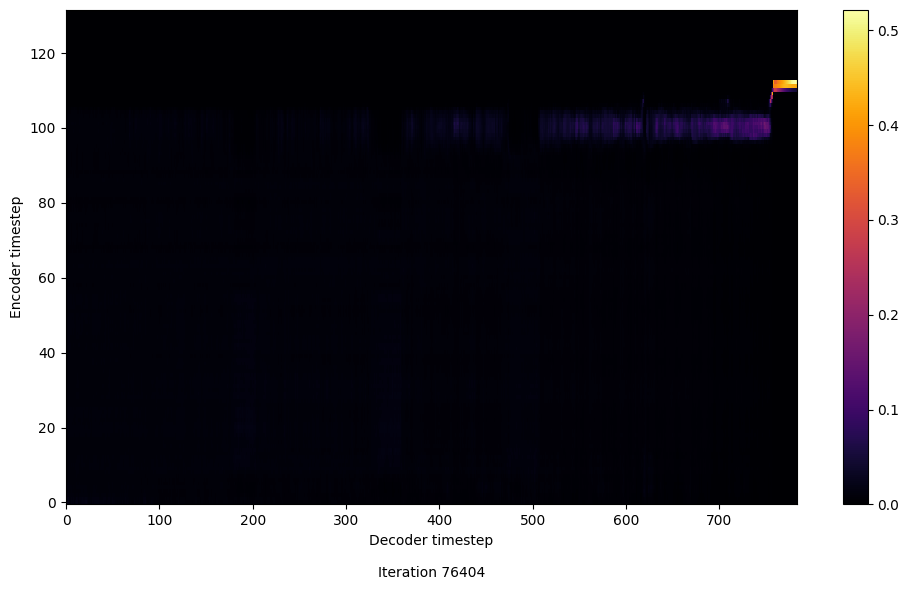

current learning rate :  [0.0001]
Epoch [35/250] completed in 7075.46s

Starting Epoch: 36/250


  0%|          | 1/2183 [00:02<1:44:59,  2.89s/it]

Epoch [36/250], Step [1/2183], Total Loss: 0.577346, Student Loss: 0.880766, Teacher Loss: 0.303586, Distillation Loss: 0.273927, Gradient Norm: 1.07, Learning Rate: 0.00010000, Duration: 2.88s


  0%|          | 4/2183 [00:12<1:57:40,  3.24s/it]


KeyboardInterrupt: 

In [28]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    print(f"\nStarting Epoch: {epoch+1}/{num_epochs}")
    start_epoch_time = time.perf_counter()

    # Set models to training/evaluation modes
    student_model.train()
    teacher_model.eval()  # Teacher model is in eval mode since we're not training it

    for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        start = time.perf_counter()

        # Adjust learning rate
        iteration = epoch * len(train_loader) + i
#         if iteration < hparams.decay_start:
#             learning_rate = hparams.A_
#         else:
#             iteration_adjusted = iteration - hparams.decay_start
#             learning_rate = (hparams.A_ * (math.e ** (-iteration_adjusted / hparams.B_))) + hparams.C_
#         learning_rate = max(hparams.min_learning_rate, learning_rate)
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = learning_rate

        optimizer.zero_grad()

        # Prepare data for student model
        x_student, y_student = student_model.parse_batch(batch)

        # Prepare data for teacher model
        x_teacher, y_teacher = teacher_model.parse_batch(batch)

        # Forward pass through student model
        y_pred_student = student_model(x_student)

        # Forward pass through teacher model (no gradient computation)
        with torch.no_grad():
            y_pred_teacher = teacher_model(x_teacher)

        # Compute standard Tacotron2 loss for student model
        loss_student = criterion(y_pred_student, y_student)
        loss_teacher = criterion(y_pred_teacher, y_teacher)
        # Compute distillation loss between student and teacher mel outputs
        student_mel_outputs = y_pred_student[1]  # mel_outputs_postnet from student model
        teacher_mel_outputs = y_pred_teacher[1]  # mel_outputs_postnet from teacher model

        # Ensure the shapes match
        if student_mel_outputs.shape != teacher_mel_outputs.shape:
            # Resize or pad outputs to match the shape
            min_length = min(student_mel_outputs.shape[2], teacher_mel_outputs.shape[2])
            student_mel_outputs = student_mel_outputs[:, :, :min_length]
            teacher_mel_outputs = teacher_mel_outputs[:, :, :min_length]

        # Compute distillation loss
        loss_distillation = distillation_criterion(student_mel_outputs, teacher_mel_outputs)

        # Total loss
        total_loss = alpha * loss_student + (1 - alpha) * loss_distillation

        # Backpropagation
        total_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(student_model.parameters(), hparams.grad_clip_thresh)
        optimizer.step()

        # Logging
        if i % 10 == 0:
            duration = time.perf_counter() - start
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                  f"Total Loss: {total_loss.item():.6f}, Student Loss: {loss_student.item():.6f}, Teacher Loss: {loss_teacher.item():.6f}, "
                  f"Distillation Loss: {loss_distillation.item():.6f}, "
                  f"Gradient Norm: {grad_norm:.2f}, "
                  f"Learning Rate: {learning_rate:.8f}, "
                  f"Duration: {duration:.2f}s")

    # Validation after each epoch
    val_loss = validate(student_model, criterion, valset, iteration, hparams.batch_size, n_gpus, collate_fn, None, hparams.distributed_run, rank, epoch, start_epoch_time, learning_rate)
    scheduler.step(val_loss)
    print('current learning rate : ',scheduler.get_last_lr())
#     learning_rate = scheduler.get_last_lr()

    # Save checkpoint with epoch number
    # if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
    #     checkpoint_path_epoch = os.path.join(output_directory, f"{model_filename}.pt")
    #     torch.save({
    #         'epoch': epoch + 1,
    #         'state_dict': student_model.state_dict(),
    #         'optimizer': optimizer.state_dict(),
    #         'learning_rate': learning_rate
    #     }, checkpoint_path_epoch)
    #     print(f"Checkpoint saved at {checkpoint_path_epoch}")

    # Backup checkpoint
    if backup_interval > 0 and (epoch + 1) % backup_interval == 0:
        backup_path = f"{checkpoint_path_epoch}_backup"
        torch.save({
            'epoch': epoch + 1,
            'state_dict': student_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'learning_rate': learning_rate
        }, backup_path)
        print(f"Backup checkpoint saved at {backup_path}")

    epoch_duration = time.perf_counter() - start_epoch_time
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s")

print("\nTraining completed successfully.")

In [32]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from layers import TacotronSTFT  # Ensure this is correctly defined
from text import text_to_sequence, symbols  # Ensure these are correctly defined
from utils import load_wav_to_torch, load_filepaths_and_text  # Ensure these are correctly defined
from hparams import create_hparams  # Ensure this is correctly defined
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyperparameters (Ensure they match those used during training)
hparams = create_hparams()
hparams.batch_size = 1  # For inference, batch size is typically 1
hparams.n_mel_channels = 80  # Ensure this matches your training config
hparams.sampling_rate = 22050  # Ensure this matches your training config
hparams.max_wav_value = 32768.0
hparams.mel_fmin = 0.0
hparams.mel_fmax = 8000.0

# Initialize the model
student_model = StudentTacotron2().to(device)
student_model.eval()  # Set model to evaluation mode

# Path to the trained student model checkpoint
checkpoint_path = '/kaggle/working/outdir/lj2.pt'  # Update this path as needed

# Load the trained model
if os.path.isfile(checkpoint_path):
    print(f"Loading checkpoint '{checkpoint_path}'")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    student_model.load_state_dict(checkpoint['state_dict'])
    print(f"Loaded checkpoint '{checkpoint_path}' (epoch {checkpoint['epoch']})")
else:
    raise FileNotFoundError(f"Checkpoint '{checkpoint_path}' not found.")

# Define the STFT transformation
stft = TacotronSTFT(
    filter_length=1024,
    hop_length=256,
    win_length=1024,
    n_mel_channels=hparams.n_mel_channels,
    sampling_rate=hparams.sampling_rate,
    mel_fmin=hparams.mel_fmin,
    mel_fmax=hparams.mel_fmax
).to(device)

# Modify TacotronSTFT to store hop_length as an attribute (if not already done)
stft.hop_length = 256  # Ensure this matches the hop_length used in initialization

# Function to generate mel spectrogram from text
def synthesize(text, model, stft, device, hparams):
    """Generates mel spectrogram from input text using the trained model."""
    # Preprocess the text
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))
    sequence = torch.from_numpy(sequence).unsqueeze(0).to(device).long()
    
    # Compute input lengths
    input_lengths = torch.LongTensor([sequence.shape[1]]).to(device)
    
    # Embed the text
    embedded_inputs = model.embedding(sequence).transpose(1, 2)
    
    # Pass through encoder
    encoder_outputs = model.encoder(embedded_inputs, input_lengths)
    
    # Perform decoder inference
    mel_outputs, gate_outputs, alignments = model.decoder.inference(encoder_outputs)
    
    # Pass through postnet
    mel_outputs_postnet = model.postnet(mel_outputs)
    mel_outputs_postnet = mel_outputs + mel_outputs_postnet
    
    # Convert to CPU and numpy
    mel = mel_outputs_postnet.squeeze(0).cpu().detach().numpy()
    
    return mel, alignments

# Function to convert mel spectrogram to audio using Griffin-Lim
def griffin_lim(mel, stft, n_iters=60):
    """Converts a mel spectrogram back to audio using the Griffin-Lim algorithm."""
    # De-normalize mel spectrogram
    mel_decompress = stft.spectral_de_normalize(torch.from_numpy(mel).unsqueeze(0))
    mel_decompress = mel_decompress.squeeze(0).cpu().numpy()
    
    # Invert the mel spectrogram to linear spectrogram
    inv_mel = librosa.feature.inverse.mel_to_stft(
        mel_decompress,
        sr=hparams.sampling_rate,
        n_fft=stft.stft_fn.filter_length,
        fmin=hparams.mel_fmin,
        fmax=hparams.mel_fmax
    )
    
    # Apply Griffin-Lim to reconstruct the waveform
    audio = librosa.griffinlim(
        inv_mel,
        n_iter=n_iters,
        hop_length=stft.stft_fn.hop_length,
        win_length=stft.stft_fn.win_length
    )
    
    # Normalize the audio
    audio = audio / np.max(np.abs(audio))
    
    return audio

# Function to plot and display the mel spectrogram and alignments
def plot_spectrogram(mel, alignments=None, save_path=None, stft=None):
    """Plots the mel spectrogram and optionally the attention alignments."""
    plt.figure(figsize=(10, 4))

    # Access hop_length directly from stft
    hop_length = stft.hop_length if stft is not None else 256  # Default hop_length

    librosa.display.specshow(mel, sr=hparams.sampling_rate, hop_length=hop_length,
                             x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

    if alignments is not None:
        plt.figure(figsize=(10, 4))
        # Process alignments for plotting
        alignments_np = alignments.squeeze(0).cpu().detach().numpy()
        plt.imshow(alignments_np, aspect='auto', origin='lower')
        plt.title('Attention Alignments')
        plt.xlabel('Decoder Timesteps')
        plt.ylabel('Encoder Timesteps')
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path.replace('.png', '_alignments.png'))
        plt.show()

# Example text to synthesize
input_text = "especially as no more time is occupied, or cost incurred, in casting, setting, or printing beautiful letters"

# Synthesize the text
mel, alignments = synthesize(input_text, student_model, stft, device, hparams)

# Plot the mel spectrogram and alignments
plot_spectrogram(mel, alignments, stft=stft)

# Convert mel spectrogram to audio using Griffin-Lim
audio = griffin_lim(mel, stft)

# Save the audio to a WAV file
# output_audio_path = 'generated_audio.wav'
# librosa.output.write_wav(output_audio_path, audio, sr=hparams.sampling_rate)
# print(f"Audio saved to '{output_audio_path}'")

# (Optional) Play the audio in Jupyter Notebook
try:
    from IPython.display import Audio
    display(Audio(audio, rate=hparams.sampling_rate))
except ImportError:
    print("IPython is not available. Audio playback is skipped.")


Loading checkpoint '/kaggle/working/outdir/lj2.pt'
Loaded checkpoint '/kaggle/working/outdir/lj2.pt' (epoch 36)
Warning! Reached max decoder steps


In [5]:
!pip install unidecode inflect

In [29]:
if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        checkpoint_path_epoch = os.path.join(output_directory, f"{model_filename}.pt")
        torch.save({
            'epoch': epoch + 1,
            'state_dict': student_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'learning_rate': learning_rate
        }, checkpoint_path_epoch)
        print(f"Checkpoint saved at {checkpoint_path_epoch}")

Checkpoint saved at /kaggle/working/outdir/lj2.pt
